# Foul-Won-On-Possession Prediction

**Objective**

Predict the probability that a player will win a foul during their possession immediately following a ball receipt or recovery.

**Framing the Prediction Task**

This objective can be approached in two distinct ways:
	
    
1.	**First Touch Prediction**: Predict foul occurrence directly upon the player’s initial ball receipt or recovery event.
	
    
2.	**Possession Chain Prediction**: Analyze the entire sequence of events constituting a player’s possession to predict foul occurrence.

Given the betting-focused use case, the First Touch prediction approach is most appropriate. However, contextual features derived from preceding events  (previous $N$ events) will be incorporated into our predictive modeling.

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import lightgbm as lgb # import error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    log_loss, brier_score_loss, classification_report, confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

# Helpers

In [74]:
import matplotlib.patches as patches

def plot_statsbomb_pitch(ax=None, pitch_color='white', line_color='black', figsize=(12, 8), show=False):
    """
    Plots a StatsBomb-style football pitch (120x80) with Matplotlib.
    Origin: bottom-left corner.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor(pitch_color)

    # Pitch outline and center line
    plt.plot([0, 0, 120, 120, 0], [0, 80, 80, 0, 0], color=line_color)
    plt.plot([60, 60], [0, 80], color=line_color)  # Halfway line

    # Center circle and spot
    centre_circle = plt.Circle((60, 40), 9.15, color=line_color, fill=False)
    centre_spot = plt.Circle((60, 40), 0.8, color=line_color)
    ax.add_patch(centre_circle)
    ax.add_patch(centre_spot)

    # Penalty boxes and 6-yard boxes
    for x in [0, 120]:
        side = 1 if x == 0 else -1
        ax.add_patch(patches.Rectangle((x - side * 18, 30), side * 18, 20, edgecolor=line_color, facecolor='none'))
        ax.add_patch(patches.Rectangle((x - side * 6, 36), side * 6, 8, edgecolor=line_color, facecolor='none'))
        plt.plot(x - side * 11, 40, 'o', color=line_color)

        arc = patches.Arc((x - side * 11, 40), height=18.3, width=18.3, angle=0,
                          theta1=308 if x == 0 else 128, theta2=52 if x == 0 else 232, color=line_color)
        ax.add_patch(arc)

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.axis('off')

    if show:
        plt.show()
    else:
        return ax

# Import Data

In [6]:
match_df = pd.read_csv('epl_matches_15.csv')
match_df.head()

Unnamed: 0  match_id  match_date      kick_off  home_score  away_score  \
0           1   3754058  2016-01-02  16:00:00.000           0           0   
1           2   3754245  2015-10-17  16:00:00.000           1           0   
2           3   3754136  2015-12-19  18:30:00.000           1           1   
3           4   3754037  2016-04-30  16:00:00.000           2           1   
4           5   3754039  2016-02-13  16:00:00.000           1           2   

  match_status                last_updated  match_week  \
0    available  2021-10-29T23:44:19.940296          20   
1    available  2022-12-01T13:09:17.044015           9   
2    available  2020-11-12T23:48:19.757269          17   
3    available     2021-07-07T17:59:57.456          36   
4    available     2021-07-25T18:09:51.386          26   

   competition.competition_id  ... away_team.away_team_name  \
0                           2  ...          AFC Bournemouth   
1                           2  ...               Sunderland   
2                           2  ...              Aston Villa   
3                           2  ...          AFC Bournemouth   
4                           2  ...                  Watford   

                                  away_team.managers  competition_stage.id  \
0        38, Eddie Howe, NA, 1977-11-29, 68, England                     1   
1    561, Sam Allardyce, NA, 1954-10-19, 68, England                     1   
2         92, Rémi Garde, NA, 1966-04-03, 78, France                     1   
3        38, Eddie Howe, NA, 1977-11-29, 68, England                     1   
4  236, Enrique Sánchez Flores, Quique Sánchez Fl...                     1   

  competition_stage.name  stadium.id         stadium.name referee.id  \
0         Regular Season          20  King Power Stadium           5   
1         Regular Season          33        The Hawthorns          4   
2         Regular Season        4674     St. James'' Park          4   
3         Regular Season          12        Goodison Park          7   
4         Regular Season          37        Selhurst Park          9   

      referee.name referee.country.id referee.country.name  
0   Andre Marriner                 68              England  
1  Martin Atkinson                 68              England  
2  Martin Atkinson                 68              England  
3   Neil Swarbrick                 68              England  
4    Robert Madley                 68              England  

[5 rows x 28 columns]

In [7]:
match_df.shape

(380, 28)

In [8]:
match_df.columns

Index(['Unnamed: 0', 'match_id', 'match_date', 'kick_off', 'home_score',
       'away_score', 'match_status', 'last_updated', 'match_week',
       'competition.competition_id', 'competition.country_name',
       'competition.competition_name', 'season.season_id',
       'season.season_name', 'home_team.home_team_id',
       'home_team.home_team_name', 'home_team.managers',
       'away_team.away_team_id', 'away_team.away_team_name',
       'away_team.managers', 'competition_stage.id', 'competition_stage.name',
       'stadium.id', 'stadium.name', 'referee.id', 'referee.name',
       'referee.country.id', 'referee.country.name'],
      dtype='object')

In [9]:
events_df = pd.read_csv('epl_event_data_15.csv')
events_df.head()

id  index  period     timestamp  minute  \
0  9153e9f4-f69c-4e04-8f64-505592e212cd      1       1  00:00:00.000       0   
1  3fbcf4e7-94d1-485a-be85-fd26a6af0318      2       1  00:00:00.000       0   
2  06a9a4dc-d9c9-40f6-bd89-437ba7fe682d      3       1  00:00:00.000       0   
3  100362ee-9311-4187-bd8a-0201d9db2565      4       1  00:00:00.000       0   
4  2ca23eea-a984-47e4-8243-8f00880ad1c9      5       1  00:00:01.753       0   

   second  possession  player_possession  duration  \
0       0           1                  1  0.000000   
1       0           1                  2  0.000000   
2       0           1                  3  0.000000   
3       0           1                  4  0.000000   
4       1           2                  5  0.308263   

                         related_events  ... pass.end_location  \
0                                   NaN  ...               NaN   
1                                   NaN  ...               NaN   
2  100362ee-9311-4187-bd8a-0201d9db2565  ...               NaN   
3  06a9a4dc-d9c9-40f6-bd89-437ba7fe682d  ...               NaN   
4  1f98c89e-2326-4200-8c12-a987fdbbaf2e  ...        60.4, 43.6   

  dribble.outcome.id dribble.outcome.name  ball_receipt.outcome.id  \
0                NaN                  NaN                      NaN   
1                NaN                  NaN                      NaN   
2                NaN                  NaN                      NaN   
3                NaN                  NaN                      NaN   
4                NaN                  NaN                      NaN   

  ball_receipt.outcome.name  carry.end_location duel.outcome.id  \
0                       NaN                 NaN             NaN   
1                       NaN                 NaN             NaN   
2                       NaN                 NaN             NaN   
3                       NaN                 NaN             NaN   
4                       NaN                 NaN             NaN   

   duel.outcome.name competition_id  match_id  
0                NaN              2   3754058  
1                NaN              2   3754058  
2                NaN              2   3754058  
3                NaN              2   3754058  
4                NaN              2   3754058  

[5 rows x 49 columns]

In [10]:
events_df.shape

(1313783, 49)

In [11]:
events_df.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'player_possession', 'duration', 'related_events', 'location',
       'under_pressure', 'counterpress', 'type.id', 'type.name',
       'possession_team.id', 'possession_team.name', 'play_pattern.id',
       'play_pattern.name', 'team.id', 'team.name', 'tactics.formation',
       'tactics.lineup', 'player.id', 'player.name', 'position.id',
       'position.name', 'pass.length', 'pass.angle', 'pass.height.id',
       'pass.height.name', 'pass.body_part.id', 'pass.body_part.name',
       'pass.type.id', 'pass.type.name', 'pass.outcome.id',
       'pass.outcome.name', 'pass.receipient.id', 'pass.recipient.name',
       'pass.end_location', 'dribble.outcome.id', 'dribble.outcome.name',
       'ball_receipt.outcome.id', 'ball_receipt.outcome.name',
       'carry.end_location', 'duel.outcome.id', 'duel.outcome.name',
       'competition_id', 'match_id'],
      dtype='object')

## Dataset Overview

We utilize **StatsBomb event-level data** for modeling and analysis. The dataset consists of multiple layers of information:

### Match-Level Metadata
- **Team Context:** Squad lineups, player identities, and managerial assignments.
- **Referee Context:** Referee identification and assignments per match.
- **Venue Context:** Home vs. Away team designation.

### Event-Level Information
- **Temporal Features:**  
  Timestamp and minute of event occurrence within the match timeline.
- **Tactical Features:**  
  Starting lineups, player formations, and tactical setups.
- **Spatial Features:**  
  Event location coordinates on the pitch.
- **Possession Features:**  
  Possession sequences, possession team identification, and turnover events.
- **Pass Features:**  
  Detailed pass metadata including pass type, recipient, length, and outcome.
- **Event Type Features:**  
  Event classification (e.g., pass, duel, foul, shot, interception, etc.).
- **Player Features:**  
  Player executing the event and player-level attributes.

### Qualifier Information
Additional attributes are provided for specialized event types:
- **Pass Qualifiers:**  
  Outcome (completed, incomplete), pass technique (e.g., through ball, cross).
- **Dribble Qualifiers:**  
  Dribble outcome (complete, incomplete).
- **Duel Qualifiers:**  
  Duel type and outcome (e.g., success, failure, ground duel, aerial duel).

### Data Limitations
We do **not** have access to **StatsBomb360** data, which provides the positional coordinates of all players at each event.  
Given the nature of the modeling objective—predicting foul occurrence based on in-game dynamics—this limitation is significant.  
Without 360 data:
- It becomes difficult to quantify the **pressure** exerted by defenders.
- Spatial context such as player density, proximity to opponents, and passing options is unavailable.
- As a result, identifying and anticipating fouls purely from event-level metadata is inherently more challenging and noisy.

In [28]:
events_df['is_foul_won'] = (events_df['type.name'] == 'Foul Won')

# out of all the events occurring at a minute m, how many of them are "Foul Won" 
# Players are more tired towards the end of the game, may result in more foul committed
minute_stats = (
    events_df
    .groupby(['minute'])
    .agg(
        total_events    = ('id', 'size'),
        foul_won_events = ('is_foul_won', 'sum'),
        foul_won_rate = ('is_foul_won', 'mean')
    )
    .sort_index()
)

minute_stats = minute_stats.loc[:90]
minute_stats.head()

total_events  foul_won_events  foul_won_rate
minute                                              
0              21383               79       0.003695
1              15454               72       0.004659
2              15674               83       0.005295
3              14958              100       0.006685
4              15658               78       0.004981

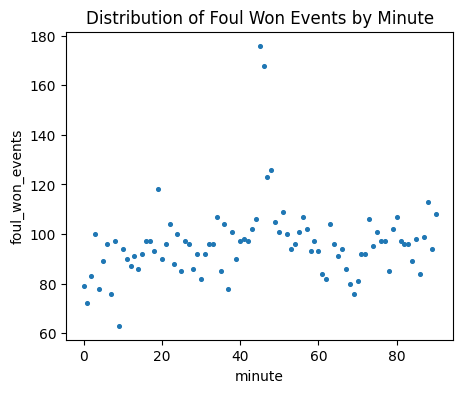

In [26]:
fig, ax = plt.subplots(1, figsize=(5,4))
minute_stats.reset_index().plot.scatter("minute", "foul_won_events", s=7, ax=ax)
plt.title("Distribution of Foul Won Events by Minute")
plt.show()

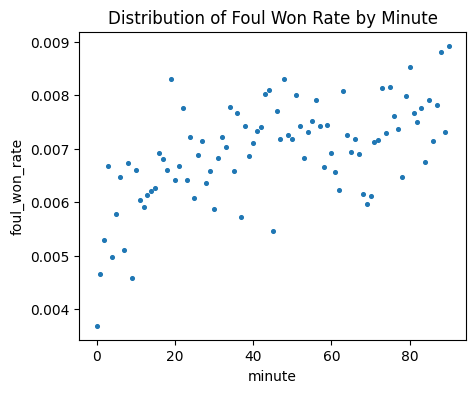

In [25]:
fig, ax = plt.subplots(1, figsize=(5,4))
minute_stats.reset_index().plot.scatter("minute", "foul_won_rate", s=7, ax=ax)
plt.title("Distribution of Foul Won Rate by Minute")
plt.show()

1. Fouls concentrate around the end of each half, both in absolute numbers and relative to total events.
	
2. Foul-won probability increases over time, suggesting fatigue and tactical fouling amplify as matches progress.

In [10]:
"""
    No Team Formation information for almost all of the events.
    This is a crucial miss as this could have been used as a proxy to understand how 
    many players are "supposed" to be in a zone
"""

events_df['tactics.formation'].isna().sum()/events_df.shape[0]

0.9989457924177737

# Possessions Started

In [29]:
possessions_started_mask = events_df['type.name'].isin(['Ball Recovery', 'Ball Receipt*'])

possessions_started = events_df.loc[
    possessions_started_mask
    , 'player.name'
].value_counts()

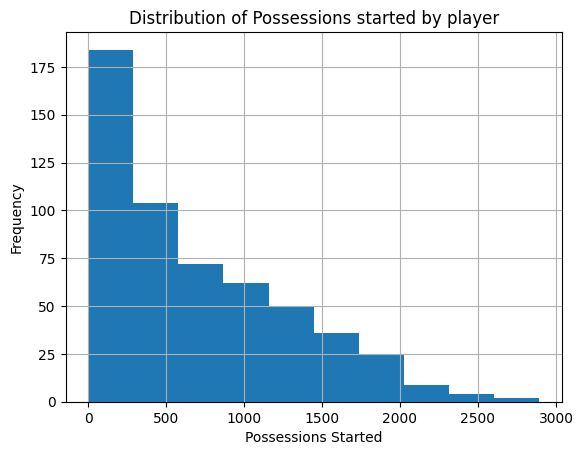

In [32]:
possessions_started.hist()
plt.title("Distribution of Possessions started by player")
plt.xlabel("Possessions Started")
plt.ylabel("Frequency")
plt.show()

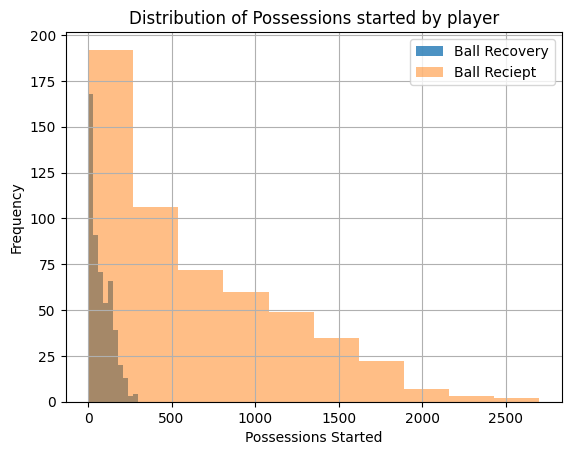

In [31]:
events_df.loc[events_df['type.name']=='Ball Recovery', 'player.name'].value_counts().hist(alpha=0.8, label='Ball Recovery')
events_df.loc[events_df['type.name']=='Ball Receipt*', 'player.name'].value_counts().hist(alpha=0.5, label='Ball Reciept')
plt.title("Distribution of Possessions started by player")
plt.xlabel("Possessions Started")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [33]:
possessions_started_by_position = events_df.loc[
    possessions_started_mask
    , 'position.name'
].value_counts()

In [34]:
possessions_started_by_position

position.name
Center Forward               36106
Left Back                    30411
Right Back                   30402
Center Attacking Midfield    29265
Left Wing                    25827
Right Wing                   25799
Left Center Back             25405
Right Center Back            24893
Left Defensive Midfield      21172
Right Defensive Midfield     20994
Left Center Midfield         19968
Right Center Midfield        19636
Right Midfield               13917
Left Midfield                13473
Goalkeeper                   11922
Right Center Forward          9673
Left Center Forward           9331
Center Defensive Midfield     8083
Right Wing Back               1413
Left Wing Back                1356
Center Back                    874
Right Attacking Midfield       677
Left Attacking Midfield        652
Center Midfield                 18
Name: count, dtype: int64

# Fouls Won

In [35]:
# winning a foul 

foul_won_events = events_df[events_df['is_foul_won']==1]

Text(0.5, 1.0, 'Distribution of how many times a player won a foul')

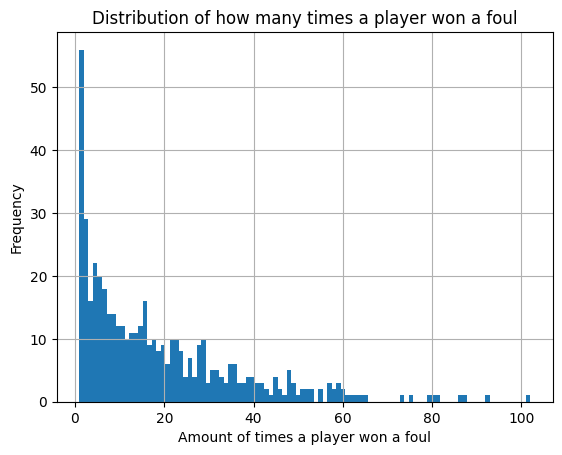

In [36]:
foul_won_events['player.name'].value_counts().hist(bins=100)
plt.xlabel('Amount of times a player won a foul')
plt.ylabel('Frequency')
plt.title('Distribution of how many times a player won a foul')

## Player recived or recovered the ball & won the foul

In [37]:
possession_initiated_by_player = events_df.loc[
    events_df['type.name'].isin(['Ball Recovery', 'Ball Receipt*'])
    , 'player.name'
].value_counts()

possession_initiated_by_player.shape

(548,)

In [38]:
fouls_won_by_player = events_df.loc[
    events_df['type.name'] == 'Foul Won'
    , 'player.name'
].value_counts()

fouls_won_by_player.shape

(480,)

In [39]:
conversion_df = possession_initiated_by_player.to_frame(name='possessions_started').join(
    fouls_won_by_player.to_frame(name='fouls_won')
    , on='player.name'
    , how='left'
).fillna(0)
conversion_df.head()

possessions_started  fouls_won
player.name                                              
Francesc Fàbregas i Soler                 2892       51.0
Mesut Özil                                2832       53.0
Aaron Ramsey                              2494       57.0
Troy Deeney                               2386       45.0
Romelu Lukaku Menama                      2364       35.0

In [40]:
# conversion rate

conversion_df['conversion_rate'] = conversion_df['fouls_won']/conversion_df['possessions_started']
conversion_df.head()

possessions_started  fouls_won  conversion_rate
player.name                                                               
Francesc Fàbregas i Soler                 2892       51.0         0.017635
Mesut Özil                                2832       53.0         0.018715
Aaron Ramsey                              2494       57.0         0.022855
Troy Deeney                               2386       45.0         0.018860
Romelu Lukaku Menama                      2364       35.0         0.014805

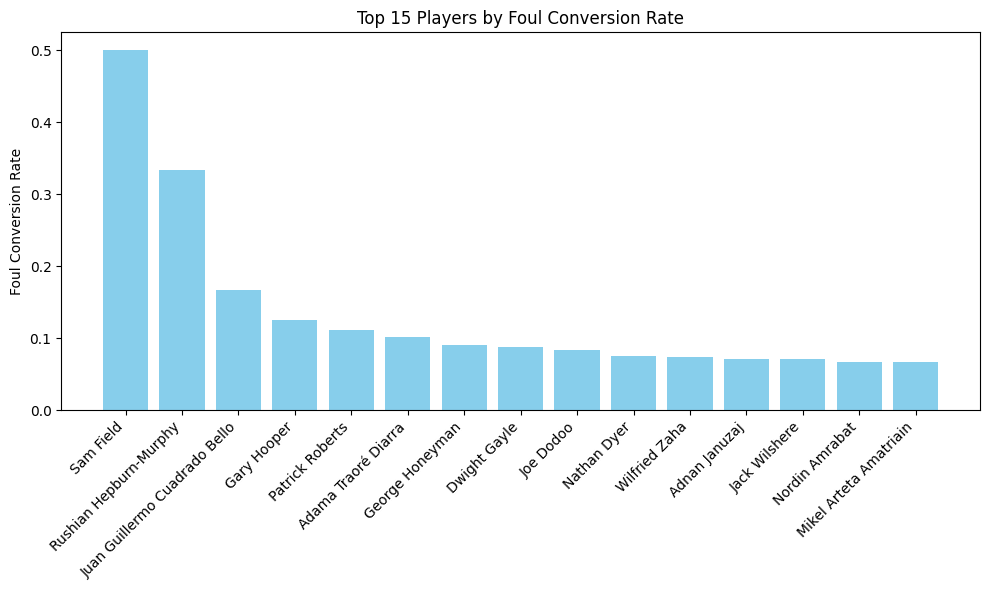

In [41]:
plt.figure(figsize=(10, 6))
top_converters = conversion_df.sort_values('conversion_rate', ascending=False).head(15)

plt.bar(top_converters.index, top_converters['conversion_rate'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Foul Conversion Rate')
plt.title('Top 15 Players by Foul Conversion Rate')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of possessions started by a player')

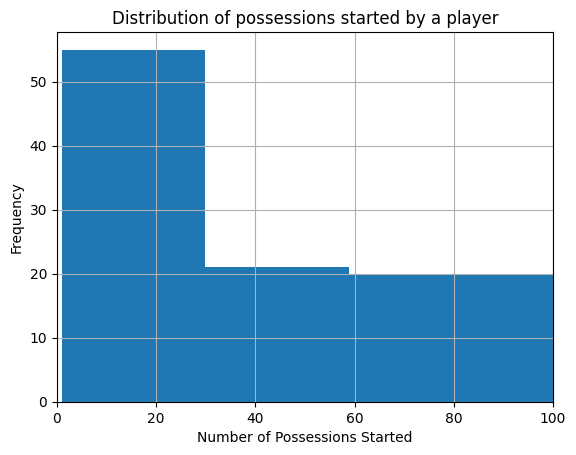

In [42]:
conversion_df['possessions_started'].hist(bins=100)
plt.xlabel('Number of Possessions Started')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.title('Distribution of possessions started by a player')

We need to filter our players with low possessions started to get an accurate view of conversion rate

In [43]:
filter_possessions_started = conversion_df['possessions_started'] > 30

In [44]:
filtered_conversion_df = conversion_df.loc[filter_possessions_started, :]

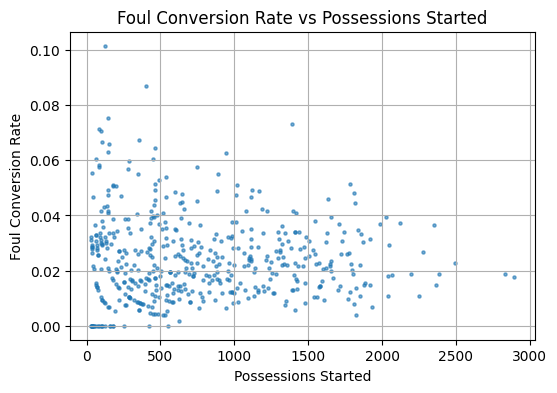

In [45]:
plt.figure(figsize=(6,4))
plt.scatter(
    filtered_conversion_df['possessions_started']
    , filtered_conversion_df['conversion_rate']
    , alpha=0.6
    , s=5
)
plt.xlabel("Possessions Started")
plt.ylabel("Foul Conversion Rate")
plt.title("Foul Conversion Rate vs Possessions Started")
plt.grid(True)
plt.show()

Lots of noise when possessions are few; as sample size grows, player foul-win rates converge to around 2–3 % per possession

In [46]:
# add player position information

filtered_conversion_df = filtered_conversion_df.merge(
    events_df.groupby('player.name')['position.name'].agg(lambda x: x.value_counts().index[0]) # mode
    , how='left'
    , on='player.name'
)

filtered_conversion_df.head()

possessions_started  fouls_won  conversion_rate  \
player.name                                                                  
Francesc Fàbregas i Soler                 2892       51.0         0.017635   
Mesut Özil                                2832       53.0         0.018715   
Aaron Ramsey                              2494       57.0         0.022855   
Troy Deeney                               2386       45.0         0.018860   
Romelu Lukaku Menama                      2364       35.0         0.014805   

                                       position.name  
player.name                                           
Francesc Fàbregas i Soler   Right Defensive Midfield  
Mesut Özil                 Center Attacking Midfield  
Aaron Ramsey                 Left Defensive Midfield  
Troy Deeney                     Right Center Forward  
Romelu Lukaku Menama                  Center Forward

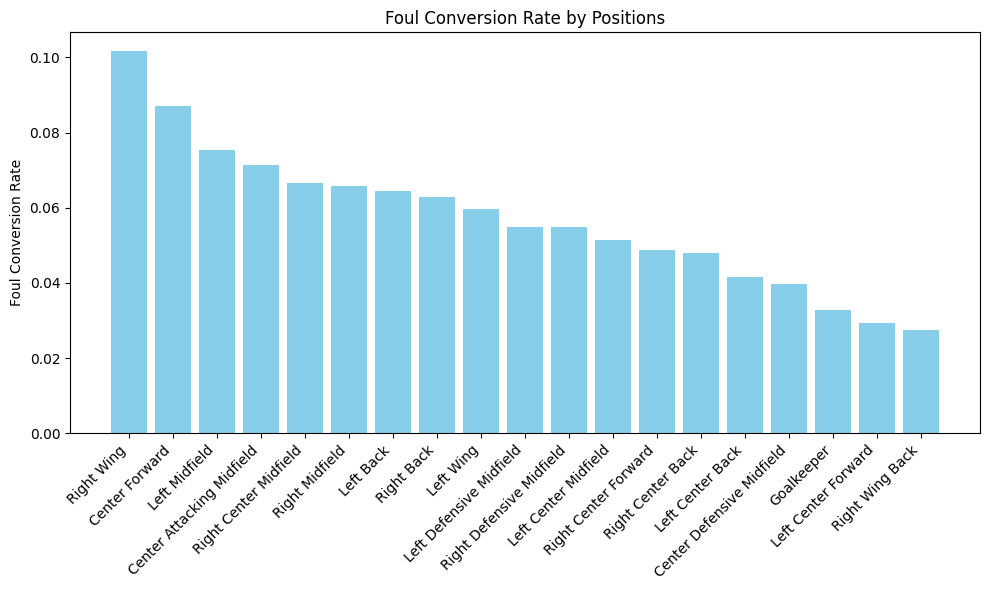

In [47]:
# top_converters = conversion_df[conversion_df['possessions_started'] >= 20]  # filter for stability
top_converters = filtered_conversion_df.sort_values('conversion_rate', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(top_converters['position.name'], top_converters['conversion_rate'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Foul Conversion Rate')
plt.title('Foul Conversion Rate by Positions')
plt.tight_layout()
plt.show()

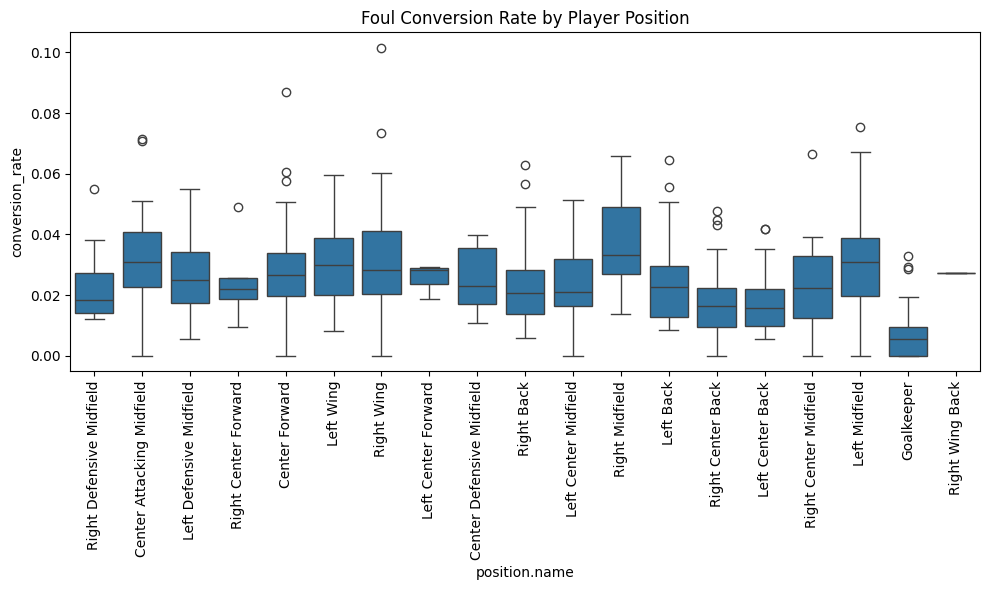

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_conversion_df, x='position.name', y='conversion_rate')
plt.xticks(rotation=90)
plt.title("Foul Conversion Rate by Player Position")
plt.tight_layout()
plt.show()

In [49]:
def normalize_position(pos):
    pos = str(pos).lower()
    if any(term in pos for term in ['back', 'defender']):
        return 'Defense'
    elif any(term in pos for term in ['midfield']):
        return 'Midfield'
    elif any(term in pos for term in ['wing', 'forward', 'attacking']):
        return 'Attack'
    else:
        return 'Goalkeeper'  # goalkeeper

filtered_conversion_df['position_group'] = filtered_conversion_df['position.name'].apply(normalize_position)

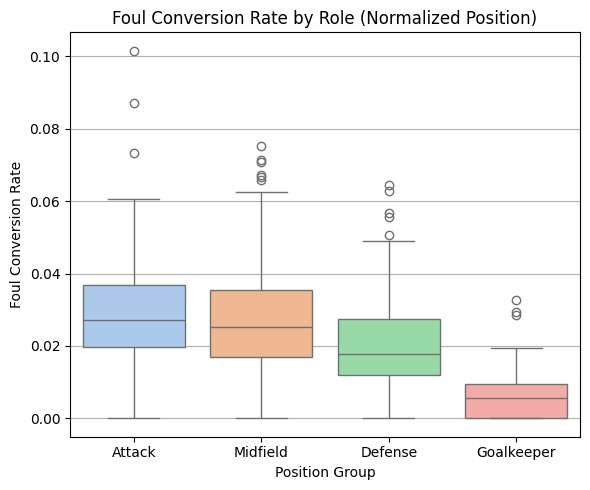

In [50]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=filtered_conversion_df.sort_values('conversion_rate', ascending=False), x='position_group', y='conversion_rate', hue='position_group', palette='pastel')
plt.title("Foul Conversion Rate by Role (Normalized Position)")
plt.ylabel("Foul Conversion Rate")
plt.xlabel("Position Group")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

- Player role matters : Front-line attackers draw fouls at roughly double the rate of defenders and ten-plus times the rate of keepers.
	
- Volume alone isn’t predictive : Simply having more possession doesn’t guarantee more fouls won per possession.

- High variance within roles implies that individual player style (speed, dribbling, physicality) strongly influences foul-drawing ability even beyond positional norms.

## Location

In [53]:
events_df["location"].isna().sum()

np.int64(8077)

In [54]:
# dropping rows without location information

events_df = events_df.dropna(subset=["location"])

In [55]:
events_df[["location_x", "location_y"]] = events_df["location"].str.split(",", expand=True).astype(float)

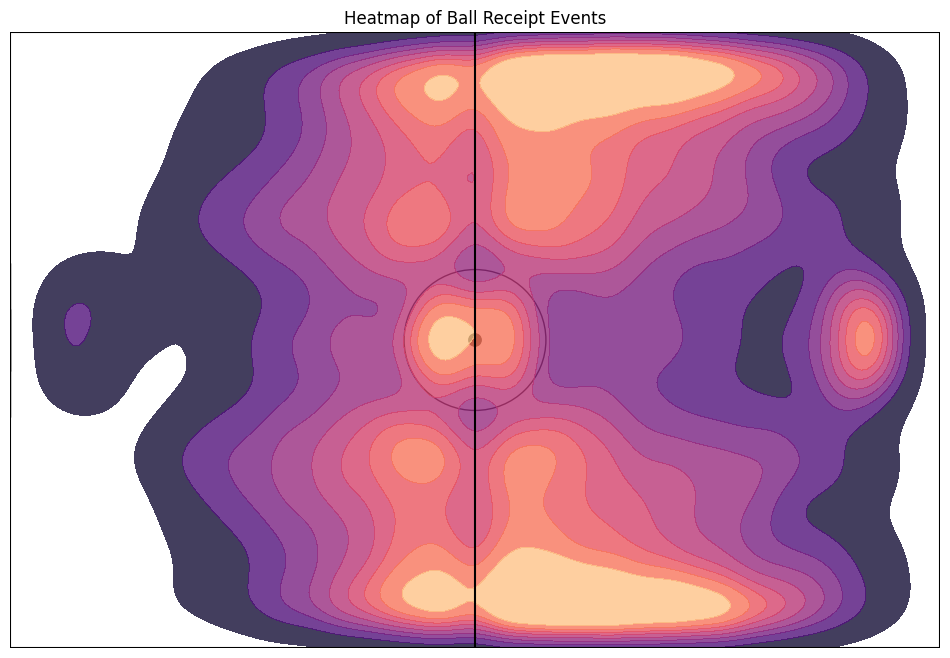

In [64]:
# Plot location heatmap of ball reciept events
ax = plot_statsbomb_pitch()
sns.kdeplot(
    data=events_df[events_df['type.name']=='Ball Receipt*']
    , x="location_x"
    , y="location_y"
    , cmap="magma"
    , fill=True
    , thresh=0.05
    , alpha=0.8
    , ax=ax
)
plt.title("Heatmap of Ball Receipt Events")
plt.show()

Players most often receive the ball in four main regions — midfield spine, left wing, right wing, and just outside the box — and these zones will drive how we encode spatial context for foul‐prediction model

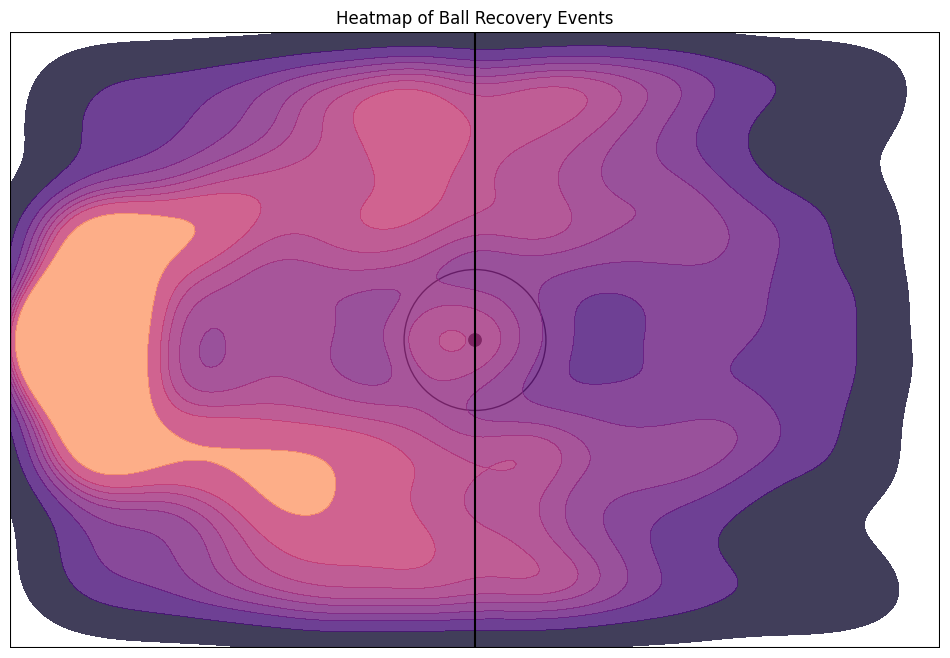

In [65]:
# Plot location heatmap of ball recovery events
ax = plot_statsbomb_pitch()
sns.kdeplot(
    data=events_df[events_df['type.name']=='Ball Recovery']
    , x="location_x"
    , y="location_y"
    , cmap="magma"
    , fill=True
    , thresh=0.05
    , alpha=0.8
    , ax=ax
)
plt.title("Heatmap of Ball Recovery Events")
plt.show()

* High density for ball recoveries near the penalty area - last ditch tackles, defenders dominate, opposition playing risky forward passes
* Sparse recoveries upfront by the forwards

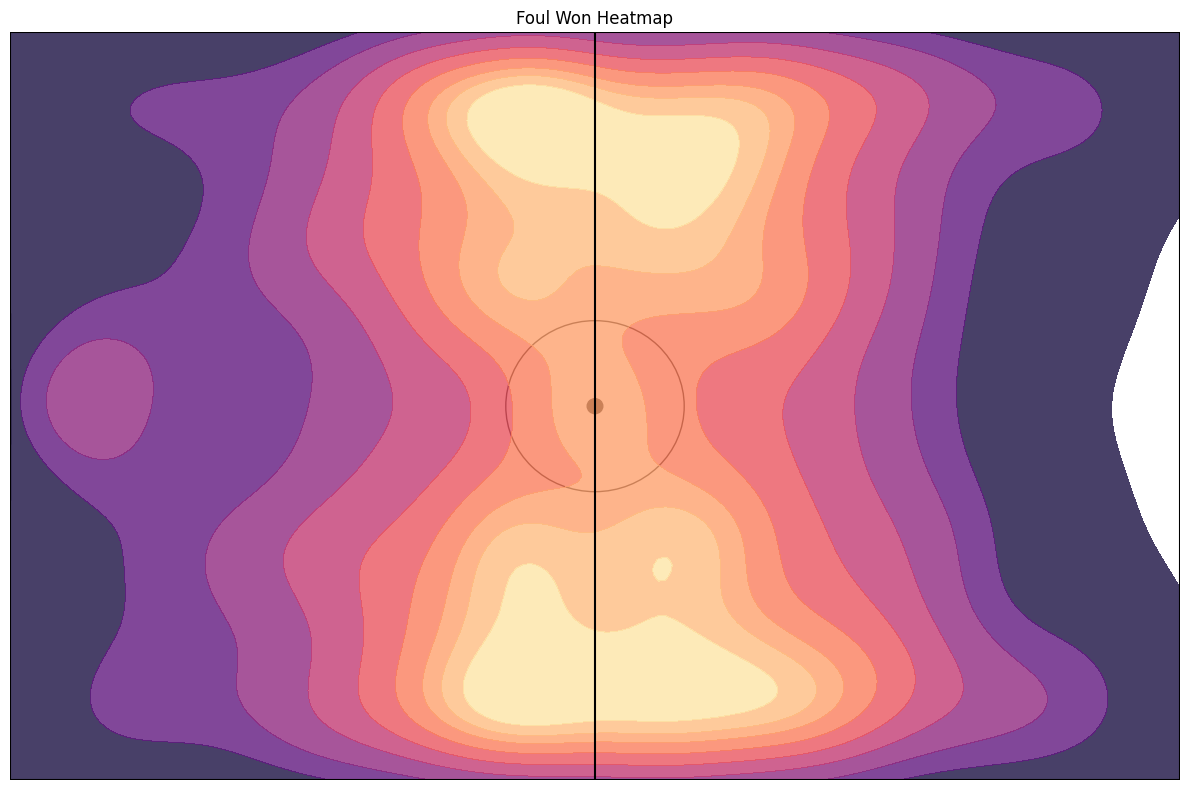

In [67]:
ax = plot_statsbomb_pitch()
sns.kdeplot(
    data=events_df[events_df["type.name"] == "Foul Won"]
    , x="location_x"
    , y="location_y"
    , fill=True
    , cmap="magma"
    , thresh=0.01
    , alpha=0.8
    , ax=ax
)
plt.title("Foul Won Heatmap")
plt.tight_layout()
plt.show()

* High density of fouls won in the midfield and wings
* Fouls are less common where players are playing safer

# Game State Feature Engineering

- **`is_home`**
  Boolean: `1` if possession team is playing at home, else `0`
- **~`is_opp_trailing`~**  
  Boolean: `1` if possession team’s goals > opponent’s goals at that timestamp, else `0`. **Shot outcome data unavailable**
- **~`score_diff`~**  
  Integer:  `(team_goals – opp_goals)`. Captures magnitude of lead/deficit. **Shot outcome data unavailable**
- **~`score_state`~**  
  Categorical: “Leading” / “Tied” / “Trailing”. **Shot outcome data unavailable**
- **~`time_in_state`~**  
  Continuous: minutes elapsed since last goal changed the state. **Shot outcome data unavailable**
- **~`opp_trail_duration`~**  
  Cumulative minutes spent trailing so far (fatigue/stress proxy). **Shot outcome data unavailable**
- **`match_week`**
  Importance of the match, **if combined with table position would have provided a richer context but table position per match is unavailable.**
- **`minute`**  
  Raw match minute [0–90+].  
- **`time_remaining`**  
  `max_minute – minute` (e.g. 90 – minute).  
- **`is_stoppage_time`**  
  Boolean: `minute > 45+injury1` or `minute > 90+injury2`.  
- **`phase_of_play`**  
  Categorical: Early (0–15), First‑half (16–45), Second‑half (46–75), Endgame (76–90+).  
- **`minute_norm`**  
  Standardized minute → mean 0, σ 1 (for easier coefficient tuning).  
- **`minute_sq`**  
  Non‑linear term: `minute_norm²` to capture accelerating end‑game fouls.
- **`zone_x`, `zone_y`**  
  Discretize `location` into a 6 × 4 grid (x‐bins 0–5, y‐bins 0–3).  
- **`zone_id`**  
  Single ordinal: `zone_x * n_y_bins + zone_y` (0–23).  
- **`zone_type`**  
  Categorical: Defensive third / Midfield third / Attacking third (via `x` bins).  
- **`side_of_pitch`**  
  Categorical: Left / Center / Right (`y` bins).  
- **`distance_to_goal`**  
  Continuous: normalized distance from event `x`‑coordinate to opponent’s goal line.  
- **`is_penalty_area`**  
  Boolean: `True` if event inside the 18‑yard box (via `x,y` thresholds).

In [93]:
def event_sanitation(df, matches):
    """
        Clean and enrich raw event-level data for modeling.

        This function performs the following steps:
        1. Parses and splits the 'location' string into numeric 'x' and 'y' columns.
        2. Drops events with missing or unparsable location data.
        3. Converts the 'under_pressure' field from string to integer flags.
        4. Removes non-play and irrelevant event types.
        5. Normalizes event type names to lowercase snake_case.
        6. Merges in match-level context from the `matches` DataFrame:
           - Home/Away team IDs
           - Match week
           - Manager IDs for home and away teams
           - Referee ID and referee country ID
    
        Parameters
        ----------
        df : pandas.DataFrame
            Raw events DataFrame. 
        matches : pandas.DataFrame
            Match-level DataFrame.
    
        Returns
        -------
        pandas.DataFrame
    """
    def parse_loc(loc):
        if isinstance(loc, str):
            x_str, y_str = loc.split(",")
            return float(x_str), float(y_str)
        return np.nan, np.nan
    
    df = df.copy()
    # drop events with no location 
    df = df.dropna(subset='location')
    df[['x','y']] = df['location'].apply(lambda loc: pd.Series(parse_loc(loc)))
    # convert to int
    df['under_pressure'] = df['under_pressure'].fillna(0).astype(int)
    # drop irrelevant (non-play) events
    irrelevant_events = [
        "Half Start", "Half End", "Starting XI", "Referee Ball-Drop", "Offside",
        "Goal Keeper", "Substitution", "Player On", "Player Off",
        "Own Goal", "Own Goal Against", "Error", "Injury Stoppage", "Bad Behaviour"
    ]
    df = df[~df["type.name"].isin(irrelevant_events)].reset_index(drop=True)
    df = df.dropna(subset='type.name')
    df['type.name'] = df['type.name'].str.lower().str.replace(' ', '_').str.replace('*','').str.strip()
    # add match information
    df = df.merge(
        matches[
            [
                'match_id','home_team.home_team_id','away_team.away_team_id','match_week',
                'home_team.managers', 'away_team.managers',
                'referee.id', 'referee.country.id'
            ]
        ]
        , on='match_id'
        , how='left'
    )
    return df

def game_state_feature_engineering(
    df,
    n_x_bins:          int = 6,
    n_y_bins:          int = 4,
    penalty_box_depth: int = 16.5
): 
    """
        Enrich an events DataFrame with derived game‐state features.
    
        Parameters
        ----------
        df : pandas.DataFrame
        n_x_bins : int, default=6
        n_y_bins : int, default=4
        penalty_box_depth : float, default=16.5
    
        Returns
        -------
        pandas.DataFrame
            The input DataFrame augmented in place (and returned) with the following new columns:
            
            - is_home : {0,1}
                Whether the event’s possession team is the home side.
            - match_week : int
                Cast of the original match_week column to integer.
            - minute : int
                Cast of the original minute column to integer.
            - is_stoppage_time : bool
                Flag for events occurring after 45’ in the first half or after 90’ in the second half.
            - zone_x, zone_y : int
                Discretized grid coordinates (labels 0..n_bins-1) along x and y axes.
            - zone_id : int
                Combined grid cell ID = zone_x * n_y_bins + zone_y.
            - zone_type : categorical
                Pitch third: one of ['Defensive', 'Midfield', 'Attacking'] based on zone_x.
            - side_of_pitch : {'Left','Center','Right'}
                Vertical third: left stripe (y=0), right stripe (y=n_y_bins–1), else center.
            - is_penalty_area : bool
                True if event x-coordinate lies within penalty_box_depth of the far goal line.
    """
    # home/away
    df['is_home'] = (df['possession_team.id'] == df['home_team.home_team_id']).astype(int)
    # match week
    df['match_week'] = df['match_week'].astype(int)
    # time features
    df['minute'] = df['minute'].astype(int)
    
    # approximate stoppage time flag
    df['is_stoppage_time'] = (
        ((df['period'] == 1) & (df['minute'] > 45)) |
        ((df['period'] == 2) & (df['minute'] > 90))
    )
    
    # discretize location into grid
    n_x_bins = 6
    n_y_bins = 4
    penalty_box_depth= 16.5
    df['zone_x'] = pd.cut(df['x'], bins=n_x_bins, labels=False)
    df['zone_y'] = pd.cut(df['y'], bins=n_y_bins, labels=False)
    df['zone_id'] = df['zone_x'] * n_y_bins + df['zone_y']
    third = n_x_bins // 3  # 6//3 = 2
    df['zone_type'] = pd.cut(
        df['zone_x'],
        bins=[-1, third-1e-6, 2*third-1e-6, n_x_bins],
        labels=['Defensive','Midfield','Attacking']
    )
    # side of pitch
    df['side_of_pitch'] = df['zone_y'].map(
        lambda y: 'Left'   if y == 0               # far left stripe
                  else 'Right' if y == n_y_bins-1  # far right stripe
                  else 'Center'                    # everything in between
    )
    
    # distance to opponent’s goal (normalize by max x)
    max_x = df['x'].max()
    
    # penalty area flag
    df['is_penalty_area'] = df['x'] >= (max_x - penalty_box_depth)

    return df

def spatiotemporal_feature_engineering(
    df,
    pitch_length: float = 120.0,
    pitch_width:  float = 80.0,
    goal_x:       float = 120.0,
    goal_y:       float = 40.0,
):
    """
        Compute and append spatiotemporal features to a StatsBomb events DataFrame
        assuming a rectangular pitch.
    
        This function augments `df` with normalized coordinates, movement deltas,
        speed, time intervals, and spatial relationships to the opponent’s goal.
    
        Parameters
        ----------
        df : pandas.DataFrame
        pitch_length : float, default=120.0
        pitch_width : float, default=80.0
        goal_x : float, default=120.0
        goal_y : float, default=40.0
    
        Returns
        -------
        pandas.DataFrame
            The input DataFrame (sorted by match, period, index) with additional columns:
            
            - x_norm, y_norm : float
                Coordinates normalized to [0,1] by dividing by (pitch_length, pitch_width).
            - delta_x, delta_y : float
                Frame‐wise change in normalized coordinates within each (match_id, period).
            - move_speed : float
                Euclidean speed between sequential events: sqrt(delta_x² + delta_y²).
            - event_time_sec : float
                Absolute event timestamp in seconds since kickoff.
            - delta_time : float
                Time difference between sequential events in minutes within match, period
            - distance_to_goal : float
                Euclidean distance (normalized) from event to opponent goal.
            - angle_to_goal : float
                Bearing toward goal, rescaled from radians in [–π,π] to [0,1]
                (0 = directly away from opponent goal; 1 = directly toward).
    """
    # 1) parse and normalize locations
    df["x_norm"]       = df["x"] / pitch_length
    df["y_norm"]       = df["y"] / pitch_width

    # 2) ensure proper ordering per match & period
    df = df.sort_values(["match_id", "period", "index"])

    # 3) compute deltas within each match/period
    grp = df.groupby(["match_id", "period"])
    df["delta_x"]     = grp["x_norm"].diff().fillna(0.0)
    df["delta_y"]     = grp["y_norm"].diff().fillna(0.0)
    df["move_speed"]  = np.sqrt(df["delta_x"]**2 + df["delta_y"]**2)

    # 4) time delta in minutes
    # StatsBomb provides 'minute' and 'second' columns
    df["event_time_sec"] = df["minute"] * 60 + df["second"]
    df["delta_time"]     = grp["event_time_sec"].diff().fillna(0.0) / 60.0
    
    # 5) distance & angle to opponent goal
    goal_x_n = goal_x / pitch_length
    goal_y_n = goal_y / pitch_width

    dxg = goal_x_n - df["x_norm"]
    dyg = goal_y_n - df["y_norm"]
    df["distance_to_goal"] = np.sqrt(dxg**2 + dyg**2)

    angles = np.arctan2(dyg, dxg)    # radians in [−π,π]
    # rescale angle to [0,1] (0 = facing own goal, 1 = facing opponent goal)
    df["angle_to_goal"] = (angles + np.pi) / (2 * np.pi)

    return df

def prepare_data_for_model(events_df):
    """
        Filter and aggregate StatsBomb event data to identify
        candidate ‘start-of-possession’ events and prepare a
        DataFrame for modeling.
    
        This function selects events corresponding to the beginning of
        a player’s possession (either a ball recovery or receipt), then
        groups by match, possession sequence, and player to compute:
          - n_events: the total number of events in that possession segment.
          - first_event_idx: the index of the first start-of-possession event.
    
        Parameters
        ----------
        events_df : pandas.DataFrame
    
        Returns
        -------
        tuple of pandas.DataFrame
            - events_df: The original DataFrame (unmodified).
            - model_df : Aggregated DataFrame with columns:
                * match_id            : identifier for each match.
                * possession          : possession sequence identifier.
                * player_possession   : unique player possession identifier.
                * n_events            : number of events in that segment.
                * first_event_idx     : the smallest 'index' (column) of the start event.
    """
    start_events = ['ball_recovery', 'ball_receipt']
    model_df = events_df[events_df["type.name"].isin(start_events)]
    model_df = model_df.groupby(['match_id','possession','player_possession']).agg(
        n_events=('index','count')
        , first_event_idx=('index','min')
    ).reset_index()
    return events_df, model_df

def generate_target_label(events_df, start_events):
    """
        Append a binary target label indicating whether a foul was won
        during each start-of-possession segment.
    
        For each row in `start_events`, this function extracts the
        corresponding sequence of events in `events_df` for that
        match, possession, and player possession. It then determines
        whether the string "foul_won" occurs anywhere in the event
        sequence, and sets the `is_foul_won` label to 1 if so, otherwise 0.
    
        Parameters
        ----------
        events_df : pandas.DataFrame
        start_events : pandas.DataFrame
    
        Returns
        -------
        pandas.DataFrame
            The `start_events` DataFrame augmented with a new column:
            - is_foul_won : int
                1 if a "foul_won" event appears in that player's
                possession chain, 0 otherwise.
    """
    events_df = events_df.copy()
    foul_flags = (
        events_df
        .groupby(['match_id', 'possession', 'player_possession'], as_index=False)
        ['is_foul_won']
        .any()
    )
    result = start_events.merge(
        foul_flags,
        on=['match_id', 'possession', 'player_possession'],
        how='left'
    )
    result['is_foul_won'] = result['is_foul_won'].fillna(False).astype(int)
    return result

In [69]:
matches_df = pd.read_csv("epl_matches_15.csv")

In [70]:
events_df = pd.read_csv("epl_event_data_15.csv")

In [71]:
events_df.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'player_possession', 'duration', 'related_events', 'location',
       'under_pressure', 'counterpress', 'type.id', 'type.name',
       'possession_team.id', 'possession_team.name', 'play_pattern.id',
       'play_pattern.name', 'team.id', 'team.name', 'tactics.formation',
       'tactics.lineup', 'player.id', 'player.name', 'position.id',
       'position.name', 'pass.length', 'pass.angle', 'pass.height.id',
       'pass.height.name', 'pass.body_part.id', 'pass.body_part.name',
       'pass.type.id', 'pass.type.name', 'pass.outcome.id',
       'pass.outcome.name', 'pass.receipient.id', 'pass.recipient.name',
       'pass.end_location', 'dribble.outcome.id', 'dribble.outcome.name',
       'ball_receipt.outcome.id', 'ball_receipt.outcome.name',
       'carry.end_location', 'duel.outcome.id', 'duel.outcome.name',
       'competition_id', 'match_id'],
      dtype='object')

In [83]:
clean_events_df = event_sanitation(events_df, matches_df)

In [84]:
events_w_game_state_feats = game_state_feature_engineering(clean_events_df)

In [86]:
events_w_spatiotemporal_feats = spatiotemporal_feature_engineering(events_w_game_state_feats)

## Checkpoint

In [87]:
events_w_spatiotemporal_feats.to_csv("processed_data/clean_events_w_engineered_feats.csv")

In [88]:
# clean up memory

del clean_events_df
del events_w_game_state_feats
del events_w_spatiotemporal_feats
del events_df
del match_df

# Training Data & Target Generation

In [89]:
events_df = pd.read_csv("processed_data/clean_events_w_engineered_feats.csv")

In [90]:
events_df, model_df = prepare_data_for_model(events_df)

In [91]:
model_df = generate_target_label(events_df, model_df)

In [92]:
model_df.columns

Index(['match_id', 'possession', 'player_possession', 'n_events',
       'first_event_idx', 'is_foul_won'],
      dtype='object')

In [95]:
model_df[model_df['is_foul_won'] == 0]['n_events'].describe()

count    376203.000000
mean          1.005779
std           0.075834
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: n_events, dtype: float64

In [96]:
model_df[model_df['is_foul_won'] == 1]['n_events'].describe()

count    2888.000000
mean        1.000693
std         0.026311
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: n_events, dtype: float64

Player possession chains are very short after recieving/recovering the ball. Players are fouled immediately after.

In [98]:
event_features = [
    'match_week', 'under_pressure', 'possession_team.id', 'team.id', 'player.id', 'position.id'
    , 'pass.length', 'pass.angle', 'pass.height.id','pass.height.name', 'pass.body_part.id', 'pass.body_part.name'
    , 'pass.type.id', 'pass.type.name', 'pass.outcome.id'
    , 'pass.outcome.name', 'pass.receipient.id', 'pass.recipient.name'
    , 'pass.end_location', 'dribble.outcome.id', 'dribble.outcome.name'
    , 'ball_receipt.outcome.id', 'ball_receipt.outcome.name'
    , 'carry.end_location', 'duel.outcome.id', 'duel.outcome.name'
]
engineered_features = [
    'is_home', 'is_stoppage_time'
    , 'zone_x', 'zone_y', 'zone_id', 'zone_type', 'side_of_pitch'
    , 'is_penalty_area', 'x_norm', 'y_norm', 'delta_x', 'delta_y'
    , 'move_speed', 'distance_to_goal', 'angle_to_goal', 'event_time_sec'
    , 'delta_time'
]

In [99]:
model_df = model_df.rename(columns={'first_event_idx': 'index'})

In [100]:
model_df = model_df.merge(
    events_df[
        ['match_id', 'index'] + event_features + engineered_features
    ]
    , on=['match_id','index']
    , how='left'
)

model_df.shape

(379091, 49)

In [101]:
model_df.isna().sum()

match_id                          0
possession                        0
player_possession                 0
n_events                          0
index                             0
is_foul_won                       0
match_week                        0
under_pressure                    0
possession_team.id                0
team.id                           0
player.id                         0
position.id                       0
pass.length                  379091
pass.angle                   379091
pass.height.id               379091
pass.height.name             379091
pass.body_part.id            379091
pass.body_part.name          379091
pass.type.id                 379091
pass.type.name               379091
pass.outcome.id              379091
pass.outcome.name            379091
pass.receipient.id           379091
pass.recipient.name          379091
pass.end_location            379091
dribble.outcome.id           379091
dribble.outcome.name         379091
ball_receipt.outcome.id     

## Checkpoint

In [102]:
model_df.to_csv("processed_data/training_data.csv")
del model_df

# Baseline Model Training

In [243]:
model_df = pd.read_csv("processed_data/training_data.csv", index_col=0)

model_df.shape

(379091, 49)

In [244]:
event_features = [
    'match_week', 'under_pressure', 'possession_team.id', 'team.id', 'player.id', 'position.id'
    , 'pass.length', 'pass.angle', 'pass.height.id','pass.height.name', 'pass.body_part.id', 'pass.body_part.name'
    , 'pass.type.id', 'pass.type.name', 'pass.outcome.id'
    , 'pass.outcome.name', 'pass.receipient.id', 'pass.recipient.name'
    , 'pass.end_location', 'dribble.outcome.id', 'dribble.outcome.name'
    , 'ball_receipt.outcome.id', 'ball_receipt.outcome.name'
    , 'carry.end_location', 'duel.outcome.id', 'duel.outcome.name'
]
engineered_features = [
    'is_home', 'is_stoppage_time'
    , 'zone_x', 'zone_y', 'zone_id', 'zone_type', 'side_of_pitch'
    , 'is_penalty_area', 'x_norm', 'y_norm', 'delta_x', 'delta_y'
    , 'move_speed', 'distance_to_goal', 'angle_to_goal', 'event_time_sec'
    , 'delta_time'
]

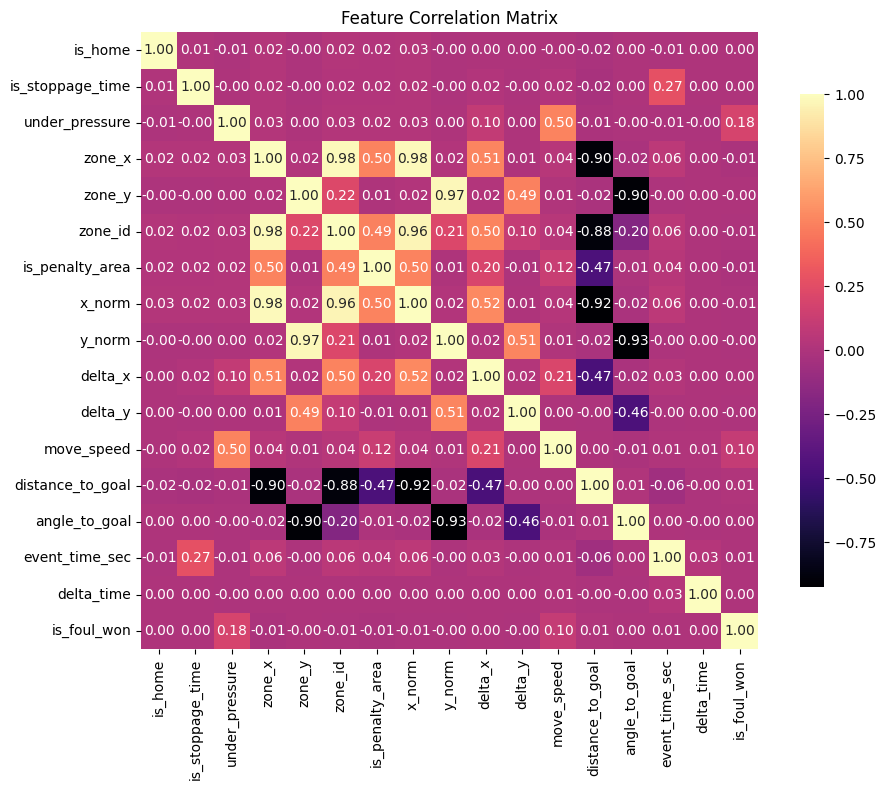

In [136]:
# feature correlation with foul won event
corr_features = [
    'is_home', 'is_stoppage_time', 'under_pressure'
    , 'zone_x', 'zone_y', 'zone_id'
    , 'is_penalty_area', 'x_norm', 'y_norm', 'delta_x', 'delta_y'
    , 'move_speed', 'distance_to_goal', 'angle_to_goal', 'event_time_sec'
    , 'delta_time'
] + ['is_foul_won']

corr_df = model_df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="magma",
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

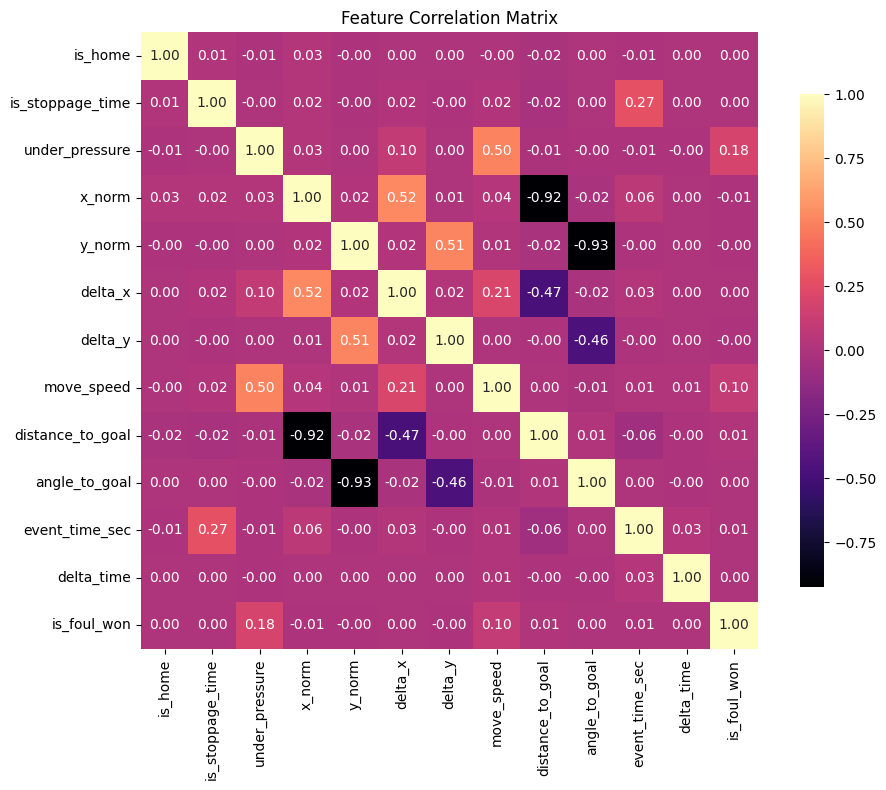

In [137]:
# drop features to reduce redundancy

features_to_drop = [
    "zone_id",
    "zone_x",
    "zone_y",
    "is_penalty_area"
]

corr_df = model_df[[f for f in corr_features if f not in features_to_drop]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="magma",
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [37]:
model_df['is_home'].value_counts()

is_home
1    196970
0    182121
Name: count, dtype: int64

In [245]:
model_df_reduced = model_df.drop(columns=features_to_drop)

## Train-test split based on match week

In [246]:
cutoff = model_df_reduced['match_week'].quantile(0.8)
train_df = model_df_reduced[model_df_reduced['match_week'] <= cutoff].copy()
test_df  = model_df_reduced[model_df_reduced['match_week']  > cutoff].copy()

train_df.shape, test_df.shape

((308956, 45), (70135, 45))

In [247]:
train_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.992329
1    0.007671
Name: proportion, dtype: float64

In [248]:
test_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.992614
1    0.007386
Name: proportion, dtype: float64

In [249]:
# label is very imbalanced, downsample class 0 

pos_df = train_df[train_df['is_foul_won'] == 1]
neg_df = train_df[train_df['is_foul_won'] == 0]

# foul won is still a rare event, downsampling to have class1% = 0.03
class1_prop = 0.03
class0_prop = int(len(pos_df)/class1_prop)
neg_sample = neg_df.sample(n=class0_prop, random_state=42)
train_df_bal = pd.concat([pos_df, neg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [250]:
train_df_bal.shape, train_df_bal.is_foul_won.value_counts(normalize=True)

((81370, 45),
 is_foul_won
 0    0.970874
 1    0.029126
 Name: proportion, dtype: float64)

In [251]:
# label is very imbalanced, downsample class 0 

pos_df = test_df[test_df['is_foul_won'] == 1]
neg_df = test_df[test_df['is_foul_won'] == 0]

# foul won is still a rare event, downsampling to have class1% = 0.03
class1_prop = 0.03
class0_prop = int(len(pos_df)/class1_prop)
neg_sample = neg_df.sample(n=class0_prop, random_state=42)
test_df_bal = pd.concat([pos_df, neg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [252]:
test_df_bal.shape, test_df_bal.is_foul_won.value_counts(normalize=True)

((17784, 45),
 is_foul_won
 0    0.970873
 1    0.029127
 Name: proportion, dtype: float64)

In [253]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# train features
train_features = [
    'under_pressure', 'is_home', 'is_stoppage_time', 'side_of_pitch'
    , 'x_norm', 'y_norm', 'delta_x', 'delta_y', 'move_speed', 'distance_to_goal'
    , 'angle_to_goal', 'event_time_sec'
    , 'delta_time'
]

NUM = [
    'x_norm', 'y_norm', 'delta_x', 'delta_y'
    , 'move_speed', 'distance_to_goal', 'angle_to_goal', 'event_time_sec'
    , 'delta_time'
]
CAT = ['side_of_pitch']
BIN = ['is_home','is_stoppage_time', 'under_pressure']

# Numeric
X_num_train = train_df_bal[NUM]

# Categorical → one‑hot
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_cat_train = ohe.fit_transform(train_df_bal[CAT])

# Combine numeric, cat, binary
X_train = np.hstack([X_num_train, X_cat_train, train_df_bal[BIN].astype(int).values])

# Scale numeric portion
scaler = StandardScaler()
X_train[:, :len(NUM)] = scaler.fit_transform(X_train[:, :len(NUM)])

In [254]:
y_train = train_df_bal['is_foul_won'].to_numpy()

In [255]:
# transformations to test set

X_num_test  = test_df_bal[NUM]
X_cat_test  = ohe.transform(test_df_bal[CAT])
X_test  = np.hstack([X_num_test,  X_cat_test,  test_df_bal[BIN].values])
X_test[:,  :len(NUM)] = scaler.transform(X_test[:, :len(NUM)])
y_test = test_df_bal['is_foul_won'].to_numpy()

## Logistic Regression

In [149]:
# train a logit model as baseline

clf = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [150]:
p_train = clf.predict_proba(X_train)[:,1]
p_test  = clf.predict_proba(X_test)[:,1]

print(f"TRAIN ROC‑AUC: {roc_auc_score(y_train, p_train):.4f}, TEST ROC-AUC: {roc_auc_score(y_test,  p_test):.4f}")
print(f"TRAIN PR‑AUC: {average_precision_score(y_train, p_train):.4f}, TEST PR-AUC: {average_precision_score(y_test,  p_test):.4f}")
print(f"TRAIN log‑loss: {log_loss(y_train, p_train):.4f}, TEST  log‑loss: {log_loss(y_test,  p_test):.4f}")

TRAIN ROC‑AUC: 0.8555, TEST ROC-AUC: 0.8325
TRAIN PR‑AUC: 0.1618, TEST PR-AUC: 0.1417
TRAIN log‑loss: 0.4477, TEST  log‑loss: 0.4574


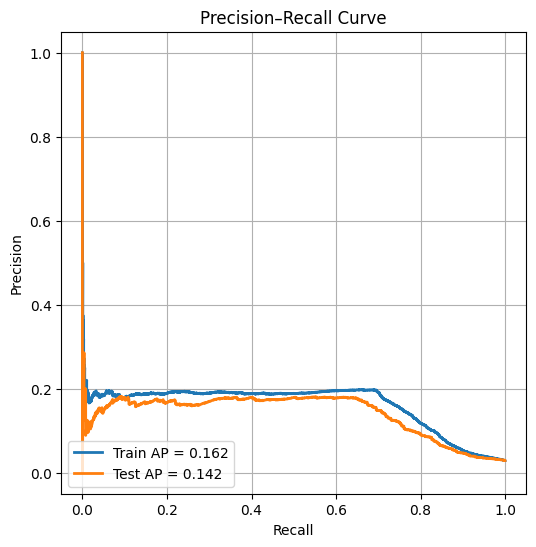

In [151]:
plt.figure(figsize=(6, 6))

#train
precision, recall, thresholds = precision_recall_curve(y_train, p_train)
avg_prec = average_precision_score(y_train, p_train)
plt.plot(recall, precision, lw=2, label=f'Train AP = {avg_prec:.3f}')

#test
precision, recall, thresholds = precision_recall_curve(y_test, p_test)
avg_prec = average_precision_score(y_test, p_test)
plt.plot(recall, precision, lw=2, label=f'Test AP = {avg_prec:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [154]:
features

['under_pressure',
 'is_home',
 'is_stoppage_time',
 'side_of_pitch',
 'x_norm',
 'y_norm',
 'delta_x',
 'delta_y',
 'move_speed',
 'distance_to_goal',
 'angle_to_goal',
 'event_time_sec',
 'delta_time',
 'side_of_pitch_Left',
 'side_of_pitch_Right']

In [155]:
features = NUM + BIN + list(ohe.get_feature_names_out())

# Extract coefficients
coef = clf.coef_[0]  # For binary classification, clf.coef_ is shape (1, n_features)

# Create a dataframe for easier viewing
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': coef
}).sort_values(by='coefficient', ascending=False)

print(coef_df)

                feature  coefficient
13  side_of_pitch_Right     2.723753
9               is_home     0.576831
4            move_speed     0.415487
10     is_stoppage_time     0.338845
1                y_norm     0.221573
11       under_pressure     0.213136
2               delta_x     0.159955
7        event_time_sec     0.082957
6         angle_to_goal     0.040997
8            delta_time     0.025604
3               delta_y    -0.058675
12   side_of_pitch_Left    -0.136354
5      distance_to_goal    -0.605353
0                x_norm    -0.821784


With just the game-state & spatio-temporal features, the baseline logistic model can fairly distinguish between events that end up with a foul-won and those that don't evident by the AUC-ROC of 0.8325. The minimal difference between the train and test AUC-ROC suggests the model is only mildly overfitting. 

Due to the imbalance in the target feature, AUC-ROC doesn't reflect our model's true performance. The precision recall curve is more indicative of how good our model is at identifying foul won cases. Our model has low precision from the start. As the model classifies more events, our precision increases, but it is still poor. The data limitations handicaps the model. 

Log-loss of 0.4611 displays a poor calibration of the model probability output. Isotonic Regression can be applied post training to achieve better calibrated probabilities. 

The feature coefficients indicate that being on the right side of the pitch strongly increases the odds of drawing a foul. Home players are also more likely to win a foul, which is a well known fact. Faster movement speeds intice defenders to commit fouls. Fouls also occur more in the stoppage time compared to rest of the game. Being under pressure means other players are close to the on-ball player and will certainly lead to more fouls. Being closer to the opponent's goal means the midfielders & defenders step up more often to win the ball. The location features indicates the other teams pressing style, negative `x_norm` and positive `y_norm` indicating that on-the-ball players are more likely to win a foul if they are in the midfield or attacking zones.

## Random Forest Classifier

In [256]:
def objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_leaf=int(params['min_samples_leaf']),
        class_weight=params['class_weight'],
        criterion='entropy',
        random_state=42, n_jobs=-1
    )

    # Use cross_val_predict to get probabilities for PR-AUC
    y_probs = cross_val_predict(model, X_train, y_train, cv=5,
                                method='predict_proba', n_jobs=-1)[:, 1]

    pr_auc = average_precision_score(y_train, y_probs)

    return {
        'loss': -pr_auc,   # hyperopt minimizes, so negate the PR AUC
        'status': STATUS_OK,
        'pr_auc': pr_auc
    }

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 500, 10)),
    'max_depth': hp.choice('max_depth', range(3, 20)),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 3, 40),
    'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample'])
}

trials = Trials()
best = fmin(
    fn=objective, 
    space=space, 
    algo=tpe.suggest, 
    max_evals=50, 
    trials=trials
)

print("Best hyperparameters:", best)

100%|████████| 50/50 [12:36<00:00, 15.14s/trial, best loss: -0.2000437557254619]
Best hyperparameters: {'class_weight': np.int64(0), 'max_depth': np.int64(6), 'min_samples_leaf': np.float64(17.90605299505488), 'n_estimators': np.int64(11)}


In [257]:
rf = RandomForestClassifier(
    n_estimators=11,
    max_depth=6,
    min_samples_leaf=17,
    class_weight=None,
    criterion='entropy',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_leaf=17,
                       n_estimators=11, n_jobs=-1, random_state=42)

In [258]:
p_train = rf.predict_proba(X_train)[:,1]
p_test  = rf.predict_proba(X_test)[:,1]

print(f"TRAIN ROC‑AUC: {roc_auc_score(y_train, p_train):.4f}, TEST ROC-AUC: {roc_auc_score(y_test,  p_test):.4f}")
print(f"TRAIN PR‑AUC: {average_precision_score(y_train, p_train):.4f}, TEST PR-AUC: {average_precision_score(y_test,  p_test):.4f}")
print(f"TRAIN log‑loss: {log_loss(y_train, p_train):.4f}, TEST  log‑loss: {log_loss(y_test,  p_test):.4f}")

TRAIN ROC‑AUC: 0.8987, TEST ROC-AUC: 0.8640
TRAIN PR‑AUC: 0.2360, TEST PR-AUC: 0.1740
TRAIN log‑loss: 0.0935, TEST  log‑loss: 0.1002


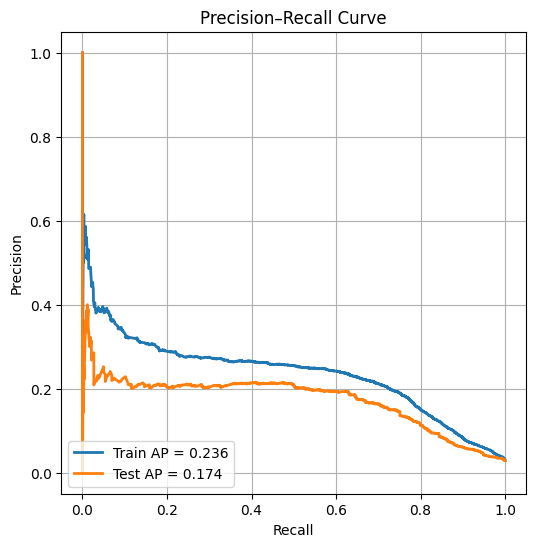

In [259]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(6, 6))

#train
precision, recall, thresholds = precision_recall_curve(y_train, p_train)
avg_prec = average_precision_score(y_train, p_train)
plt.plot(recall, precision, lw=2, label=f'Train AP = {avg_prec:.3f}')

#test
precision, recall, thresholds = precision_recall_curve(y_test, p_test)
avg_prec = average_precision_score(y_test, p_test)
plt.plot(recall, precision, lw=2, label=f'Test AP = {avg_prec:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Top features by importance:
side_of_pitch_Right    0.450285
delta_time             0.183728
move_speed             0.145344
delta_y                0.086814
delta_x                0.050721
x_norm                 0.026868
angle_to_goal          0.016817
distance_to_goal       0.015874
y_norm                 0.009168
event_time_sec         0.008683
is_stoppage_time       0.002314
is_home                0.001655
under_pressure         0.001249
side_of_pitch_Left     0.000482
dtype: float64


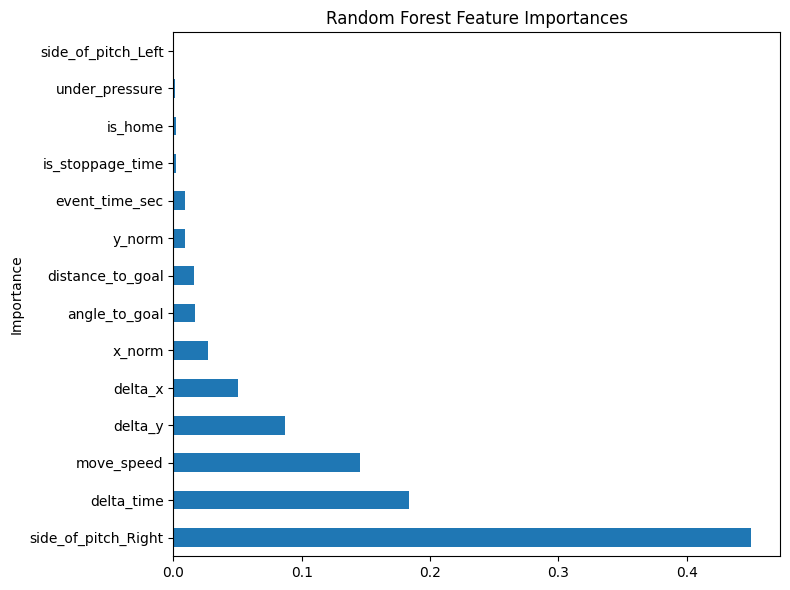

In [261]:
importances = rf.feature_importances_

features = NUM + BIN + list(ohe.get_feature_names_out())

feat_imp = pd.Series(importances, index=features)

feat_imp = feat_imp.sort_values(ascending=False)

print("Top features by importance:")
print(feat_imp.head(20))

plt.figure(figsize=(8,6))
feat_imp.head(20).plot.barh()
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

------------------------------------

| Metric              | Logistic Regression | Random Forest    |
|---------------------|---------------------|------------------|
| **Train ROC‑AUC**   | 0.8555              | **0.8987**       |
| **Test ROC‑AUC**    | 0.8325              | **0.8640**       |
| **Train PR‑AUC**    | 0.1618              | **0.2360**       |
| **Test PR‑AUC**     | 0.1417              | **0.1740**       |
| **Train Log‑Loss**  | 0.4477              | **0.0935**       |
| **Test Log‑Loss**   | 0.4574              | **0.1002**       |

- **Random Forest** captures non-linear interactions better and performs more robustly across both ROC-AUC and PR-AUC.
- The **improvement in PR-AUC** reflects its advantage in handling class imbalance.
- **Lower log-loss** indicates better probability calibration and confidence in predictions.

-------------------------------------
**Next Steps**

The fact is our model doesn't have enough data to learn the patterns of what is essentially a very contextual target. We will now focus on adding this context into the model : *team play style, player play style & how the team played before the first touch event*

In [262]:
# clean up memory

del train_df
del test_df
del train_df_bal
del test_df_bal
del events_df
del model_df
del model_df_reduced

# Team Embedding Construction

**Overview**

The compute_team_embeddings method builds team-level feature vectors that capture a team’s typical behavior based on past matches. These embeddings summarize different aspects of a team’s playing style and tactical tendencies, which can be leveraged as contextual features when predicting player-level foul won probability.

Context Groups : 

- Defensive Context: Fouls, tackles, pressures, and blocks.

- Pressing Context: PPDA (Passes Per Defensive Action) and spatial pressing behavior.

- Possession Context: Tempo, counterattacking frequency, possession durations.

- Attacking Context: Dribble and pass profiles.

- Foul Context: Fouls relative to game state (leading/trailing), referee interaction tendencies.


-------------------------


In [309]:
events_df = pd.read_csv("processed_data/clean_events_w_engineered_feats.csv")

In [310]:
matches_df = pd.read_csv("epl_matches_15.csv")

In [159]:
def parse_timestamp(ts):
    # '00:32:18.937' → seconds
    if isinstance(ts, str):
        t = pd.to_timedelta("00:" + ts.split(":")[-2] + ":" + ts.split(":")[-1])
        return t.total_seconds()
    return None

def parse_location(loc):
    if isinstance(loc, str):
        location_split = str(loc).split(",")
        x, y = float(location_split[0]), float(location_split[1])
        return [x, y]
    return [None, None]
    
def build_team_match_base(match_df, min_history=5):
    """
        For each team, select its first `min_history` matches (home or away) in chronological order.
    
        Parameters
        ----------
        match_df : pandas.DataFrame
        min_history : int, optional
            Number of past matches to include per team (default is 5). 3 home matches, 2 away matches
    
        Returns
        -------
        tuple:
            - dict mapping team_id → list of selected match_ids
            - set of all selected match_ids
    """
    match_df = match_df.sort_values("match_date").reset_index(drop=True)
    # get first N matches per team
    knowledge_base_team_matches = {
        team: list() for team in match_df['home_team.home_team_id'].unique()
    }
    knowledge_base_match_ids = set()
    team_cols = ["home_team.home_team_id","away_team.away_team_id"]
    for team in knowledge_base_team_matches:
        # 3 home matches + 2 away matches = 5 total matches per team
        home_matches = match_df[match_df["home_team.home_team_id"] == team]
        away_matches = match_df[match_df["away_team.away_team_id"] == team]
        team_matches = pd.concat([home_matches, away_matches])
        team_matches = team_matches.sort_values("match_date").head(min_history)
        match_ids = team_matches["match_id"].tolist()
        knowledge_base_team_matches[team] = match_ids
        knowledge_base_match_ids.update(match_ids)
    return knowledge_base_team_matches, knowledge_base_match_ids

def get_x(loc):
    if isinstance(loc, str):
        return float(loc.split(",")[0])
    return None
    
def build_defensive_context(team_events, N=5):
    """
        Compute aggregate defensive metrics for a team over N matches.
    
        Parameters
        ----------
        team_events : pandas.DataFrame
        N : int, optional
            
        Returns
        -------
        dict
            Keys include:
            - fouls_committed_per90
            - fouls_won_per90
            - fouls_committed_per_event
            - fouls_committed_per_duel
            - duel_tackle_per90
            - duel_tackle_per_event
            - duel_success_rate
    """
    # Defensive actions by this team
    defensive_actions = team_events[
        team_events["type.name"].isin(
            [
            "foul_committed", "tackle", "interception", "pressure", "block"
            ]
        )
    ]

    fouls_committed = (team_events["type.name"] == "foul_committed").sum()
    fouls_won = (team_events["type.name"] == "foul_won").sum()
    
    duel_tackle_counts = team_events["type.name"].isin(["duel", "tackle"]).sum()
    duel_success = len(team_events[
        (team_events["type.name"] == "duel") 
        & (team_events["duel.outcome.name"].isin(["Success In Play", "Won", "Success Out"]))
    ])

    # minutes played
    match_minutes = team_events.groupby("match_id")["minute"].max().sum()

    # fouls
    fouls_per_90 = fouls_committed / N
    fouls_per_event = fouls_committed / team_events.shape[0]
    fouls_won_per_90 = fouls_won / N
    # duels
    duels_per_90 = duel_tackle_counts / N
    duels_per_event = duel_tackle_counts / team_events.shape[0]
    # foul committed per duel
    fouls_committed_per_duel = (fouls_committed/duel_tackle_counts) if duel_tackle_counts > 0 else 0 

    return {
        "fouls_committed_per90": fouls_per_90,
        "fouls_won_per90": fouls_won_per_90,
        "fouls_committed_per_event": fouls_per_event,
        "fouls_committed_per_duel": fouls_committed_per_duel,
        "duel_tackle_per90": duels_per_90,
        "duel_tackle_per_event": duels_per_event,
        "duel_success_rate": duel_success / duel_tackle_counts if duel_tackle_counts > 0 else 0
    }

def build_pressing_context(team_events, opponent_events, N=5):
    """
        Compute pressing and defensive intensity metrics over N matches.
    
        Parameters
        ----------
        team_events : pandas.DataFrame
        opponent_events : pandas.DataFrame
        N : int, optional
    
        Returns
        -------
        dict
            - num_opponent_passes: int, total opponent passes faced
            - num_defensive_actions: int, total defensive actions taken
            - ppda: float or None, passes allowed per defensive action
            - def_action_centroid_x: float or None, mean X location of defensive actions
            - percent_def_actions_att_third: float or None, fraction of actions in attacking third
    """
    # passess by oppponent
    opponent_passes = opponent_events[opponent_events["type.name"] == "pass"]
    defensive_actions = team_events[
        team_events["type.name"].isin(
            [
                "foul_committed", "tackle", "interception", "pressure", "block"
            ]
        )
    ]
    # passes allowed per defensive action - PPDA
    num_defensive_actions = len(defensive_actions)
    num_opp_passes = len(opponent_passes)
    ppda = num_opp_passes / num_defensive_actions if num_defensive_actions > 0 else None

    # Defensive action centroid (mean x)
    defensive_x = defensive_actions["location"].dropna().apply(get_x)
    defensive_centroid_x = defensive_x.mean() if not defensive_x.empty else None

    # Proportion of defensive actions in attacking third
    defensive_in_attacking_third = defensive_x[defensive_x > 66].count()
    prop_attacking_third = defensive_in_attacking_third / num_defensive_actions if num_defensive_actions > 0 else None
    
    return {
        "num_opponent_passes": num_opp_passes,
        "num_defensive_actions": num_defensive_actions,
        "ppda": ppda,
        "def_action_centroid_x": defensive_centroid_x,
        "percent_def_actions_att_third": prop_attacking_third
    }
    
def build_possession_context(team_events):
    """
        Compute average possession stats for a team, including duration,
        direct speed, and counter-attacking behavior.

        Parameters
        ----------
        team_events : pandas.DataFrame
        
        Returns
        -------
        dict
            - avg_possession_duration : float
            - avg_direct_speed : float
            - avg_counters : float
            - num_possessions : int
            - valid_possessions : int
    """
    # Possession based stats
    team_possession_chains = team_events.groupby("possession")
    possession_durations = []
    direct_speeds = []
    counter_flags = []

    for _, possession_chain in team_possession_chains:
        possession_chain = possession_chain.sort_values("index")
        if len(possession_chain) < 2:
            # too short to compute features
            continue
        
        # duration
        parsed_timestamps = possession_chain["timestamp"].apply(parse_timestamp).values
        chain_duration = parsed_timestamps[-1] - parsed_timestamps[0]

        x_start = get_x(possession_chain.iloc[0]["location"])
        x_end = get_x(possession_chain.iloc[-1]["location"])

        if x_start != None and x_end != None and chain_duration > 0:
            x_progress = abs(x_end - x_start)
            direct_speed = x_progress/chain_duration
            direct_speeds.append(direct_speed)

            possession_durations.append(chain_duration)
            # transitioning from own half and quickly
            is_counter = (x_start < 50) and (chain_duration < 10)
            counter_flags.append(is_counter)

    avg_possession_duration = np.mean(possession_durations) if possession_durations else 0
    avg_direct_speed = np.mean(direct_speeds) if direct_speeds else 0
    avg_counters = np.mean(counter_flags) if counter_flags else 0

    return {
        "avg_possession_duration": avg_possession_duration,
        "avg_direct_speed": avg_direct_speed,
        "avg_counters": avg_counters,
        "num_possessions": len(team_possession_chains),
        "valid_possessions": len(possession_durations)                      
    }

def build_attacking_context(team_events, N=5):
    """
        Compute attacking stats for a team, including dribbles, carries,
        and pass length distributions.

        Parameters
        ----------
        team_events : pandas.DataFrame
        N : int, optional (default=5)
    
        Returns
        -------
        dict
            - dribbles_per_90 : float
            - carries_per_90 : float
            - short_pass_prop : float
            - medium_pass_prop : float
            - long_pass_prop : float
            - total_passes : int
    """
    # dribbles
    dribbles = (team_events["type.name"] == "dribble").sum()
    # carries
    carries = (team_events["type.name"] == "carry").sum()
    # passes 
    passes = team_events[team_events["type.name"] == 'pass']
    pass_lengths = passes["pass.length"].dropna()
    short = pass_lengths[pass_lengths < 10].count()
    medium = pass_lengths[(pass_lengths >= 10) & (pass_lengths < 30)].count()
    long = pass_lengths[pass_lengths >= 30].count()
    total_passes = short + medium + long

    dribbles_per_90 = dribbles/N
    carries_per_90 = carries/N
    short_pass_prop = short/total_passes
    medium_pass_prop = medium/total_passes
    long_pass_prop = long/total_passes

    return {
        "dribbles_per_90": dribbles_per_90,
        "carries_per_90": carries_per_90,
        "short_pass_prop": short_pass_prop,
        "medium_pass_prop": medium_pass_prop,
        "long_pass_prop": long_pass_prop,
        "total_passes": total_passes
    }
def build_foul_context(team_events, matches, match_ids, team_id, N=5):
    """
        Compute foul-related contextual features for a team over a set of matches.

        Parameters
        ----------
        team_events : pandas.DataFrame
        matches : pandas.DataFrame
        match_ids : iterable
        team_id : int
        N : int, optional (default=5)
        
        Returns
        -------
        dict
            - home_away_foul_diff : int
            - referee_interaction_index : float
            - fouls_per90_leading : float
            - fouls_per90_trailing : float
    """
    ref_ewma = {}
    home_fouls = 0
    away_fouls = 0

    leading_fouls = 0
    trailing_fouls = 0
    leading_minutes = 0
    trailing_minutes = 0
    
    for match_id in match_ids:
        match = matches[matches["match_id"] == match_id].iloc[0]
        match_events = team_events[team_events["match_id"] == match_id]
        team_side = "home" if match["home_team.home_team_id"] == team_id else "away"
        is_home = team_side == "home"
        referee = match["referee.id"]

        # fouls drawn
        fouls_drawn = match_events[
            (match_events["type.name"] == "foul_won") 
            & (match_events["team.id"] == team_id)
        ].shape[0]
        if is_home:
            home_fouls += fouls_drawn
        else:
            away_fouls += fouls_drawn
        
        # Foul differential: fouls won - fouls committed
        fouls_drawn = match_events[
            (match_events["type.name"] == "foul_won") &
            (match_events["team.id"] == team_id)
        ].shape[0]
        
        fouls_committed = match_events[
            (match_events["type.name"] == "foul_committed") &
            (match_events["team.id"] == team_id)
        ].shape[0]
        
        foul_diff = fouls_drawn - fouls_committed
        
        # EWMA of foul differential per referee
        ewma_alpha = 0.3
        prev_ewma = ref_ewma.get(referee, 0)
        ref_ewma[referee] = ewma_alpha * foul_diff + (1 - ewma_alpha) * prev_ewma

        # Game-state foul stats
        # We use final match score as a proxy since full timeline may not be available
        home_goals = match.get("home_score", 0)
        away_goals = match.get("away_score", 0)

        if is_home:
            # if leading, update leading stats, else trailing stats
            if home_goals > away_goals:
                leading_fouls += fouls_committed
                leading_minutes += 90
            elif home_goals < away_goals:
                trailing_fouls += fouls_committed
                trailing_minutes += 90
        else:
            if away_goals > home_goals:
                leading_fouls += fouls_committed
                leading_minutes += 90
            elif away_goals < home_goals:
                trailing_fouls += fouls_committed
                trailing_minutes += 90
    
    ref_interaction_index = np.mean(list(ref_ewma.values())) if ref_ewma else 0
    foul_diff_home_away = home_fouls - away_fouls
    fouls_per90_leading = leading_fouls / (leading_minutes / 90) if leading_minutes > 0 else 0
    fouls_per90_trailing = trailing_fouls / (trailing_minutes / 90) if trailing_minutes > 0 else 0
    
    return {
        "home_away_foul_diff":foul_diff_home_away,
        "referee_interaction_index":ref_interaction_index,
        "fouls_per90_leading":fouls_per90_leading,
        "fouls_per90_trailing":fouls_per90_trailing
    }

def compute_team_embeddings(
    events_df
    , matches_df
    , event_exclusions=['error', 'starting_xi', 'half_start', 'half_end']
    , min_history=5
):
    """
        Generate team-level embeddings summarizing historical playing styles 
        based on event and match data.
    
        The embedding captures multiple dimensions of team behavior, including
        defensive actions, pressing intensity, possession characteristics,
        attacking tendencies, and foul-related metrics.
    
        Parameters
        ----------
        events_df : pandas.DataFrame
        matches_df : pandas.DataFrame
        event_exclusions : list of str, optional (default=['error', 'starting_xi', 'half_start', 'half_end'])
        min_history : int, optional (default=5)
    
        Returns
        -------
        pandas.DataFrame
            Team embeddings containing engineered features summarizing team behavior.
        set
            Set of match IDs that were used to construct the embeddings (knowledge base).
    """
    from collections import defaultdict
    import numpy as np
    import pandas as pd

    embeddings = []
    events_df['type.name'] = events_df['type.name'].str.lower().str.replace(' ', '_').str.replace('*','').str.strip()
    events_df = events_df.loc[~events_df['type.name'].isin(event_exclusions)]

    team_knowledge_base_matches, knowledge_base_match_ids = build_team_match_base(
        matches_df
        , min_history=min_history
    )
    for team_id, match_ids in team_knowledge_base_matches.items():
        team_events = events_df[
            (events_df["match_id"].isin(match_ids)) &
            (events_df["team.id"] == team_id)
        ]
        # All events where the opponent is involved
        opponent_events = events_df[
            (events_df["match_id"].isin(match_ids)) &
            (events_df["team.id"] != team_id)
        ]
        # Defensive Context
        defensive_context = build_defensive_context(team_events)
        # Pressing Context
        pressing_context = build_pressing_context(team_events, opponent_events)
        # Possession Context
        possession_context = build_possession_context(team_events)
        # Attacking Context
        attacking_context = build_attacking_context(team_events)
        # Foul Context
        foul_context = build_foul_context(team_events, matches_df, match_ids, team_id)

        team_embedding = {
            "team_id": team_id,
            **defensive_context,
            **pressing_context,
            **possession_context,
            **attacking_context,
            **foul_context
        }
        embeddings.append(team_embedding)
    return pd.DataFrame(embeddings), knowledge_base_match_ids


In [311]:
team_embedding_df, exclude_match_ids = compute_team_embeddings(events_df, matches_df)

In [312]:
team_embedding_df.head()

team_id  fouls_committed_per90  fouls_won_per90  fouls_committed_per_event  \
0       33                   14.4             16.6                   0.007884   
1       39                   13.2             12.8                   0.006291   
2       28                   13.4             13.2                   0.007736   
3       29                   10.4             14.8                   0.006230   
4       56                   13.6              9.8                   0.008311   

   fouls_committed_per_duel  duel_tackle_per90  duel_tackle_per_event  \
0                  0.382979               37.6               0.020587   
1                  0.331658               39.8               0.018969   
2                  0.338384               39.6               0.022861   
3                  0.305882               34.0               0.020367   
4                  0.386364               35.2               0.021511   

   duel_success_rate  num_opponent_passes  num_defensive_actions  ...  \
0           0.297872                 2112                    869  ...   
1           0.286432                 2218                    779  ...   
2           0.297980                 2245                    920  ...   
3           0.347059                 2520                    795  ...   
4           0.295455                 2370                    868  ...   

   dribbles_per_90  carries_per_90  short_pass_prop  medium_pass_prop  \
0             16.2           412.4         0.191577          0.617965   
1             14.0           521.2         0.158112          0.648606   
2             19.4           369.8         0.199767          0.595803   
3             17.2           376.0         0.171593          0.610016   
4             18.0           365.2         0.201674          0.586192   

   long_pass_prop  total_passes  home_away_foul_diff  \
0        0.190458          2683                   -7   
1        0.193283          3156                   18   
2        0.204431          2573                    0   
3        0.218391          2436                    8   
4        0.212134          2390                   25   

   referee_interaction_index  fouls_per90_leading  fouls_per90_trailing  
0                     0.6600            14.000000             13.333333  
1                    -0.1200            10.666667             16.000000  
2                    -0.0600            14.000000             14.666667  
3                     1.4925            14.000000              6.000000  
4                    -1.1400            10.000000             15.000000  

[5 rows x 28 columns]

In [313]:
# We will attach the defensive context features to the off the ball team and the attacking context features to the possession team

events_df['opp_team_id'] = np.where(
    events_df['possession_team.id'] == events_df['home_team.home_team_id'],
    events_df['away_team.away_team_id'],
    events_df['home_team.home_team_id']
)

In [314]:
events_df = events_df[['match_id','index', 'opp_team_id']]

In [315]:
# append team embedding onto training df
train_features = [
    'under_pressure', 'is_home', 'is_stoppage_time', 'side_of_pitch'
    , 'x_norm', 'y_norm', 'delta_x', 'delta_y'
    , 'move_speed', 'distance_to_goal', 'angle_to_goal', 'event_time_sec'
    , 'delta_time'
]
model_df = pd.read_csv("processed_data/training_data.csv")
model_df = model_df.loc[
    ~model_df.match_id.isin(exclude_match_ids)
    , ['team.id','match_id','index','is_foul_won', 'possession_team.id','match_week']+train_features
]

In [316]:
model_df.shape

(328788, 19)

In [317]:
model_idxs = model_df['index'].values
model_match_ids = model_df['match_id'].values
first_touch_events = events_df[
    events_df['index'].isin(model_idxs)
    &
    events_df['match_id'].isin(model_match_ids)
]

In [318]:
first_touch_events.head()

match_id  index  opp_team_id
1   3753972      6           28
2   3753972      7           28
3   3753972      8           28
4   3753972      9           28
5   3753972     10           28

In [319]:
first_touch_events = first_touch_events.set_index(['match_id','index'])

In [320]:
model_df_reduced = model_df[['match_id','team.id','index','is_foul_won', 'possession_team.id','match_week']+train_features]
model_df_reduced = model_df_reduced.set_index(['match_id','index'])

In [321]:
model_df_reduced.head()

team.id  is_foul_won  possession_team.id  match_week  \
match_id index                                                         
3753972  6           26            0                  26          13   
         9           26            0                  26          13   
         12          26            0                  26          13   
         15          26            0                  26          13   
         18          26            0                  26          13   

                under_pressure  is_home  is_stoppage_time side_of_pitch  \
match_id index                                                            
3753972  6                   0        1             False        Center   
         9                   1        1             False        Center   
         12                  0        1             False         Right   
         15                  0        1             False        Center   
         18                  0        1             False         Right   

                  x_norm   y_norm   delta_x  delta_y  move_speed  \
match_id index                                                     
3753972  6      0.501667  0.50875 -0.006667  0.00750    0.010035   
         9      0.436667  0.52000 -0.099167  0.00000    0.099167   
         12     0.276667  0.76125 -0.165833  0.23250    0.285582   
         15     0.237500  0.38875 -0.040833 -0.35750    0.359824   
         18     0.223333  0.75250 -0.014167  0.32875    0.329055   

                distance_to_goal  angle_to_goal  event_time_sec  delta_time  
match_id index                                                               
3753972  6              0.498410       0.497206               0    0.000000  
         9              0.563688       0.494352               1    0.000000  
         12             0.769066       0.444838               4    0.033333  
         15             0.770573       0.523058               6    0.016667  
         18             0.816681       0.449973              10    0.033333

In [322]:
first_touch_events = first_touch_events.sort_index()
model_df_reduced = model_df_reduced.sort_index()

In [323]:
model_df_reduced['opp_team_id'] = first_touch_events['opp_team_id']

In [324]:
model_df_reduced = model_df_reduced.reset_index()

In [325]:
poss_team_feats = [
    "team_id"
    , "avg_possession_duration"
    , "avg_direct_speed"
    , "avg_counters"
    , "dribbles_per_90"
    , "carries_per_90"
    , "short_pass_prop"
    , "medium_pass_prop"
    , "long_pass_prop"
    , "total_passes"
    , "ppda"
    , "referee_interaction_index"
    , "fouls_won_per90"
]
column_rename_dict = {
    'team_id': 'team.id'
}
for f in poss_team_feats:
    if f=='team_id':
        continue
    column_rename_dict[f] = f"poss_team_{f}"

poss_team_embedding_df = team_embedding_df[poss_team_feats].rename(columns=column_rename_dict)

In [326]:
def_team_feats = [
    "team_id",
    "ppda",
    "def_action_centroid_x",
    "percent_def_actions_att_third",
    "fouls_committed_per90",
    "fouls_won_per90",
    "fouls_committed_per_event",
    "fouls_committed_per_duel",
    "duel_tackle_per90",
    "duel_tackle_per_event",
    "duel_success_rate",
    "home_away_foul_diff",
    "referee_interaction_index",
    "fouls_per90_leading",
    "fouls_per90_trailing"
]
column_rename_dict = {
    'team_id': 'opp_team_id'
}
for f in def_team_feats:
    if f=='team_id':
        continue
    column_rename_dict[f] = f"def_team_{f}"
    
def_team_embedding_df = team_embedding_df[def_team_feats].rename(columns=column_rename_dict)

In [327]:
## append team embedding onto training df

model_df_reduced = model_df_reduced.merge(
    poss_team_embedding_df
    , on='team.id'
    , how='left'
)

model_df_reduced = model_df_reduced.merge(
    def_team_embedding_df
    , on='opp_team_id'
    , how='left'
)

## Train Test Split

In [203]:
cutoff = model_df_reduced['match_week'].quantile(0.8)
train_df = model_df_reduced[model_df_reduced['match_week'] <= cutoff].copy()
test_df  = model_df_reduced[model_df_reduced['match_week']  > cutoff].copy()

train_df.shape, test_df.shape

((268935, 44), (59853, 44))

In [204]:
train_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.992329
1    0.007671
Name: proportion, dtype: float64

In [205]:
test_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.992632
1    0.007368
Name: proportion, dtype: float64

In [206]:
# label is very imbalanced, downsample class 0 

pos_df = train_df[train_df['is_foul_won'] == 1]
neg_df = train_df[train_df['is_foul_won'] == 0]

# foul won is still a rare event, downsampling to have class1% = 0.03
class1_prop = 0.03
class0_prop = int(len(pos_df)/class1_prop)
neg_sample = neg_df.sample(n=class0_prop, random_state=42)
train_df_bal = pd.concat([pos_df, neg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [207]:
train_df_bal.shape, train_df_bal.is_foul_won.value_counts(normalize=True)

((70829, 44),
 is_foul_won
 0    0.970874
 1    0.029126
 Name: proportion, dtype: float64)

In [208]:
# label is very imbalanced, downsample class 0 

pos_df = test_df[test_df['is_foul_won'] == 1]
neg_df = test_df[test_df['is_foul_won'] == 0]

# foul won is still a rare event, downsampling to have class1% = 0.03
class1_prop = 0.03
class0_prop = int(len(pos_df)/class1_prop)
neg_sample = neg_df.sample(n=class0_prop, random_state=42)
test_df_bal = pd.concat([pos_df, neg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [209]:
test_df_bal.shape, test_df_bal.is_foul_won.value_counts(normalize=True)

((15141, 44),
 is_foul_won
 0    0.970874
 1    0.029126
 Name: proportion, dtype: float64)

In [213]:
train_df_bal.columns

Index(['team.id', 'is_foul_won', 'possession_team.id', 'match_week',
       'under_pressure', 'is_home', 'is_stoppage_time', 'side_of_pitch',
       'x_norm', 'y_norm', 'delta_x', 'delta_y', 'move_speed',
       'distance_to_goal', 'angle_to_goal', 'event_time_sec', 'delta_time',
       'opp_team_id', 'poss_team_avg_possession_duration',
       'poss_team_avg_direct_speed', 'poss_team_avg_counters',
       'poss_team_dribbles_per_90', 'poss_team_carries_per_90',
       'poss_team_short_pass_prop', 'poss_team_medium_pass_prop',
       'poss_team_long_pass_prop', 'poss_team_total_passes', 'poss_team_ppda',
       'poss_team_referee_interaction_index', 'poss_team_fouls_won_per90',
       'def_team_ppda', 'def_team_def_action_centroid_x',
       'def_team_percent_def_actions_att_third',
       'def_team_fouls_committed_per90', 'def_team_fouls_won_per90',
       'def_team_fouls_committed_per_event',
       'def_team_fouls_committed_per_duel', 'def_team_duel_tackle_per90',
       'def_team_d

In [211]:
len(test_df_bal.columns)

44

In [192]:
# train features
train_features = [
    'under_pressure', 'is_home', 'is_stoppage_time', 'side_of_pitch'
    , 'x_norm', 'y_norm', 'delta_x', 'delta_y'
    , 'move_speed', 'distance_to_goal', 'angle_to_goal', 'event_time_sec'
    , 'delta_time'
] + [f for f in poss_team_embedding_df if f != 'team.id'] + [f for f in def_team_embedding_df if f!= 'opp_team_id']
train_features

['under_pressure',
 'is_home',
 'is_stoppage_time',
 'side_of_pitch',
 'x_norm',
 'y_norm',
 'delta_x',
 'delta_y',
 'move_speed',
 'distance_to_goal',
 'angle_to_goal',
 'event_time_sec',
 'delta_time',
 'poss_team_avg_possession_duration',
 'poss_team_avg_direct_speed',
 'poss_team_avg_counters',
 'poss_team_dribbles_per_90',
 'poss_team_carries_per_90',
 'poss_team_short_pass_prop',
 'poss_team_medium_pass_prop',
 'poss_team_long_pass_prop',
 'poss_team_total_passes',
 'poss_team_ppda',
 'poss_team_referee_interaction_index',
 'poss_team_fouls_won_per90',
 'def_team_ppda',
 'def_team_def_action_centroid_x',
 'def_team_percent_def_actions_att_third',
 'def_team_fouls_committed_per90',
 'def_team_fouls_won_per90',
 'def_team_fouls_committed_per_event',
 'def_team_fouls_committed_per_duel',
 'def_team_duel_tackle_per90',
 'def_team_duel_tackle_per_event',
 'def_team_duel_success_rate',
 'def_team_home_away_foul_diff',
 'def_team_referee_interaction_index',
 'def_team_fouls_per90_leadin

In [214]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

NUM = [
    'x_norm', 'y_norm', 'delta_x', 'delta_y',
    'move_speed', 'distance_to_goal', 'angle_to_goal',
    'event_time_sec', 'delta_time',
    'poss_team_avg_possession_duration',
    'poss_team_avg_direct_speed', 'poss_team_avg_counters',
    'poss_team_dribbles_per_90', 'poss_team_carries_per_90',
    'poss_team_short_pass_prop', 'poss_team_medium_pass_prop',
    'poss_team_long_pass_prop', 'poss_team_total_passes', 'poss_team_ppda',
    'poss_team_referee_interaction_index', 'poss_team_fouls_won_per90',
    'def_team_ppda', 'def_team_def_action_centroid_x',
    'def_team_percent_def_actions_att_third',
    'def_team_fouls_committed_per90', 'def_team_fouls_won_per90',
    'def_team_fouls_committed_per_event',
    'def_team_fouls_committed_per_duel', 'def_team_duel_tackle_per90',
    'def_team_duel_tackle_per_event', 'def_team_duel_success_rate',
    'def_team_home_away_foul_diff', 'def_team_referee_interaction_index',
    'def_team_fouls_per90_leading', 'def_team_fouls_per90_trailing'
]

CAT = ['side_of_pitch']
BIN = ['is_home','is_stoppage_time', 'under_pressure']

# Numeric
X_num_train = train_df_bal[NUM]

# Categorical → one‑hot
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_cat_train = ohe.fit_transform(train_df_bal[CAT])

# Combine numeric, cat, binary
X_train = np.hstack([X_num_train, X_cat_train, train_df_bal[BIN].astype(int).values])

# Scale numeric portion
scaler = StandardScaler()
X_train[:, :len(NUM)] = scaler.fit_transform(X_train[:, :len(NUM)])

In [215]:
y_train = train_df_bal['is_foul_won'].to_numpy()

In [216]:
# transformations to sampled test set

X_num_test  = test_df_bal[NUM]
X_cat_test  = ohe.transform(test_df_bal[CAT])
X_test  = np.hstack([X_num_test,  X_cat_test,  test_df_bal[BIN].values])
X_test[:,  :len(NUM)] = scaler.transform(X_test[:, :len(NUM)])
y_test = test_df_bal['is_foul_won'].to_numpy()

## Logistic Regression

In [240]:
from sklearn.linear_model import LogisticRegression

# train a logit model as baseline
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [225]:
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, classification_report

p_train = clf.predict_proba(X_train)[:,1]
p_test  = clf.predict_proba(X_test)[:,1]

print(f"TRAIN ROC‑AUC: {roc_auc_score(y_train, p_train):.4f}, TEST ROC-AUC: {roc_auc_score(y_test,  p_test):.4f}")
print(f"TRAIN PR‑AUC: {average_precision_score(y_train, p_train):.4f}, TEST PR-AUC: {average_precision_score(y_test,  p_test):.4f}")
print(f"TRAIN log‑loss: {log_loss(y_train, p_train):.4f}, TEST  log‑loss: {log_loss(y_test,  p_test):.4f}")

TRAIN ROC‑AUC: 0.8494, TEST ROC-AUC: 0.8330
TRAIN PR‑AUC: 0.1827, TEST PR-AUC: 0.1555
TRAIN log‑loss: 0.1003, TEST  log‑loss: 0.1038


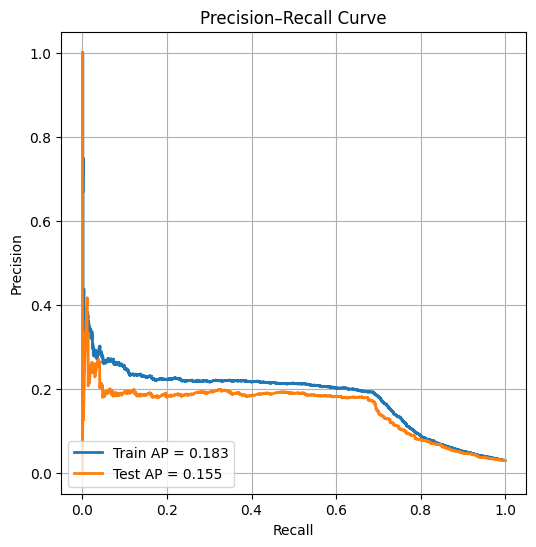

In [226]:
plt.figure(figsize=(6, 6))

#train
precision, recall, thresholds = precision_recall_curve(y_train, p_train)
avg_prec = average_precision_score(y_train, p_train)
plt.plot(recall, precision, lw=2, label=f'Train AP = {avg_prec:.3f}')

#test
precision, recall, thresholds = precision_recall_curve(y_test, p_test)
avg_prec = average_precision_score(y_test, p_test)
plt.plot(recall, precision, lw=2, label=f'Test AP = {avg_prec:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [227]:
features = NUM + BIN + list(ohe.get_feature_names_out())

# Extract coefficients
coef = clf.coef_[0]  # For binary classification, clf.coef_ is shape (1, n_features)

# Create a dataframe for easier viewing
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': coef
}).sort_values(by='coefficient', ascending=False)

print(coef_df)

                                   feature  coefficient
39                     side_of_pitch_Right     2.850616
35                                 is_home     0.429427
22          def_team_def_action_centroid_x     0.354771
36                        is_stoppage_time     0.349425
28              def_team_duel_tackle_per90     0.243909
1                                   y_norm     0.191718
4                               move_speed     0.189064
37                          under_pressure     0.182830
21                           def_team_ppda     0.121751
19     poss_team_referee_interaction_index     0.100081
17                  poss_team_total_passes     0.095064
6                            angle_to_goal     0.077098
16                poss_team_long_pass_prop     0.071096
7                           event_time_sec     0.065869
24          def_team_fouls_committed_per90     0.063174
27       def_team_fouls_committed_per_duel     0.059992
8                               delta_time     0

## Random Forest Classifier

In [230]:
def objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_leaf=int(params['min_samples_leaf']),
        class_weight=params['class_weight'],
        criterion='entropy',
        random_state=42, n_jobs=-1
    )

    # Use cross_val_predict to get probabilities for PR-AUC
    y_probs = cross_val_predict(model, X_train, y_train, cv=5,
                                method='predict_proba', n_jobs=-1)[:, 1]

    pr_auc = average_precision_score(y_train, y_probs)

    return {
        'loss': -pr_auc,   # hyperopt minimizes, so negate the PR AUC
        'status': STATUS_OK,
        'pr_auc': pr_auc
    }

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 500, 10)),
    'max_depth': hp.choice('max_depth', range(3, 20)),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 3, 40),
    'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample'])
}

trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=50, 
            trials=trials)

print("Best hyperparameters:", best)

100%|████████| 50/50 [13:17<00:00, 15.95s/trial, best loss: -0.1970355190094224]
Best hyperparameters: {'class_weight': np.int64(0), 'max_depth': np.int64(6), 'min_samples_leaf': np.float64(6.11894397974666), 'n_estimators': np.int64(31)}


In [233]:
space['n_estimators']

In [234]:
rf = RandomForestClassifier(
    n_estimators=31,
    max_depth=6,
    min_samples_leaf=6,
    class_weight=None,
    criterion='entropy',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_leaf=6,
                       n_estimators=31, n_jobs=-1, random_state=42)

In [235]:
p_train = rf.predict_proba(X_train)[:,1]
p_test  = rf.predict_proba(X_test)[:,1]

print(f"TRAIN ROC‑AUC: {roc_auc_score(y_train, p_train):.4f}, TEST ROC-AUC: {roc_auc_score(y_test,  p_test):.4f}")
print(f"TRAIN PR‑AUC: {average_precision_score(y_train, p_train):.4f}, TEST PR-AUC: {average_precision_score(y_test,  p_test):.4f}")
print(f"TRAIN log‑loss: {log_loss(y_train, p_train):.4f}, TEST  log‑loss: {log_loss(y_test,  p_test):.4f}")

TRAIN ROC‑AUC: 0.8944, TEST ROC-AUC: 0.8559
TRAIN PR‑AUC: 0.2712, TEST PR-AUC: 0.1769
TRAIN log‑loss: 0.0950, TEST  log‑loss: 0.1008


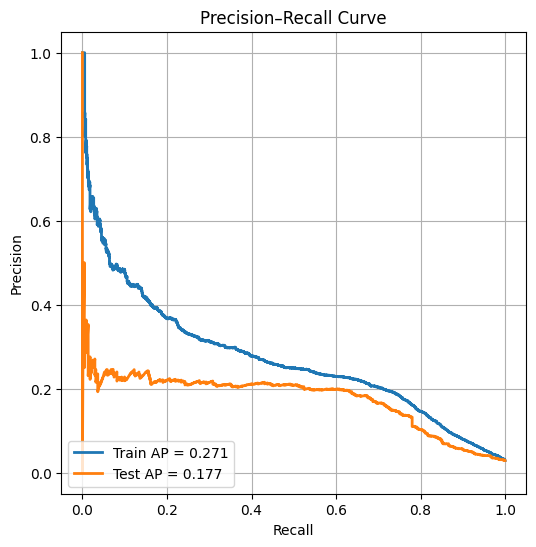

In [236]:
plt.figure(figsize=(6, 6))

#train
precision, recall, thresholds = precision_recall_curve(y_train, p_train)
avg_prec = average_precision_score(y_train, p_train)
plt.plot(recall, precision, lw=2, label=f'Train AP = {avg_prec:.3f}')

#test
precision, recall, thresholds = precision_recall_curve(y_test, p_test)
avg_prec = average_precision_score(y_test, p_test)
plt.plot(recall, precision, lw=2, label=f'Test AP = {avg_prec:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Top 20 features by importance:
side_of_pitch_Right                  0.454350
move_speed                           0.180796
delta_time                           0.109319
delta_y                              0.065259
delta_x                              0.062075
distance_to_goal                     0.024684
x_norm                               0.022918
y_norm                               0.011605
angle_to_goal                        0.011161
event_time_sec                       0.007067
poss_team_total_passes               0.002947
poss_team_avg_possession_duration    0.002835
poss_team_medium_pass_prop           0.002643
def_team_def_action_centroid_x       0.002543
def_team_duel_success_rate           0.002142
poss_team_dribbles_per_90            0.002126
poss_team_carries_per_90             0.002107
def_team_fouls_committed_per90       0.002091
def_team_fouls_per90_trailing        0.002027
is_home                              0.001937
dtype: float64


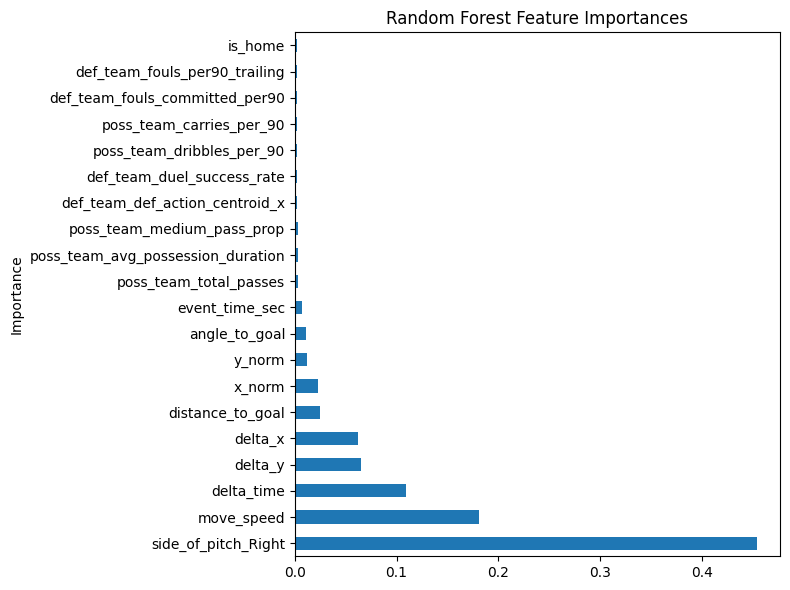

In [239]:
importances = rf.feature_importances_

features = NUM + BIN + list(ohe.get_feature_names_out())
feat_imp = pd.Series(importances, index=features)

feat_imp = feat_imp.sort_values(ascending=False)


print("Top 20 features by importance:")
print(feat_imp.head(20))

plt.figure(figsize=(8,6))
feat_imp.head(20).plot.barh()
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

--------------------------------------------

| Metric                  | Logistic Regression       | Random Forest            |
|-------------------------|---------------------------|--------------------------|
| **Train ROC-AUC**       | 0.8494                    | **0.8944**               |
| **Test ROC-AUC**        | 0.8330                    | **0.8559**               |
| **Train PR-AUC**        | 0.1827                    | **0.2712**               |
| **Test PR-AUC**         | 0.1555                    | **0.1769**               |
| **Train Log-Loss**      | 0.1003                    | **0.0950**               |
| **Test Log-Loss**       | 0.1038                    | **0.1008**               |


Random Forest (RF) shows stronger performance across all the three metrics suggesting its better able to capture the non-linear features. We also see that RF Classifier is overfitting more than the Logistic Regression.

Feature coefficients from LR and importances from RF agree that the right side of the pitch is a big contributor to winning a foul. This might 

---------------------------------------

## Checkpoint

In [328]:
model_df_reduced.to_csv("processed_data/train_data_w_team_embeddings.csv")

In [329]:
del model_df
del model_df_reduced
del train_df
del train_df_bal
del test_df
del test_df_bal

# $N$ - Sequence Context

In [330]:
events_df = pd.read_csv("processed_data/clean_events_w_engineered_feats.csv")

In [331]:
model_df = pd.read_csv("processed_data/train_data_w_team_embeddings.csv")

In [332]:
matches_df = pd.read_csv("epl_matches_15.csv")

The paper [Seq2Event](https://eprints.soton.ac.uk/458099/1/KDD22_paper_CReady_v20220606.pdf) found that sequence lengths of 40-100 gave the best results. 
~For our ease, we will select 40 events as the look-back period~ Turns out that's too many events for Macbook Air with 8gb RAM to process, selecting $N=20$

In [333]:
class EventMarkovModel:
    """
        A first-order Markov model for sequential event data.
    
        This model learns transition probabilities between events based on observed sequences,
        and allows for probability estimation, lift calculation against a baseline model, and
        scoring of new sequences based on learned transition dynamics.
    
        Attributes
        ----------
        sequences : list of list
            List of event sequences, where each sequence is a list of event names (strings).
        transition_counts : dict
            Nested dictionary recording raw counts of transitions from one event to another.
        transition_prob_matrix : dict
            Nested dictionary storing normalized transition probabilities between events.
        lift_matrix : dict
            Nested dictionary storing log-lift values comparing two Markov models.
    
        Methods
        -------
        extract_transitions()
            Extract raw transition counts from the input sequences.
        compute_probabilities()
            Normalize transition counts to transition probabilities.
        fit()
            Full training pipeline: extract transitions and compute probabilities.
        compute_lift_matrix(other_model, epsilon=1e-8)
            Compute the log-lift of transition probabilities compared to another model.
        score_sequence(sequence, epsilon=1e-6)
            Compute a log-probability score for a new sequence using the trained model.
    """
    
    def __init__(self, sequences):
        from collections import defaultdict
        self.sequences = sequences
        self.transition_counts = defaultdict(lambda: defaultdict(int))
        self.transition_prob_matrix = defaultdict(lambda: defaultdict(int))
        self.lift_matrix = defaultdict(lambda: defaultdict(int))
    def extract_transitions(self):
        for sequence in self.sequences:
            for curr_event, next_event in zip(sequence[:-1], sequence[1:]):
                self.transition_counts[curr_event][next_event] += 1
        return self 
        
    def compute_probabilities(self):
        # normalize to get probability
        for curr_event in self.transition_counts:
            total = sum(self.transition_counts[curr_event].values())
            for next_event in self.transition_counts[curr_event]:
                self.transition_prob_matrix[curr_event][next_event] = self.transition_counts[curr_event][next_event]/total
        return self
        
    def fit(self):
        self.extract_transitions()
        self.compute_probabilities()
        
        return self
        
    def compute_lift_matrix(self, other_model, epsilon=1e-8):
        for curr_event in self.transition_prob_matrix:
            for next_event in self.transition_prob_matrix[curr_event]:
                p1 = self.transition_prob_matrix[curr_event][next_event]
                p0 = other_model.transition_prob_matrix[curr_event][next_event]
                self.lift_matrix[curr_event][next_event] = np.log((p1+epsilon)/ (p0+epsilon)) # log transformation
        return self.lift_matrix
    
    def score_sequence(self, sequence, epsilon=1e-6):
        score = 0
        for curr_event, next_event in zip(sequence[:-1], sequence[1:]):
            prob = self.transition_prob_matrix[curr_event][next_event]
            prob = max(prob, epsilon)
            score += np.log(prob)
        return score

In [347]:
def parse_timestamp(ts):
    """
        Returns the total seconds for the timestamp : '00:32:18.937' → seconds
    """
    if isinstance(ts, str):
        t = pd.to_timedelta("00:" + ts.split(":")[-2] + ":" + ts.split(":")[-1])
        return t.total_seconds()
    return None

def parse_location(loc):
    """
        Parses location string to x,y floats
    """
    if isinstance(loc, str):
        location_split = str(loc).split(",")
        x, y = float(location_split[0]), float(location_split[1])
        return [x, y]
    return [None, None]

def generate_event_sequences(
    match_events_df : pd.DataFrame,
    first_touch_idx : int,
    first_touch_idxs: list,
    N               : int = 40    
):
    """
        Return (at most) the N events that occurred **before** a given first-touch
        index, making sure we never include *any* other first-touch event.
    
        Parameters
        ----------
        match_events_df    : event DataFrame for that match **already ordered on index / time**  
        first_touch_idx   : col-index of the focal first-touch event  
        first_touch_idxs  : iterable (set/list) of *all* first-touch col-index  
        N                 : look-back window length (default = 40)
    
        Returns
        -------
        pd.DataFrame chronologically ordered, length ≤ N
    """
    # fast membership look-ups - unique "index" for each first touch event in the match
    ft_set = set(first_touch_idxs)
    
    # Build the slice walking *backwards* until we have N valid events
    # Because the match_events_df is a subset of events from the start of the match to the first touch event,
    # the index of the first touch event is the max
    first_touch_row_idx = match_events_df.index.max() 
    match_indices = match_events_df['index'].tolist()
    cursor  = first_touch_row_idx - 1            # start with event just before FT
    min_idx = 0
    sequence_indices = []
    while cursor >= 0 and len(sequence_indices) < N:
        event_index = match_events_df.iloc[cursor]['index']
        if event_index not in ft_set:
            sequence_indices.append(cursor)
        cursor -= 1
    # We built indices in reverse order → flip so the sequence is chronological
    sequence_indices.reverse()
    sequences = match_events_df.iloc[sequence_indices].copy()
    sequences["is_first_touch"] = sequences['index'].isin(ft_set).astype(int)
    return sequences
    
def sequence_engineering(events_df, start_events, N):
    """
        Generate a rich context dataframe for each “first-touch” event by slicing out 
        up to N prior events and computing sequence-level and team-level features.
    
        For each row in `start_events` (which marks a player’s first touch and whether
        they won a foul), this function:
          1. Identifies that event’s match and index.
          2. Extracts the preceding up to N events in the same match.
          3. Builds a simple event sequence (as a list of `type.name` values).
          4. Computes chain-level metrics (length, turnovers, start/end locations,
             duration, displacement, x_progress, etc.).
          5. Looks up the posterior foul-commit skill of opponents at each event
             and averages it (`opp_mean_player_foul_commit_skill`).
          6. Aggregates both home- and away-team context over the chain via
             `prepare_sequence_team_context`.
          7. Packs everything (event_feats, sequence_feats, home_*, away_*) into
             a single row.
    
        Parameters
        ----------
        events_df : pd.DataFrame
            The master events table (one row per event), containing at least:
            - 'match_id', 'index' (event index), 'type.name', 'team.id', 'player_code',
              'location', 'timestamp', etc.  Must be sorted by time or index.
        start_events : pd.DataFrame
            Subset of `events_df` marking the “first‐touch” events, with columns:
            - 'match_id', 'index', and 'is_foul_won' (the target label).
        N : int
            Maximum look‐back window length: how many prior events to include
            (clipped at the start of the match if fewer are available).
    
        Returns
        -------
        pd.DataFrame
            One row per first‐touch event, with columns:
            - match_id, first_event_idx, is_home_team, referee_id, y (is_foul_won)
            - event_sequence (list of preceding `type.name`)
            - seq_* metrics (chain_length, turnovers, start_x, start_y, end_x, end_y,
              chain_duration, displacement, x_progress)
            - opp_mean_player_foul_commit_skill
            - home_* and away_* context features returned by
              `prepare_sequence_team_context` (counts, success rates, tempo, directness, etc.)
    """
    def prepare_sequence_team_context(sequence, team_id):
        """
            Compute summary statistics of a team's performance over a sequence of events.
        
            This function filters the provided event sequence to those belonging to the given team,
            then calculates for that team:
              - Raw counts of various event types (e.g., passes, shots, fouls)
              - Counts and rates of successful occurrences for events with defined success outcomes
              - Number of distinct on-ball players, total on-ball events, and total on-ball duration
              - Tempo (events per unit time)
              - Spatial metrics: total forward x-progress, total path length, and directness ratio
        
            Parameters
            ----------
            sequence : pandas.DataFrame
                A DataFrame of match events (ordered by time/index) containing at least the columns:
                'team.id', 'type.name', '<event>.outcome.name', 'possession_team.id',
                'player.id', 'duration', 'x', and 'y'.
            team_id : int or str
                The identifier of the team for which to compute context features.
        
            Returns
            -------
            pandas.Series
                A series indexed by feature names, including:
                  - cnt_<event>: total count of each event type
                  - cnt_success_<event>: count of successful events (where applicable)
                  - <event>_success_rate: success rate for each event type
                  - n_players: number of unique players involved in on-ball events
                  - on_ball_events: total number of on-ball events
                  - on_ball_time: sum of durations of on-ball events
                  - tempo: on_ball_events / on_ball_time (or None if no on-ball time)
                  - x_progress: cumulative positive change in x-coordinate
                  - path_len: total Euclidean path length over the sequence
                  - directness: x_progress / path_len (or None if path_len is zero)
        """
        event_types = [
            'pass', 'ball_receipt', 'pressure', 'carry', 'clearance', 'block',
            'miscontrol', 'ball_recovery', 'interception', 'shot', 'duel',
            'dispossessed', 'foul_committed', 'foul_won', 'dribble',
            'dribbled_past', 'tactical_shift', '50/50', 'shield'
        ]
        team_sequence = sequence[sequence['team.id'] == team_id]
        if len(team_sequence) == 0:
            return pd.Series(
                {f"cnt_{e}": 0 for e in event_types} | {f"cnt_success_{e}": 0 for e in event_types} | 
                {f"{e}_success_rate": 0 for e in event_types} | 
                {
                    "n_players": 0,
                    "on_ball_events": 0,
                    "on_ball_time": 0,
                    "tempo": None,
                    "directness": None,
                    "x_progress": 0,
                    "path_len": 0,
                    "directness": None
                }
            )
        team_context = {}
        # calculate raw counts of events for each team
        events_with_success_outcomes = {
            'pass': [None]
            , 'dribble': ['Complete']
            , 'ball_receipt': [None]
            , 'duel': ['Success In Play','Success Out', 'Won']
        }
        event_value_counts = team_sequence['type.name'].value_counts()
        for e in event_types:
            team_context[f"cnt_{e}"] = int(event_value_counts.get(e, 0))
            if e in events_with_success_outcomes.keys():
                if e in ['pass','dribble']:
                    e_success = team_sequence[
                        (team_sequence['type.name'] == e)
                        & (team_sequence[f"{e}.outcome.name"].isna())
                    ]
                else:
                    e_success = team_sequence[
                        (team_sequence['type.name'] == e)
                        & (team_sequence[f"{e}.outcome.name"].isin(events_with_success_outcomes[e]))
                    ]
                team_context[f"cnt_success_{e}"] = len(e_success)
                team_context[f"{e}_success_rate"] = team_context[f"cnt_success_{e}"]/team_context[f"cnt_{e}"] if team_context[f"cnt_{e}"] > 0 else 0

        
        
        poss_sequence = sequence[sequence['possession_team.id']==team_id]
        # on ball players
        team_context["n_players"] = int(poss_sequence["player.id"].nunique())
        # on ball duration
        team_context["on_ball_events"] = len(poss_sequence)
        team_context["on_ball_time"] = poss_sequence['duration'].sum()
        # tempo
        team_context["tempo"] = team_context["on_ball_events"]/team_context["on_ball_time"] if team_context["on_ball_time"] > 0 else None
        # directness
        dx = poss_sequence["x"].diff().fillna(0)
        dy = poss_sequence["y"].diff().fillna(0)
        forward = dx.clip(lower=0).sum()
        pathlen = np.hypot(dx, dy).sum()
        team_context["x_progress"] = forward
        team_context["path_len"] = pathlen
        team_context["directness"] = forward / pathlen if pathlen > 0 else None
        
        return pd.Series(team_context)
        
    contexts = []
    
    for _, row in start_events.iterrows():
        match_id = row["match_id"]
        first_touch_idx = row['index']
        # get all the index of the first touch events for the given first touch event's match
        match_first_touch_idxs = start_events[start_events['match_id'] == match_id]['index'].tolist()
        # reciept/recovery event
        recovery_reciept_event = events_df[
            (events_df['match_id'] == match_id)
            & (events_df['index'] == first_touch_idx)
        ]
        # all the previous events for that match
        sub_events = events_df[
            (events_df['match_id'] == match_id)
            & (events_df['period'] == recovery_reciept_event.iloc[0]['period'])
            & (events_df['index'] <= first_touch_idx)
        ].sort_values('index').reset_index(drop=True)
        sequences = generate_event_sequences(sub_events, first_touch_idx, match_first_touch_idxs)
        # match information
        match = events_df[events_df['match_id']==match_id].iloc[0]
        home_team = match['home_team.home_team_id']
        away_team = match['away_team.away_team_id']
        is_home_team = int(home_team == recovery_reciept_event['team.name'].iloc[0])
        poss_team_id = recovery_reciept_event['team.id']
        opp_team_id = match['home_team.home_team_id'] if is_home_team else match['away_team.away_team_id']
        # referee id
        referee_id = match['referee.id']
        
        event_sequence = sequences["type.name"].tolist()
        event_feats = {
            "match_id": match_id,
            "first_event_idx": first_touch_idx,
            "opp_team_id": opp_team_id,
            "is_home_team": is_home_team,
            "referee_id": referee_id,
            "event_sequence": event_sequence,
            "under_pressure": row["under_pressure"],
            "side_of_pitch": row["side_of_pitch"],
            "x_norm": row["x_norm"], 
            'y_norm': row['y_norm'],
            'delta_x': row['delta_x'],
            'delta_y': row['delta_y'],
            'move_speed': row['move_speed'],
            'distance_to_goal': row['distance_to_goal'],
            'angle_to_goal': row['angle_to_goal'],
            'event_time_sec': row['event_time_sec'],
            'delta_time': row['delta_time'],
            "y": row["is_foul_won"]
        }
        sequence_feats = {
            'start_x': None
            , 'start_y': None
            , 'chain_duration': 0
            , 'displacement': None
            , 'x_progress': None
            , 'starts_with_pass': int(event_sequence[0] == 'pass')
            , 'ends_in_pressure': int(event_sequence[-1] == 'pressure')
        }
        # turnovers is defined as how many times the possession changed in the sequence
        sequence_feats["turnovers"] = sequences['possession_team.id'].nunique()
        sequence_feats["n_under_pressure"] = sequences["under_pressure"].astype(int).sum()
        no_location_events = [
            'substitution', 'injury_stoppage', 'tactical_shift',
            'bad_behaviour', 'player_off', 'player_on', 'goal_keeper'
        ]
        sequence_feats["chain_length"] = len(sequences)
        # opponent's foul commit skill
        sequences["player_commit_skill"] = sequences["player_code"].map(player_skill_map).fillna(0)
        sequence_feats["opp_mean_player_foul_commit_skill"] = sequences.loc[
            sequences['team.id'] == opp_team_id
            , "player_commit_skill"
        ].mean()

        # home team sequence context
        home_team_seq_context = prepare_sequence_team_context(sequences, home_team)
        # away team sequence context
        away_team_seq_context = prepare_sequence_team_context(sequences, away_team)
        
        spatial_events = sequences[~sequences['type.name'].isin(no_location_events)]
        if not spatial_events.empty:
            start_event = spatial_events.iloc[0]
            end_event = spatial_events.iloc[-1]
            
            sequence_feats['start_x'], sequence_feats['start_y'] = parse_location(start_event["location"])
            sequence_feats['end_x'], sequence_feats['end_y'] = parse_location(end_event["location"])
            parsed_timestamps = spatial_events["timestamp"].apply(parse_timestamp).values
            sequence_feats['chain_duration'] = parsed_timestamps[-1] - parsed_timestamps[0]
            sequence_feats['displacement'] = np.sqrt((sequence_feats['end_x'] - sequence_feats['start_x'])**2 + (sequence_feats['end_y'] - sequence_feats['start_y'])**2)
            sequence_feats['x_progress'] = sequence_feats['end_x'] - sequence_feats['start_x']
            
        sequence_context = pd.concat(
            [
                pd.Series(event_feats)
                , pd.Series(sequence_feats).add_prefix("seq_")
                , home_team_seq_context.add_prefix("home_")
                , away_team_seq_context.add_prefix("away_")
            ]
        )
        contexts.append(sequence_context)
    
    return pd.DataFrame(contexts)

def generate_markov_lift_features(df, lift_matrix):
    """
        Augment a DataFrame with Markov lift-based features derived from event sequences.
    
        For each sequence of events, this function computes:
          - Maximum lift across all transitions
          - Mean lift across all transitions
          - Sum of lift values across all transitions
    
        Lift values are taken from a precomputed lift matrix comparing two Markov models.
    
        Parameters
        ----------
        df : pandas.DataFrame
        lift_matrix : dict
            Nested dictionary (curr_event → next_event → lift value) representing the log-lift
            between two Markov models.
    
        Returns
        -------
        pandas.DataFrame
            Original DataFrame augmented with three new columns:
            - lift_max : float
            - lift_mean : float
            - lift_sum : float
    """
    def generate_lift_stats(sequences):
        lifts = []
        for curr_event, next_event in zip(sequences[:-1], sequences[1:]):
            lift_val = lift_matrix[curr_event][next_event]
            if lift_val is not None:
                lifts.append(lift_val)
        return {
            "lift_max": max(lifts) if lifts else 0
            , "lift_mean": np.mean(lifts) if lifts else 0
            , "lift_sum": sum(lifts)
        }
    lift_stats = df["event_sequence"].apply(generate_lift_stats).apply(pd.Series)
    return pd.concat([df, lift_stats], axis=1)

## Add player foul commit skill as a proxy for player embeddings

In [335]:
player_foul_commit_df = pd.read_csv("processed_data/player_foul_commit_skill.csv")
player_foul_commit_df.head()

Unnamed: 0  player_code  player_commit_skill
0           0           -1            -1.726600
1           1            0            -1.631009
2           2            1            -1.623046
3           3            2            -1.396845
4           4            3            -1.561307

In [336]:
events_df['player_code'] = pd.Categorical(events_df['player.id']).codes

In [337]:
player_skill_map = (
    player_foul_commit_df
    .set_index("player_code")["player_commit_skill"]
    .to_dict()
)

player_skill_map

{-1: -1.7266003859312464,
 0: -1.6310093910943153,
 1: -1.623046205087242,
 2: -1.3968447714489107,
 3: -1.561306558189005,
 4: -2.0792801321351315,
 5: -1.97195075718268,
 6: -1.7720063225177454,
 7: -1.8045967154520903,
 8: -1.7876358614095431,
 9: -1.93160790665049,
 10: -1.3638597767485352,
 11: -1.7253983015131376,
 12: -1.7620877536743675,
 13: -1.9019857665623012,
 14: -1.482085858349326,
 15: -1.7603305478267284,
 16: -1.6431670336490758,
 17: -1.9555940468273971,
 18: -1.3573212124548613,
 19: -1.6671650900776742,
 20: -1.5787879036736687,
 21: -1.965951032706614,
 22: -1.8223694454823491,
 23: -1.6487164358652584,
 24: -1.412966042302483,
 25: -1.5901394267217643,
 26: -2.096422932910282,
 27: -1.5719262286380389,
 28: -1.7357181531544643,
 29: -1.494653540806915,
 30: -1.3881454184532398,
 31: -1.549712768214685,
 32: -1.668162680930892,
 33: -1.5904503458309374,
 34: -1.8915447391632405,
 35: -1.840176461974868,
 36: -1.725050588544213,
 37: -1.8455746610890356,
 38: -1.916

## Train Test Split

Due to technical limitations of my laptop and the memory hungry process of sequence context, I am splitting the dataset early to speed up processing and reduce memory overhead.

In [338]:
cutoff = model_df['match_week'].quantile(0.8)
train_df = model_df[model_df['match_week'] <= cutoff].copy()
test_df  = model_df[model_df['match_week']  > cutoff].copy()

train_df.shape, test_df.shape

((268935, 47), (59853, 47))

In [339]:
train_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.992329
1    0.007671
Name: proportion, dtype: float64

In [340]:
test_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.992632
1    0.007368
Name: proportion, dtype: float64

In [341]:
# label is very imbalanced, downsample class 0 

pos_df = train_df[train_df['is_foul_won'] == 1]
neg_df = train_df[train_df['is_foul_won'] == 0]

# foul won is still a rare event, downsampling to have class1% = 0.03
class1_prop = 0.03
class0_prop = int(len(pos_df)/class1_prop)
neg_sample = neg_df.sample(n=class0_prop, random_state=42)
train_df_bal = pd.concat([pos_df, neg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [342]:
train_df_bal.shape, train_df_bal.is_foul_won.value_counts(normalize=True)

((70829, 47),
 is_foul_won
 0    0.970874
 1    0.029126
 Name: proportion, dtype: float64)

In [343]:
# label is very imbalanced, downsample class 0 

pos_df = test_df[test_df['is_foul_won'] == 1]
neg_df = test_df[test_df['is_foul_won'] == 0]

# foul won is still a rare event, downsampling to have class1% = 0.03
class1_prop = 0.03
class0_prop = int(len(pos_df)/class1_prop)
neg_sample = neg_df.sample(n=class0_prop, random_state=42)
test_df_bal = pd.concat([pos_df, neg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [344]:
test_df_bal.shape, test_df_bal.is_foul_won.value_counts(normalize=True)

((15141, 47),
 is_foul_won
 0    0.970874
 1    0.029126
 Name: proportion, dtype: float64)

In [350]:
train_df_bal.head()

Unnamed: 0  match_id  index  team.id  is_foul_won  possession_team.id  \
0      323985   3754347     61       39            0                  39   
1      316967   3754338   2626       37            0                  37   
2        1198   3753973    246       33            0                  33   
3       78922   3754060   1855       24            0                  24   
4      295923   3754311   2909       56            0                  56   

   match_week  under_pressure  is_home  is_stoppage_time  ...  \
0          15               0        1             False  ...   
1          22               0        1             False  ...   
2          31               0        1             False  ...   
3           8               0        0             False  ...   
4          12               0        1             False  ...   

  def_team_fouls_won_per90  def_team_fouls_committed_per_event  \
0                     14.6                            0.007855   
1                     14.6                            0.007855   
2                     14.6                            0.007855   
3                     14.8                            0.006230   
4                     14.4                            0.007277   

   def_team_fouls_committed_per_duel  def_team_duel_tackle_per90  \
0                           0.252137                        46.8   
1                           0.252137                        46.8   
2                           0.252137                        46.8   
3                           0.305882                        34.0   
4                           0.341837                        39.2   

   def_team_duel_tackle_per_event  def_team_duel_success_rate  \
0                        0.031154                    0.230769   
1                        0.031154                    0.230769   
2                        0.031154                    0.230769   
3                        0.020367                    0.347059   
4                        0.021288                    0.270408   

   def_team_home_away_foul_diff  def_team_referee_interaction_index  \
0                            11                              1.0725   
1                            11                              1.0725   
2                            11                              1.0725   
3                             8                              1.4925   
4                           -22                              0.3000   

   def_team_fouls_per90_leading  def_team_fouls_per90_trailing  
0                     10.666667                           13.5  
1                     10.666667                           13.5  
2                     10.666667                           13.5  
3                     14.000000                            6.0  
4                      9.500000                           18.0  

[5 rows x 47 columns]

In [351]:
N = 20

train_context_df = sequence_engineering(events_df, train_df_bal , N)

In [352]:
N = 20

test_context_df = sequence_engineering(events_df, test_df_bal , N)

In [356]:
pd.set_option("display.max_columns", None)
train_context_df.tail()

match_id  first_event_idx  opp_team_id  is_home_team  referee_id  \
70824   3754251             2588           24             0           9   
70825   3754346             3066           36             0           4   
70826   3754038             2712            1             0           3   
70827   3754130              649           59             0          11   
70828   3754072             1112           23             0          11   

                                          event_sequence  under_pressure  \
70824  [pass, pressure, ball_receipt, interception, c...               0   
70825  [ball_receipt, carry, pass, carry, pass, ball_...               0   
70826  [carry, pass, pass, pass, ball_receipt, pass, ...               0   
70827  [ball_receipt, clearance, pass, pressure, ball...               1   
70828  [pass, ball_receipt, pass, carry, pass, pressu...               0   

      side_of_pitch    x_norm   y_norm   delta_x  delta_y  move_speed  \
70824        Center  0.699167  0.74000  0.610000  0.31875    0.688260   
70825         Right  0.484167  0.78125  0.411667  0.07375    0.418221   
70826         Right  0.686667  0.92375  0.110833  0.28250    0.303464   
70827         Right  0.569167  0.80375  0.132500  0.60625    0.620560   
70828        Center  0.817500  0.34250  0.375833  0.26625    0.460586   

       distance_to_goal  angle_to_goal  event_time_sec  delta_time  y  \
70824          0.384839       0.392827            4139    0.100000  0   
70825          0.587525       0.420554            5021    0.050000  0   
70826          0.527012       0.351334            4158    0.016667  0   
70827          0.527145       0.402264            1165    0.016667  1   
70828          0.241065       0.613318            1800    0.050000  0   

       seq_start_x  seq_start_y  seq_chain_duration  seq_displacement  \
70824         47.0         35.3              66.958         36.335245   
70825         85.1         68.5              42.021         77.321213   
70826          8.9         44.8              71.018         60.549897   
70827        116.3          5.3              51.525         64.756930   
70828         29.8         67.8              72.982         65.917600   

       seq_x_progress  seq_starts_with_pass  seq_ends_in_pressure  \
70824           -36.3                   1.0                   0.0   
70825           -76.4                   0.0                   0.0   
70826            60.2                   0.0                   0.0   
70827           -63.9                   0.0                   1.0   
70828            23.2                   1.0                   0.0   

       seq_turnovers  seq_n_under_pressure  seq_chain_length  \
70824            2.0                  13.0              40.0   
70825            2.0                   8.0              40.0   
70826            2.0                  11.0              40.0   
70827            1.0                  13.0              40.0   
70828            2.0                  10.0              40.0   

       seq_opp_mean_player_foul_commit_skill  seq_end_x  seq_end_y  \
70824                              -1.539668       10.7       33.7   
70825                              -1.849577        8.7       56.6   
70826                              -1.703037       69.1       51.3   
70827                              -1.721960       52.4       15.8   
70828                              -1.674361       53.0        6.1   

       home_cnt_pass  home_cnt_success_pass  home_pass_success_rate  \
70824            6.0                    5.0                0.833333   
70825            4.0                    2.0                0.500000   
70826           11.0                    9.0                0.818182   
70827            1.0                    0.0                0.000000   
70828            7.0                    4.0                0.571429   

       home_cnt_ball_receipt  home_cnt_success_ball_receipt  \
70824                    5.0                            0.0   
70825   

In [357]:
# append team embeddings on the context dataframes

# reset index and select team embedding features
team_embed_features = [
    'poss_team_avg_possession_duration',
   'poss_team_avg_direct_speed', 'poss_team_avg_counters',
   'poss_team_dribbles_per_90', 'poss_team_carries_per_90',
   'poss_team_short_pass_prop', 'poss_team_medium_pass_prop',
   'poss_team_long_pass_prop', 'poss_team_total_passes', 'poss_team_ppda',
   'poss_team_referee_interaction_index', 'poss_team_fouls_won_per90',
   'def_team_ppda', 'def_team_def_action_centroid_x',
   'def_team_percent_def_actions_att_third',
   'def_team_fouls_committed_per90', 'def_team_fouls_won_per90',
   'def_team_fouls_committed_per_event',
   'def_team_fouls_committed_per_duel', 'def_team_duel_tackle_per90',
   'def_team_duel_tackle_per_event', 'def_team_duel_success_rate',
   'def_team_home_away_foul_diff', 'def_team_referee_interaction_index',
   'def_team_fouls_per90_leading', 'def_team_fouls_per90_trailing'
]

train_df_bal_embed = train_df_bal[team_embed_features].reset_index(drop=True)
test_df_bal_embed = test_df_bal[team_embed_features].reset_index(drop=True)

In [358]:
train_context_df = pd.concat([train_context_df, train_df_bal_embed], axis=1)
test_context_df = pd.concat([test_context_df, test_df_bal_embed], axis=1)

In [359]:
test_context_df.tail()

match_id  first_event_idx  opp_team_id  is_home_team  referee_id  \
15136   3754225              343           27             0         728   
15137   3754184              332           56             0          14   
15138   3754187             2082           38             0           7   
15139   3754320              239           36             0           5   
15140   3754037              473           28             0           7   

                                          event_sequence  under_pressure  \
15136  [carry, pass, carry, pass, ball_receipt, carry...               1   
15137  [ball_receipt, carry, pass, pass, pressure, ca...               1   
15138  [pass, ball_receipt, carry, pass, ball_receipt...               0   
15139  [pressure, pass, pass, ball_receipt, pass, bal...               0   
15140  [duel, ball_recovery, carry, pressure, pass, b...               0   

      side_of_pitch    x_norm   y_norm   delta_x  delta_y  move_speed  \
15136        Center  0.784167  0.74500  0.567500  0.48875    0.748954   
15137          Left  0.706667  0.22625  0.391667 -0.52500    0.655002   
15138          Left  0.691667  0.12000  0.151667  0.02500    0.153713   
15139         Right  0.588333  0.76375 -0.057500 -0.05875    0.082206   
15140          Left  0.272500  0.23500 -0.066667  0.07875    0.103179   

       distance_to_goal  angle_to_goal  event_time_sec  delta_time  y  \
15136          0.326510       0.364940             458    0.000000  0   
15137          0.401228       0.619506             301    0.000000  0   
15138          0.489356       0.641511            3354    0.033333  0   
15139          0.488911       0.409313             267    0.000000  0   
15140          0.774262       0.555596             666    0.033333  0   

       seq_start_x  seq_start_y  seq_chain_duration  seq_displacement  \
15136          9.7         33.1              44.997         20.602184   
15137         77.6         68.3              36.840         40.635945   
15138          7.9         33.1              66.282         62.352706   
15139         54.4         25.4              67.038         46.537834   
15140         37.1         14.4              62.652          4.070626   

       seq_x_progress  seq_starts_with_pass  seq_ends_in_pressure  \
15136            16.3                   0.0                   1.0   
15137           -39.8                   0.0                   1.0   
15138            56.9                   1.0                   0.0   
15139            23.1                   0.0                   0.0   
15140             3.6                   0.0                   0.0   

       seq_turnovers  seq_n_under_pressure  seq_chain_length  \
15136            1.0                   5.0              40.0   
15137            1.0                   2.0              40.0   
15138            2.0                   9.0              40.0   
15139            1.0                   8.0              40.0   
15140            1.0                  18.0              40.0   

       seq_opp_mean_player_foul_commit_skill  seq_end_x  seq_end_y  \
15136                              -1.651107       26.0       20.5   
15137                              -1.844313       37.8       60.1   
15138                              -1.640231       64.8        7.6   
15139                              -1.675604       77.5       65.8   
15140                              -1.732149       40.7       12.5   

       home_cnt_pass  home_cnt_success_pass  home_pass_success_rate  \
15136           13.0                   12.0                0.923077   
15137           15.0                   15.0                1.000000   
15138            9.0                    7.0                0.777778   
15139            3.0                    1.0                0.333333   
15140            0.0                    0.0                0.000000   

       home_cnt_ball_receipt  home_cnt_success_ball_receipt  \
15136                    7.0                            0.0   
15137   

## Event Markov Modelling

In [360]:
class1_sequences = train_context_df[train_context_df.y == 1]['event_sequence']
class0_sequences = train_context_df[train_context_df.y == 0]['event_sequence']

class1_model = EventMarkovModel(class1_sequences).fit()
class0_model = EventMarkovModel(class0_sequences).fit()

lift_matrix = class1_model.compute_lift_matrix(class0_model)

In [361]:
# compute lift features
train_context_df = generate_markov_lift_features(train_context_df, lift_matrix)
test_context_df = generate_markov_lift_features(test_context_df, lift_matrix)

In [362]:
train_context_df["log_score_sequence_class1"] = train_context_df["event_sequence"].apply(class1_model.score_sequence)
train_context_df["log_score_sequence_class0"] = train_context_df["event_sequence"].apply(class0_model.score_sequence)

test_context_df["log_score_sequence_class1"] = test_context_df["event_sequence"].apply(class1_model.score_sequence)
test_context_df["log_score_sequence_class0"] = test_context_df["event_sequence"].apply(class0_model.score_sequence)

In [364]:
list(train_context_df.columns)

['match_id',
 'first_event_idx',
 'opp_team_id',
 'is_home_team',
 'referee_id',
 'event_sequence',
 'under_pressure',
 'side_of_pitch',
 'x_norm',
 'y_norm',
 'delta_x',
 'delta_y',
 'move_speed',
 'distance_to_goal',
 'angle_to_goal',
 'event_time_sec',
 'delta_time',
 'y',
 'seq_start_x',
 'seq_start_y',
 'seq_chain_duration',
 'seq_displacement',
 'seq_x_progress',
 'seq_starts_with_pass',
 'seq_ends_in_pressure',
 'seq_turnovers',
 'seq_n_under_pressure',
 'seq_chain_length',
 'seq_opp_mean_player_foul_commit_skill',
 'seq_end_x',
 'seq_end_y',
 'home_cnt_pass',
 'home_cnt_success_pass',
 'home_pass_success_rate',
 'home_cnt_ball_receipt',
 'home_cnt_success_ball_receipt',
 'home_ball_receipt_success_rate',
 'home_cnt_pressure',
 'home_cnt_carry',
 'home_cnt_clearance',
 'home_cnt_block',
 'home_cnt_miscontrol',
 'home_cnt_ball_recovery',
 'home_cnt_interception',
 'home_cnt_shot',
 'home_cnt_duel',
 'home_cnt_success_duel',
 'home_duel_success_rate',
 'home_cnt_dispossessed',
 'h

In [367]:
sequence_features = [f for f in train_context_df.columns if f.startswith('seq_')] + [
    'is_home_team','under_pressure','x_norm','y_norm','delta_x','delta_y',
    'distance_to_goal','angle_to_goal', 'delta_time', #'side_of_pitch'(added later)
    'lift_max','lift_mean','lift_sum','log_score_sequence_class1','log_score_sequence_class0'
]

home_features = [f for f in train_context_df.columns if f.startswith('home_')]
away_features = [f for f in train_context_df.columns if f.startswith('away_')]

len(sequence_features), len(home_features), len(away_features), len(team_embed_features)

(27, 64, 64, 26)

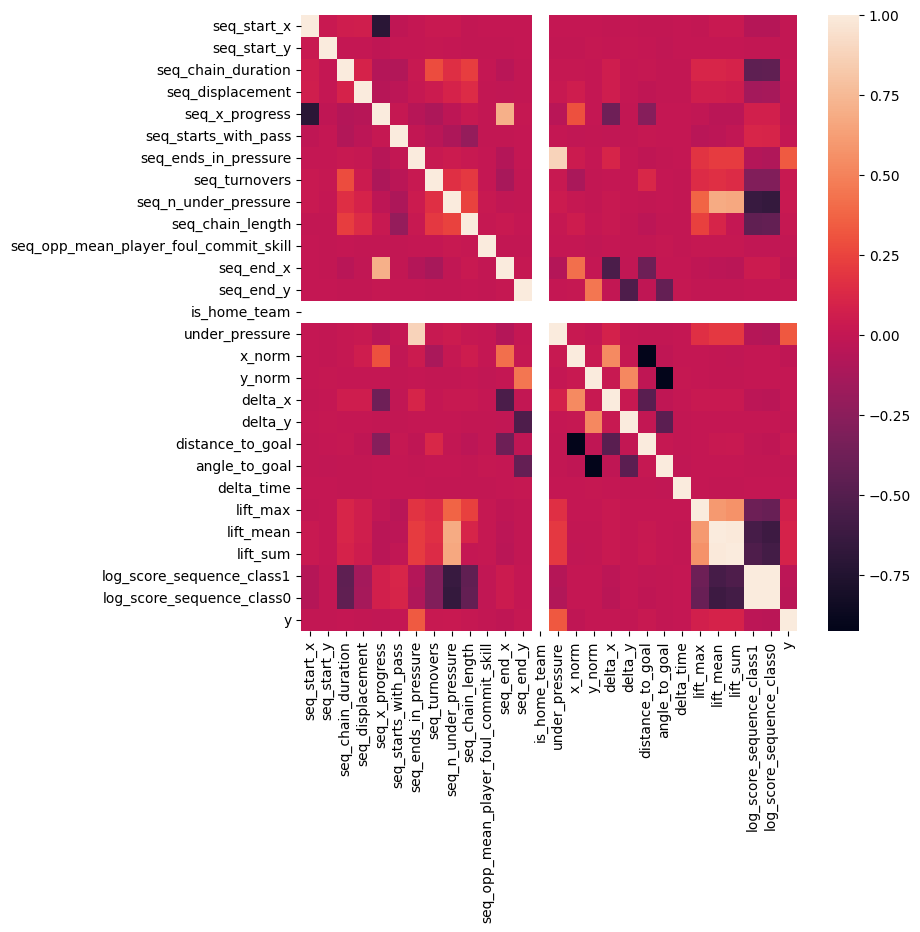

In [369]:
features = [f for f in sequence_features if f != 'side_of_pitch']
corr_df = train_context_df[features+['y']].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_df)
plt.show()

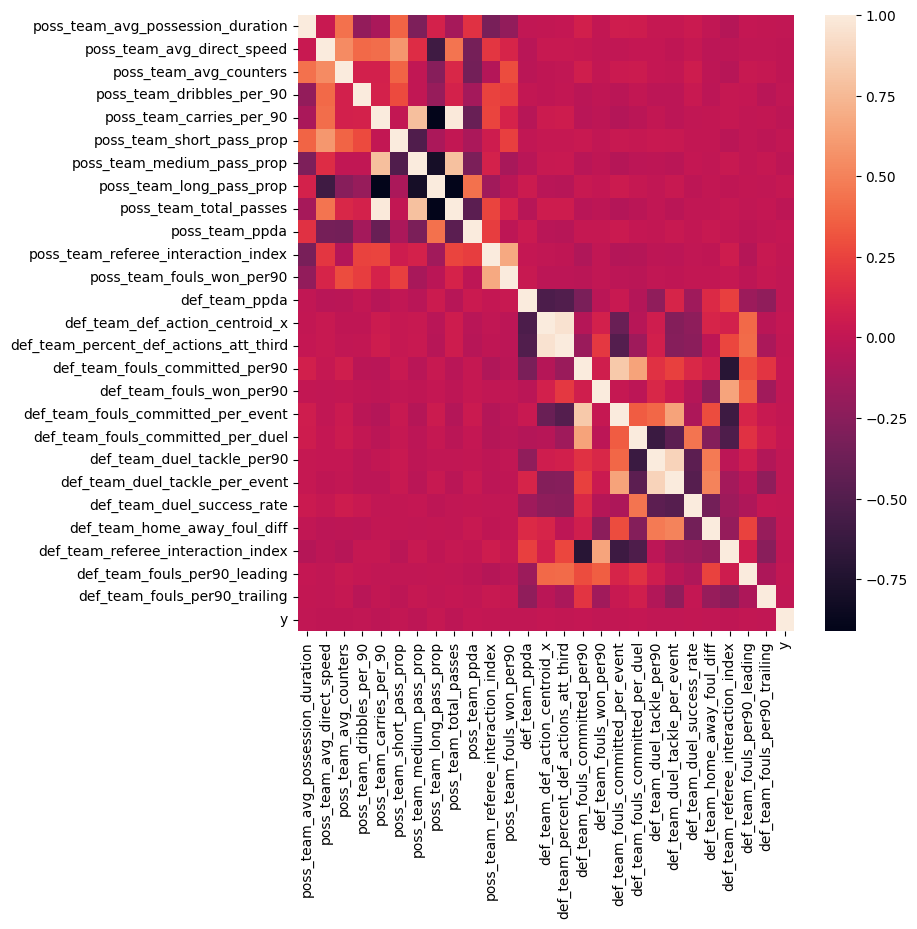

In [371]:
corr_df = train_context_df[team_embed_features+['y']].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_df)
plt.show()

In [373]:
seq_home_features_missing_prop = (train_context_df[home_features].isna().sum()/len(train_context_df)).to_dict()
seq_away_features_missing_prop = (train_context_df[away_features].isna().sum()/len(train_context_df)).to_dict()

In [395]:
# remove features missing more than 30%
home_features_to_keep = [f for f,v in seq_home_features_missing_prop.items() if v < 0.3]
away_features_to_keep = [f for f,v in seq_away_features_missing_prop.items() if v < 0.3]

training_features = sequence_features + home_features_to_keep + away_features_to_keep + team_embed_features
training_features

['seq_start_x',
 'seq_start_y',
 'seq_chain_duration',
 'seq_displacement',
 'seq_x_progress',
 'seq_starts_with_pass',
 'seq_ends_in_pressure',
 'seq_turnovers',
 'seq_n_under_pressure',
 'seq_chain_length',
 'seq_opp_mean_player_foul_commit_skill',
 'seq_end_x',
 'seq_end_y',
 'is_home_team',
 'under_pressure',
 'x_norm',
 'y_norm',
 'delta_x',
 'delta_y',
 'distance_to_goal',
 'angle_to_goal',
 'delta_time',
 'lift_max',
 'lift_mean',
 'lift_sum',
 'log_score_sequence_class1',
 'log_score_sequence_class0',
 'home_cnt_pass',
 'home_cnt_success_pass',
 'home_pass_success_rate',
 'home_cnt_ball_receipt',
 'home_cnt_success_ball_receipt',
 'home_ball_receipt_success_rate',
 'home_cnt_pressure',
 'home_cnt_carry',
 'home_cnt_clearance',
 'home_cnt_block',
 'home_cnt_miscontrol',
 'home_cnt_ball_recovery',
 'home_cnt_interception',
 'home_cnt_shot',
 'home_cnt_duel',
 'home_cnt_success_duel',
 'home_duel_success_rate',
 'home_cnt_dispossessed',
 'home_cnt_foul_committed',
 'home_cnt_foul_

In [376]:
len(training_features)

121

In [135]:
n_rows*3

87

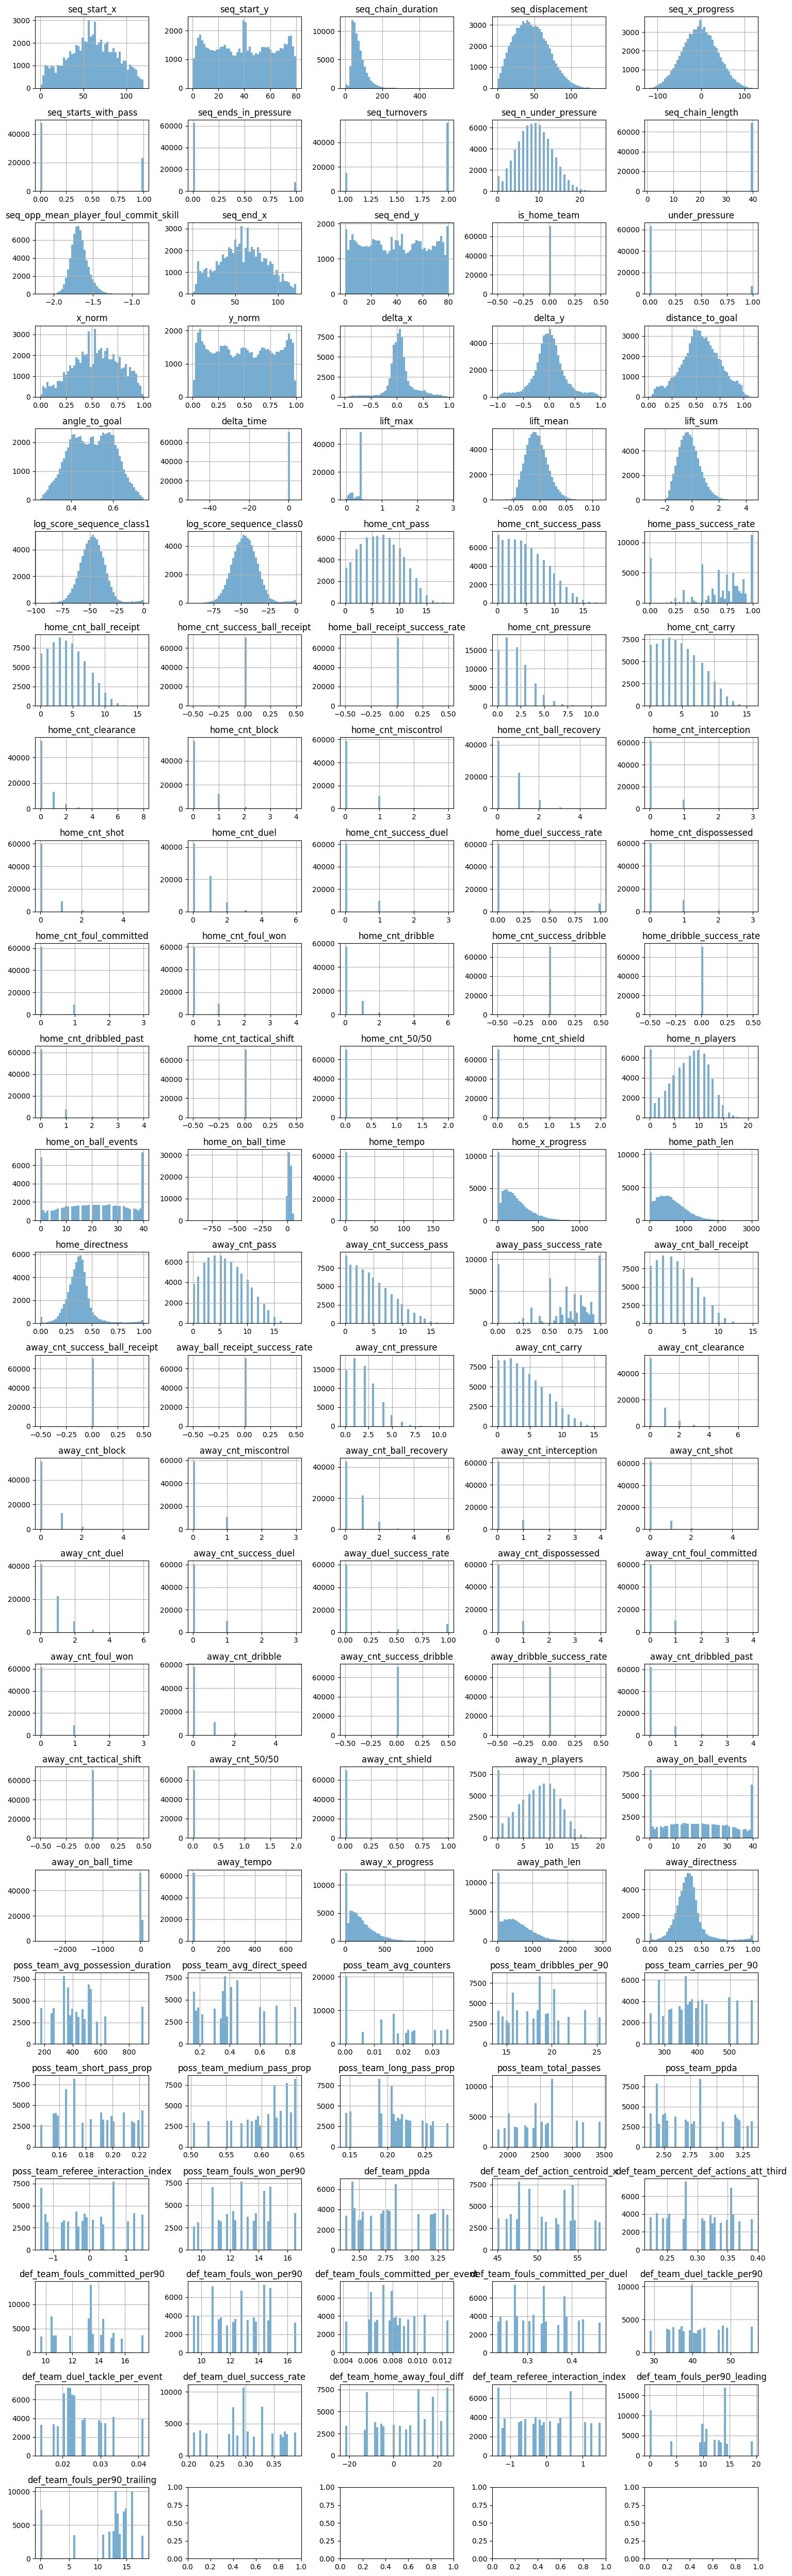

In [377]:
# feature histograms

num_features = len(training_features)
n_cols = 5
n_rows = int(num_features / n_cols)

fig, axs = plt.subplots(n_rows+1, n_cols, figsize=(15, 50))
row, col = 0,0
for f in training_features:
    train_context_df[f].hist(bins=50, ax=axs[row][col], alpha=0.6)
    
    axs[row][col].set_title(f)
    if col == n_cols-1:
        row+=1
        col=0
    else:
        col+=1
plt.tight_layout()
plt.show()

In [380]:
# features to drop - drop features with a value present for more than 95% of the time
redundant_values_features = []
for f in training_features:
    if f == 'is_home_team':
        continue
    vc = train_context_df[f].value_counts(normalize=True)
    if vc.iloc[0] > 0.95:
        redundant_values_features.append(f)

redundant_values_features

['seq_chain_length',
 'home_cnt_success_ball_receipt',
 'home_ball_receipt_success_rate',
 'home_cnt_success_dribble',
 'home_dribble_success_rate',
 'home_cnt_tactical_shift',
 'home_cnt_50/50',
 'home_cnt_shield',
 'away_cnt_success_ball_receipt',
 'away_ball_receipt_success_rate',
 'away_cnt_success_dribble',
 'away_dribble_success_rate',
 'away_cnt_tactical_shift',
 'away_cnt_50/50',
 'away_cnt_shield']

In [382]:
# 1. Compute absolute correlation matrix for the subset
corr = train_context_df[training_features].corr().abs()

# 2. Zero out the lower triangle and diagonal
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 3. Find columns to drop: any column having correlation > 0.95 with an earlier column
highly_correlated_features = [col for col in upper.columns if any(upper[col] > 0.95)]

In [383]:
highly_correlated_features

['lift_sum',
 'log_score_sequence_class0',
 'home_cnt_success_pass',
 'home_path_len',
 'away_cnt_success_pass',
 'away_cnt_foul_committed',
 'away_cnt_foul_won',
 'away_cnt_50/50',
 'away_on_ball_events',
 'away_path_len',
 'poss_team_total_passes',
 'def_team_percent_def_actions_att_third']

In [389]:
# remove rows with extreme values : < 0.01 & > 0.99
features_to_clip = [f for f in training_features if f not in redundant_values_features and f not in highly_correlated_features and f not in ['is_home_team','under_pressure','is_stoppage_time']]

for f in features_to_clip:
    p01 = train_context_df[f].quantile(0.001)
    p99 = train_context_df[f].quantile(0.99)
    train_context_df[f] = train_context_df[f].clip(lower=p01, upper=p99)
    test_context_df[f] = test_context_df[f].clip(lower=p01, upper=p99)

In [390]:
train_context_df.shape

(70829, 190)

In [391]:
test_context_df.shape

(15141, 190)

In [392]:
train_context_df['y'].value_counts()

y
0    68766
1     2063
Name: count, dtype: int64

In [393]:
test_context_df['y'].value_counts()

y
0    14700
1      441
Name: count, dtype: int64

In [399]:
features = [f for f in training_features if f not in redundant_values_features and f not in highly_correlated_features]

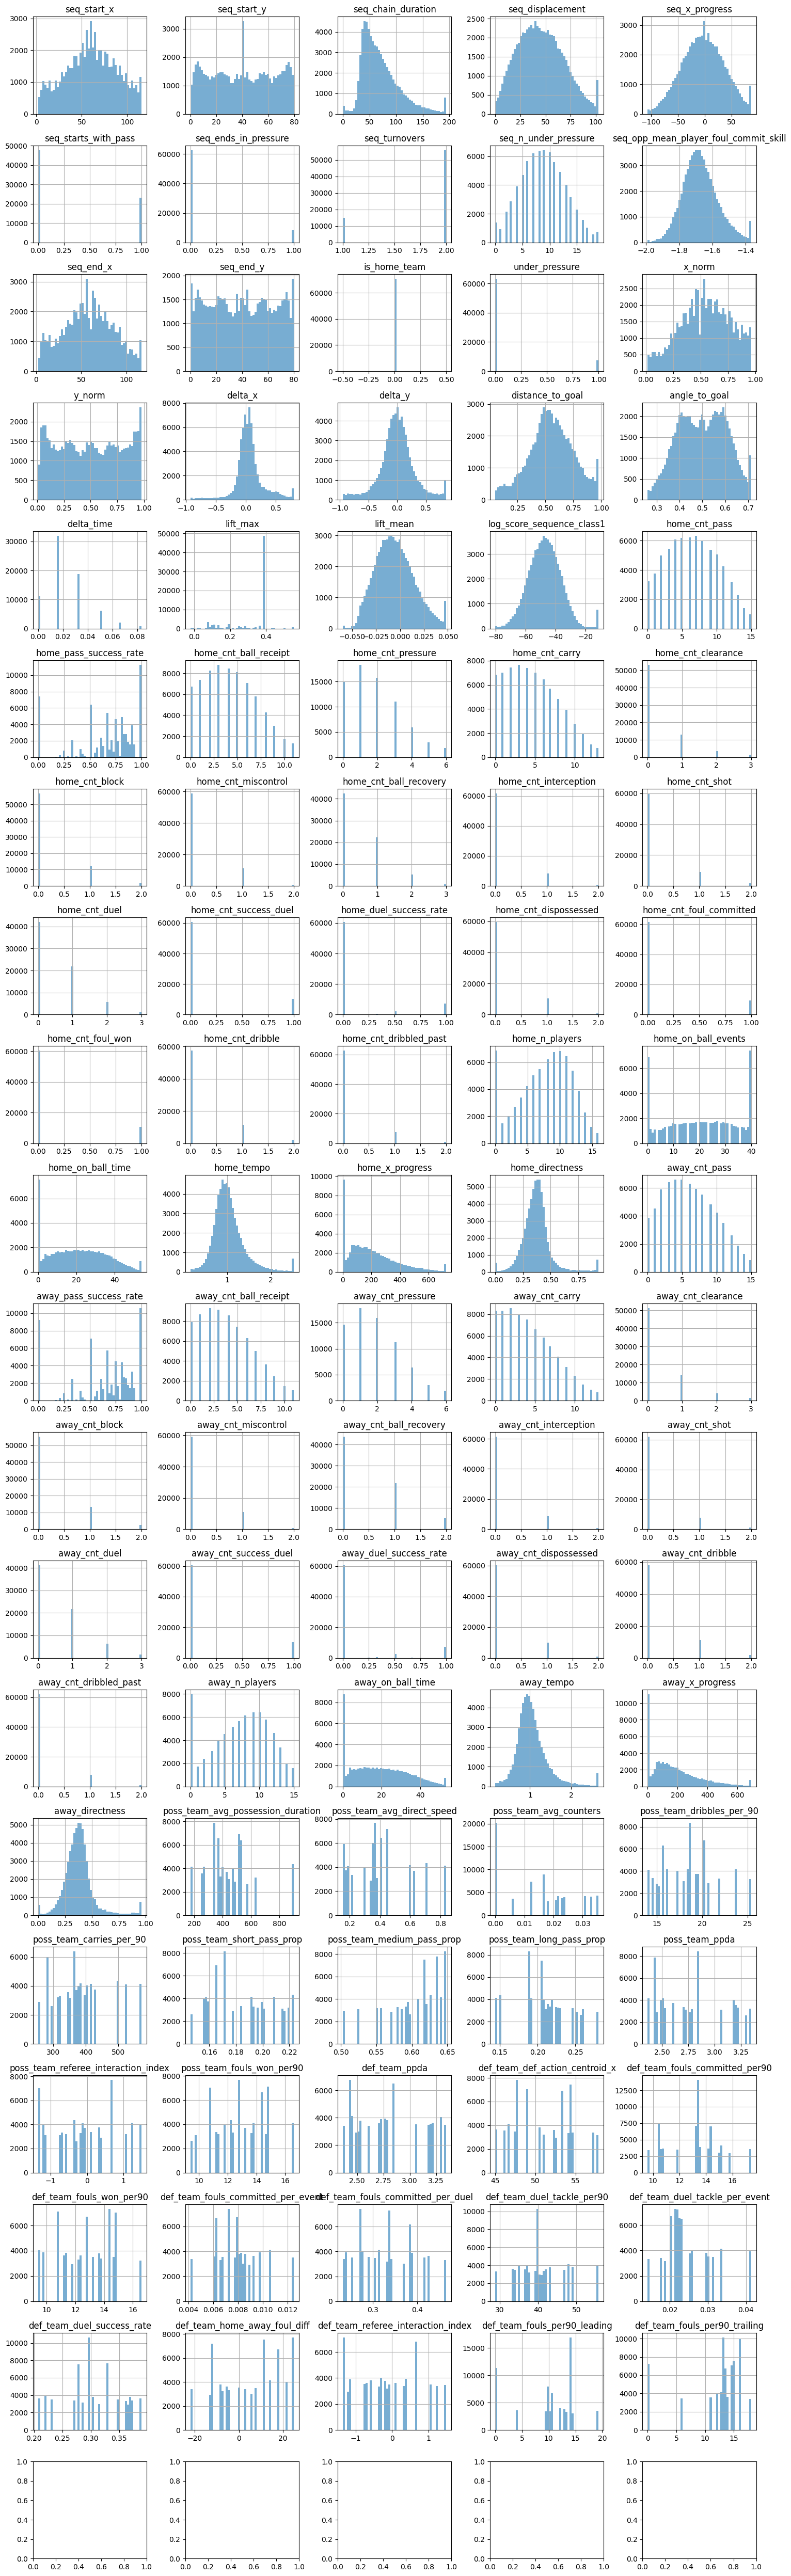

In [400]:
# feature histograms

num_features = len(features)
n_cols = 5
n_rows = int(num_features / n_cols)

fig, axs = plt.subplots(n_rows+1, n_cols, figsize=(15, 50))
row, col = 0,0
for f in features:
    train_context_df[f].hist(bins=50, ax=axs[row][col], alpha=0.6)
    
    axs[row][col].set_title(f)
    if col == n_cols-1:
        row+=1
        col=0
    else:
        col+=1
plt.tight_layout()
plt.show()

In [403]:
features

['seq_start_x',
 'seq_start_y',
 'seq_chain_duration',
 'seq_displacement',
 'seq_x_progress',
 'seq_starts_with_pass',
 'seq_ends_in_pressure',
 'seq_turnovers',
 'seq_n_under_pressure',
 'seq_opp_mean_player_foul_commit_skill',
 'seq_end_x',
 'seq_end_y',
 'is_home_team',
 'under_pressure',
 'x_norm',
 'y_norm',
 'delta_x',
 'delta_y',
 'distance_to_goal',
 'angle_to_goal',
 'delta_time',
 'lift_max',
 'lift_mean',
 'log_score_sequence_class1',
 'home_cnt_pass',
 'home_pass_success_rate',
 'home_cnt_ball_receipt',
 'home_cnt_pressure',
 'home_cnt_carry',
 'home_cnt_clearance',
 'home_cnt_block',
 'home_cnt_miscontrol',
 'home_cnt_ball_recovery',
 'home_cnt_interception',
 'home_cnt_shot',
 'home_cnt_duel',
 'home_cnt_success_duel',
 'home_duel_success_rate',
 'home_cnt_dispossessed',
 'home_cnt_foul_committed',
 'home_cnt_foul_won',
 'home_cnt_dribble',
 'home_cnt_dribbled_past',
 'home_n_players',
 'home_on_ball_events',
 'home_on_ball_time',
 'home_tempo',
 'home_x_progress',
 'hom

In [404]:
median_fill = [f for f in features if 'cnt' in f or f.endswith('x') or f.endswith('y') or f.endswith('players') or f.endswith('events') or 'turnover' in f]

for f in features:
    if f in median_fill:
        # median
        median_val = train_context_df[f].median()
        train_context_df[f] = train_context_df[f].fillna(median_val)
        test_context_df[f] = test_context_df[f].fillna(median_val)
    else:
        # mean
        mean_val = train_context_df[f].mean()
        train_context_df[f] = train_context_df[f].fillna(mean_val)
        test_context_df[f] = test_context_df[f].fillna(mean_val)
        
train_context_df[features].columns[train_context_df[features].isna().sum() > 0]

Index([], dtype='object')

### Checkpoint

In [405]:
# free up memory
del model_df
del events_df

## RF Classifier

In [406]:
# ohe cat feature

CAT = ['side_of_pitch']

# # Categorical → one‑hot
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe_df = pd.DataFrame(ohe.fit_transform(train_context_df[CAT]), columns=ohe.get_feature_names_out())
# # Combine cat cols
train_context_df = pd.concat([train_context_df, ohe_df], axis=1)

test_ohe_df = pd.DataFrame(ohe.transform(test_context_df[CAT]), columns=ohe.get_feature_names_out())
test_context_df = pd.concat([test_context_df.reset_index(drop=True), test_ohe_df], axis=1)

In [407]:
training_features = features + list(ohe.get_feature_names_out())

X_train = train_context_df[training_features]
X_test = test_context_df[training_features]
y_train = train_context_df['y']
y_test = test_context_df['y']

In [414]:
training_features.remove("seq_ends_in_pressure")

In [408]:
def objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_leaf=int(params['min_samples_leaf']),
        class_weight=None,
        criterion='entropy',
        random_state=42, n_jobs=-1
    )

    # Use cross_val_predict to get probabilities for PR-AUC
    y_probs = cross_val_predict(model, X_train, y_train, cv=5,
                                method='predict_proba', n_jobs=-1)[:, 1]

    pr_auc = average_precision_score(y_train, y_probs)

    return {
        'loss': -pr_auc,   # hyperopt minimizes, so negate the PR AUC
        'status': STATUS_OK,
        'pr_auc': pr_auc
    }

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 500, 10)),
    'max_depth': hp.choice('max_depth', range(3, 20)),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 3, 40)
}

trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=50, 
            trials=trials)

print("Best hyperparameters:", best)

100%|███████| 50/50 [24:59<00:00, 30.00s/trial, best loss: -0.21234618167345598]
Best hyperparameters: {'max_depth': np.int64(14), 'min_samples_leaf': np.float64(17.182286912333087), 'n_estimators': np.int64(37)}


In [415]:
from sklearn.ensemble import RandomForestClassifier

# hyperopt best parameters
rf = RandomForestClassifier(
    n_estimators=37,
    max_depth=14,
    min_samples_leaf=17,
    class_weight=None,
    criterion='entropy',
    n_jobs=-1,
    random_state=42
)
# features = list(set([f for f in training_features if f!='side_of_pitch']))
rf.fit(X_train[training_features], y_train)

RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_leaf=17,
                       n_estimators=37, n_jobs=-1, random_state=42)

In [416]:
p_train = rf.predict_proba(X_train[training_features])[:,1]
p_test  = rf.predict_proba(X_test[training_features])[:,1]

print(f"TRAIN ROC‑AUC: {roc_auc_score(y_train, p_train):.4f}, TEST ROC-AUC: {roc_auc_score(y_test,  p_test):.4f}")
print(f"TRAIN PR‑AUC: {average_precision_score(y_train, p_train):.4f}, TEST PR-AUC: {average_precision_score(y_test,  p_test):.4f}")
print(f"TRAIN log‑loss: {log_loss(y_train, p_train):.4f}, TEST  log‑loss: {log_loss(y_test,  p_test):.4f}")

TRAIN ROC‑AUC: 0.9729, TEST ROC-AUC: 0.8560
TRAIN PR‑AUC: 0.6815, TEST PR-AUC: 0.1745
TRAIN log‑loss: 0.0748, TEST  log‑loss: 0.1011


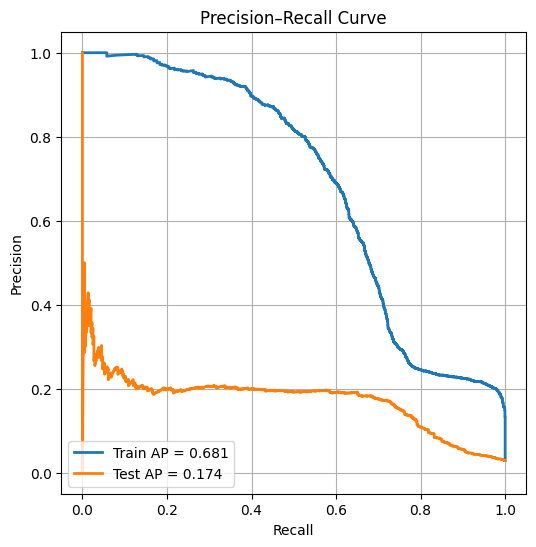

In [417]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(6, 6))

#train
precision, recall, thresholds = precision_recall_curve(y_train, p_train)
avg_prec = average_precision_score(y_train, p_train)
plt.plot(recall, precision, lw=2, label=f'Train AP = {avg_prec:.3f}')

#test
precision, recall, thresholds = precision_recall_curve(y_test, p_test)
avg_prec = average_precision_score(y_test, p_test)
plt.plot(recall, precision, lw=2, label=f'Test AP = {avg_prec:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [37]:
from sklearn.ensemble import RandomForestClassifier

# model is overfitting, reducing max_depth
rf = RandomForestClassifier(
    n_estimators=37,
    max_depth=6,
    min_samples_leaf=17,
    class_weight=None,
    criterion='entropy',
    n_jobs=-1,
    random_state=42
)
# features = list(set([f for f in training_features if f!='side_of_pitch']))
rf.fit(X_train[training_features], y_train)

/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_leaf=17,
                       n_estimators=37, n_jobs=-1, random_state=42)

In [38]:
p_train = rf.predict_proba(X_train[training_features])[:,1]
p_test  = rf.predict_proba(X_test[training_features])[:,1]

print(f"TRAIN ROC‑AUC: {roc_auc_score(y_train, p_train):.4f}, TEST ROC-AUC: {roc_auc_score(y_test,  p_test):.4f}")
print(f"TRAIN PR‑AUC: {average_precision_score(y_train, p_train):.4f}, TEST PR-AUC: {average_precision_score(y_test,  p_test):.4f}")
print(f"TRAIN log‑loss: {log_loss(y_train, p_train):.4f}, TEST  log‑loss: {log_loss(y_test,  p_test):.4f}")

TRAIN ROC‑AUC: 0.8980, TEST ROC-AUC: 0.8483
TRAIN PR‑AUC: 0.2711, TEST PR-AUC: 0.1747
TRAIN log‑loss: 0.0982, TEST  log‑loss: 0.1041


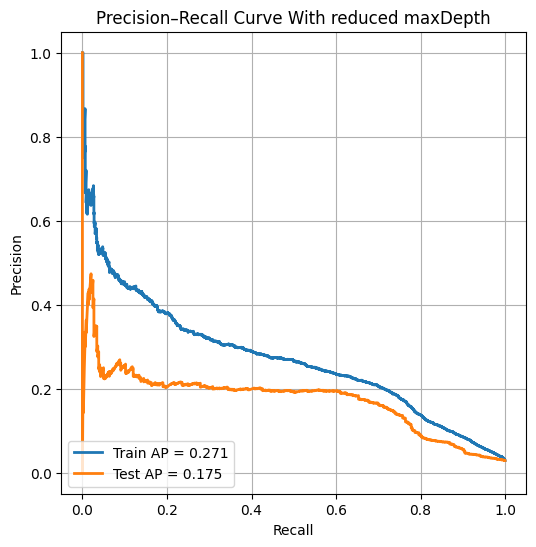

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(6, 6))

#train
precision, recall, thresholds = precision_recall_curve(y_train, p_train)
avg_prec = average_precision_score(y_train, p_train)
plt.plot(recall, precision, lw=2, label=f'Train AP = {avg_prec:.3f}')

#test
precision, recall, thresholds = precision_recall_curve(y_test, p_test)
avg_prec = average_precision_score(y_test, p_test)
plt.plot(recall, precision, lw=2, label=f'Test AP = {avg_prec:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve With reduced maxDepth')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Top 20 features by importance:
under_pressure               0.365506
delta_time                   0.179038
delta_y                      0.090947
delta_x                      0.073702
lift_mean                    0.040143
seq_end_x                    0.023057
lift_max                     0.023004
seq_end_y                    0.017634
y_norm                       0.015490
distance_to_goal             0.014246
angle_to_goal                0.013503
x_norm                       0.011645
seq_x_progress               0.007470
home_cnt_pressure            0.007402
away_cnt_pressure            0.007243
log_score_sequence_class1    0.005166
seq_chain_duration           0.004970
seq_displacement             0.004158
home_tempo                   0.003957
seq_n_under_pressure         0.003728
dtype: float64


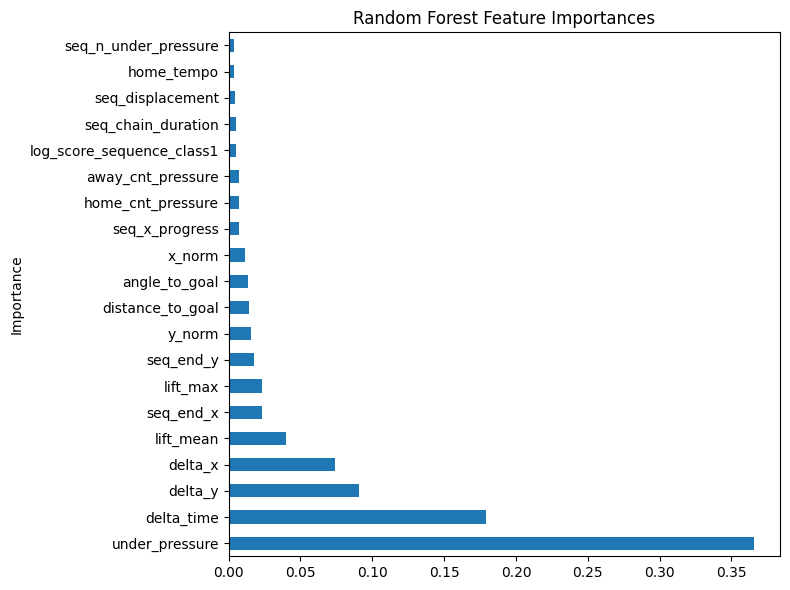

In [40]:
importances = rf.feature_importances_

feat_imp = pd.Series(importances, index=training_features)

feat_imp = feat_imp.sort_values(ascending=False)

print("Top 20 features by importance:")
print(feat_imp.head(20))

plt.figure(figsize=(8,6))
feat_imp.head(20).plot.barh()
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Lowest 20 features by importance:
home_cnt_ball_recovery     0.000326
away_cnt_miscontrol        0.000306
home_cnt_clearance         0.000277
home_cnt_dribble           0.000267
home_duel_success_rate     0.000237
home_cnt_interception      0.000217
home_cnt_dribbled_past     0.000215
home_cnt_block             0.000204
home_cnt_success_duel      0.000181
away_cnt_block             0.000161
home_cnt_foul_won          0.000150
seq_starts_with_pass       0.000136
away_cnt_dribbled_past     0.000132
home_cnt_shot              0.000116
away_cnt_ball_recovery     0.000085
home_cnt_miscontrol        0.000074
away_cnt_interception      0.000055
away_cnt_dispossessed      0.000052
is_home_team               0.000000
home_cnt_foul_committed    0.000000
dtype: float64


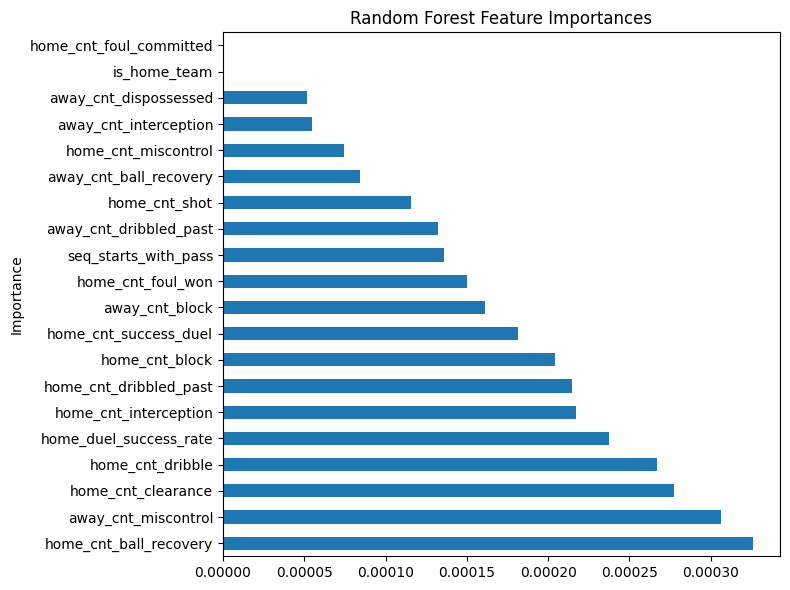

In [41]:
print("Lowest 20 features by importance:")
print(feat_imp.tail(20))

plt.figure(figsize=(8,6))
feat_imp.tail(20).plot.barh()
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

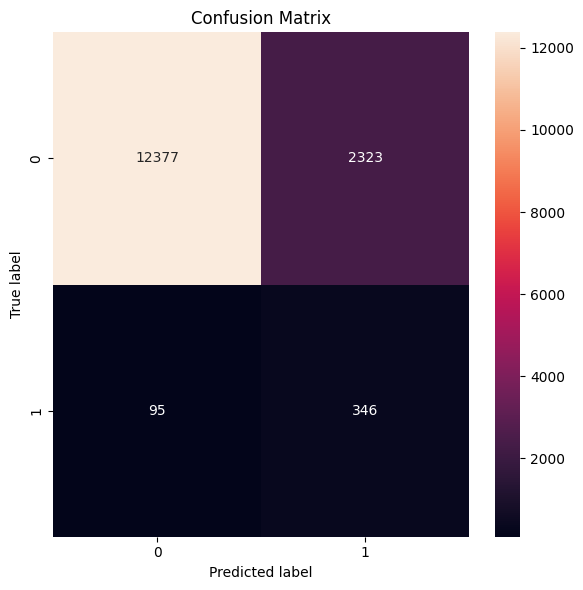

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     14700
           1       0.13      0.78      0.22       441

    accuracy                           0.84     15141
   macro avg       0.56      0.81      0.57     15141
weighted avg       0.97      0.84      0.89     15141



In [431]:
from sklearn.metrics import confusion_matrix, classification_report

threshold = 0.035
preds = (p_test > threshold).astype(int)
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    # cmap='mag,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


print("Classification Report:\n")
print(classification_report(y_test, preds))

/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A co

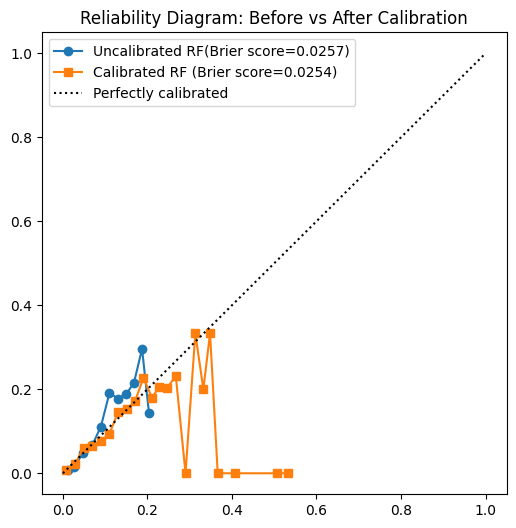

In [43]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss


calibrated_rf = CalibratedClassifierCV(
    estimator=rf,
    method="isotonic",
    cv=5,
)

calibrated_rf.fit(X_train[training_features], y_train)

probs_cal = calibrated_rf.predict_proba(X_test[training_features])[:, 1]

frac_pos, mean_pred_val = calibration_curve(
    y_test, p_test, n_bins=50
)
frac_pos_cal, mean_pred_val_cal = calibration_curve(
    y_test, probs_cal, n_bins=50
)

uncal_brier = brier_score_loss(y_test, p_test)
cal_brier = brier_score_loss(y_test, probs_cal)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred_val, frac_pos, "o-", label=f"Uncalibrated RF(Brier score={uncal_brier:.4f})")
plt.plot(mean_pred_val_cal, frac_pos_cal, "s-", label=f"Calibrated RF (Brier score={cal_brier:.4f})")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.legend()
plt.title("Reliability Diagram: Before vs After Calibration")
plt.show()

### Checkpoint

Saving X_train, X_test, y_train and y_test as I need to restart the kernel

In [446]:
X_train.to_csv("processed_data/x_train_context.csv")
y_train.to_csv("processed_data/y_train_context.csv")
X_test.to_csv("processed_data/x_test_context.csv")
y_test.to_csv("processed_data/y_test_context.csv")

## XGBoost Classifier

In [8]:
X_train = pd.read_csv("processed_data/x_train_context.csv")
y_train = pd.read_csv("processed_data/y_train_context.csv")
X_test = pd.read_csv("processed_data/x_test_context.csv")
y_test = pd.read_csv("processed_data/y_test_context.csv")

In [9]:
y_train = y_train[['y']]
y_test = y_test[['y']]

In [3]:
training_features = [
    'seq_start_x',
    'seq_start_y',
    'seq_chain_duration',
    'seq_displacement',
    'seq_x_progress',
    'seq_starts_with_pass',
    # 'seq_ends_in_pressure',
    'seq_turnovers',
    'seq_n_under_pressure',
    'seq_opp_mean_player_foul_commit_skill',
    'seq_end_x',
    'seq_end_y',
    'is_home_team',
    'under_pressure',
    'x_norm',
    'y_norm',
    'delta_x',
    'delta_y',
    'distance_to_goal',
    'angle_to_goal',
    'delta_time',
    'lift_max',
    'lift_mean',
    'log_score_sequence_class1',
    'home_cnt_pass',
    'home_pass_success_rate',
    'home_cnt_ball_receipt',
    'home_cnt_pressure',
    'home_cnt_carry',
    'home_cnt_clearance',
    'home_cnt_block',
    'home_cnt_miscontrol',
    'home_cnt_ball_recovery',
    'home_cnt_interception',
    'home_cnt_shot',
    'home_cnt_duel',
    'home_cnt_success_duel',
    'home_duel_success_rate',
    'home_cnt_dispossessed',
    'home_cnt_foul_committed',
    'home_cnt_foul_won',
    'home_cnt_dribble',
    'home_cnt_dribbled_past',
    'home_n_players',
    'home_on_ball_events',
    'home_on_ball_time',
    'home_tempo',
    'home_x_progress',
    'home_directness',
    'away_cnt_pass',
    'away_pass_success_rate',
    'away_cnt_ball_receipt',
    'away_cnt_pressure',
    'away_cnt_carry',
    'away_cnt_clearance',
    'away_cnt_block',
    'away_cnt_miscontrol',
    'away_cnt_ball_recovery',
    'away_cnt_interception',
    'away_cnt_shot',
    'away_cnt_duel',
    'away_cnt_success_duel',
    'away_duel_success_rate',
    'away_cnt_dispossessed',
    'away_cnt_dribble',
    'away_cnt_dribbled_past',
    'away_n_players',
    'away_on_ball_time',
    'away_tempo',
    'away_x_progress',
    'away_directness',
    'poss_team_avg_possession_duration',
    'poss_team_avg_direct_speed',
    'poss_team_avg_counters',
    'poss_team_dribbles_per_90',
    'poss_team_carries_per_90',
    'poss_team_short_pass_prop',
    'poss_team_medium_pass_prop',
    'poss_team_long_pass_prop',
    'poss_team_ppda',
    'poss_team_referee_interaction_index',
    'poss_team_fouls_won_per90',
    'def_team_ppda',
    'def_team_def_action_centroid_x',
    'def_team_fouls_committed_per90',
    'def_team_fouls_won_per90',
    'def_team_fouls_committed_per_event',
    'def_team_fouls_committed_per_duel',
    'def_team_duel_tackle_per90',
    'def_team_duel_tackle_per_event',
    'def_team_duel_success_rate',
    'def_team_home_away_foul_diff',
    'def_team_referee_interaction_index',
    'def_team_fouls_per90_leading',
    'def_team_fouls_per90_trailing',
    'side_of_pitch_Right',
    'side_of_pitch_Left'
]

In [27]:
def objective(params):
    model = xgboost.XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        # tree_method="hist",     # faster for large datasets
        random_state=42,
        **params
    )
    model.fit(X_train[training_features], y_train, verbose=False)
    y_probs = model.predict_proba(X_test[training_features])[:, 1]
    pr_auc = average_precision_score(y_test, y_probs)

    return {
        'loss': -pr_auc,   # hyperopt minimizes, so negate the PR AUC
        'status': STATUS_OK,
        'pr_auc': pr_auc
    }

# Define the hyperparameter search space
space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),  # integers 3–9
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(50, 500)),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

trials = Trials()
best = fmin(
    fn=objective, 
    space=space, 
    algo=tpe.suggest, 
    max_evals=50, 
    trials=trials
)

print("Best hyperparameters:", best)

100%|████████| 50/50 [00:41<00:00,  1.19trial/s, best loss: -0.1934796266633974]
Best hyperparameters: {'colsample_bytree': np.float64(0.8712457753013657), 'gamma': np.float64(3.7845825793824033), 'learning_rate': np.float64(0.02036829308743543), 'max_depth': np.int64(4), 'min_child_weight': np.float64(5.754603090661287), 'n_estimators': np.int64(168), 'subsample': np.float64(0.7300145124234941)}


In [28]:
xgb_clf = xgboost.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    n_estimators=168,
    max_depth=4,
    colsample_bytree=0.8712457753013657,
    gamma=3.7845825793824033,
    learning_rate=0.02036829308743543,
    min_child_weight=5.754603090661287,
    subsample=0.7300145124234941,
    random_state=42
)

xgb_clf.fit(X_train[training_features], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8712457753013657, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=3.7845825793824033,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02036829308743543,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5.754603090661287, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=168,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [29]:
p_train = xgb_clf.predict_proba(X_train[training_features])[:,1]
p_test  = xgb_clf.predict_proba(X_test[training_features])[:,1]

print(f"TRAIN ROC‑AUC: {roc_auc_score(y_train, p_train):.4f}, TEST ROC-AUC: {roc_auc_score(y_test,  p_test):.4f}")
print(f"TRAIN PR‑AUC: {average_precision_score(y_train, p_train):.4f}, TEST PR-AUC: {average_precision_score(y_test,  p_test):.4f}")
print(f"TRAIN log‑loss: {log_loss(y_train, p_train):.4f}, TEST  log‑loss: {log_loss(y_test,  p_test):.4f}")

TRAIN ROC‑AUC: 0.8974, TEST ROC-AUC: 0.8624
TRAIN PR‑AUC: 0.2944, TEST PR-AUC: 0.1785
TRAIN log‑loss: 0.0943, TEST  log‑loss: 0.1010


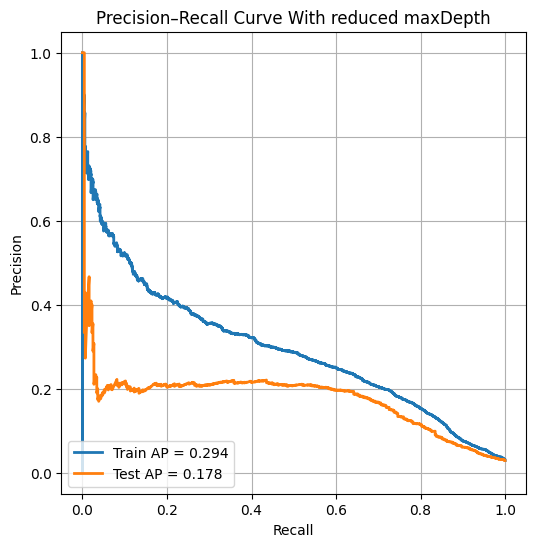

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(6, 6))

#train
precision, recall, thresholds = precision_recall_curve(y_train, p_train)
avg_prec = average_precision_score(y_train, p_train)
plt.plot(recall, precision, lw=2, label=f'Train AP = {avg_prec:.3f}')

#test
precision, recall, thresholds = precision_recall_curve(y_test, p_test)
avg_prec = average_precision_score(y_test, p_test)
plt.plot(recall, precision, lw=2, label=f'Test AP = {avg_prec:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve With reduced maxDepth')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


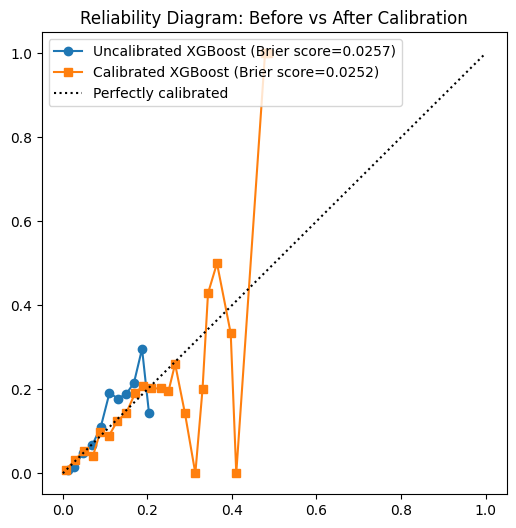

In [44]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss


calibrated_xgb = CalibratedClassifierCV(
    estimator=xgb_clf,
    method="isotonic",
    cv=5,
)

calibrated_xgb.fit(X_train[training_features], y_train)

probs_cal = calibrated_xgb.predict_proba(X_test[training_features])[:, 1]

frac_pos, mean_pred_val = calibration_curve(
    y_test, p_test, n_bins=50
)
frac_pos_cal, mean_pred_val_cal = calibration_curve(
    y_test, probs_cal, n_bins=50
)

uncal_brier = brier_score_loss(y_test, p_test)
cal_brier = brier_score_loss(y_test, probs_cal)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred_val, frac_pos, "o-", label=f"Uncalibrated XGBoost (Brier score={uncal_brier:.4f})")
plt.plot(mean_pred_val_cal, frac_pos_cal, "s-", label=f"Calibrated XGBoost (Brier score={cal_brier:.4f})")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.legend()
plt.title("Reliability Diagram: Before vs After Calibration")
plt.show()

Top 20 features by importance:
under_pressure                        0.358149
delta_time                            0.026840
delta_y                               0.018186
delta_x                               0.014017
x_norm                                0.013694
away_cnt_block                        0.012692
seq_end_x                             0.012127
lift_max                              0.011316
lift_mean                             0.009914
away_cnt_dispossessed                 0.009725
distance_to_goal                      0.009719
def_team_duel_tackle_per90            0.009688
seq_x_progress                        0.008901
seq_starts_with_pass                  0.008580
poss_team_short_pass_prop             0.008272
seq_chain_duration                    0.008129
poss_team_medium_pass_prop            0.008105
away_cnt_pass                         0.008062
away_cnt_shot                         0.008026
def_team_referee_interaction_index    0.008023
dtype: float32


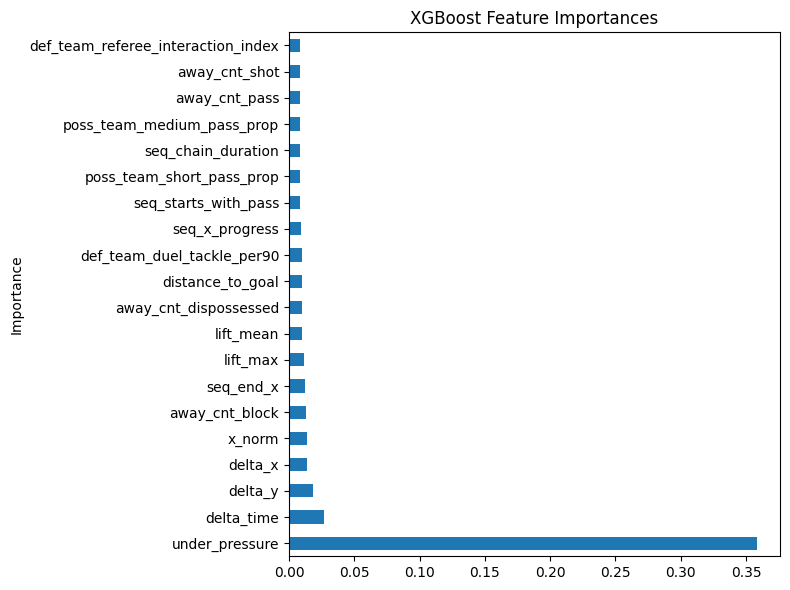

In [33]:
importances = xgb_clf.feature_importances_

feat_imp = pd.Series(importances, index=training_features)

feat_imp = feat_imp.sort_values(ascending=False)

print("Top 20 features by importance:")
print(feat_imp.head(20))

plt.figure(figsize=(8,6))
feat_imp.head(20).plot.barh()
plt.title("XGBoost Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Lowest 20 features by importance:
away_cnt_carry                        0.005576
def_team_fouls_committed_per_event    0.005543
home_cnt_shot                         0.005194
home_cnt_clearance                    0.004741
away_cnt_success_duel                 0.004428
home_cnt_success_duel                 0.004419
away_cnt_clearance                    0.004167
away_cnt_ball_recovery                0.003320
home_cnt_ball_receipt                 0.000000
away_n_players                        0.000000
away_cnt_dribble                      0.000000
home_cnt_interception                 0.000000
away_cnt_interception                 0.000000
is_home_team                          0.000000
away_cnt_miscontrol                   0.000000
seq_turnovers                         0.000000
home_cnt_foul_committed               0.000000
home_cnt_foul_won                     0.000000
side_of_pitch_Right                   0.000000
side_of_pitch_Left                    0.000000
dtype: float32


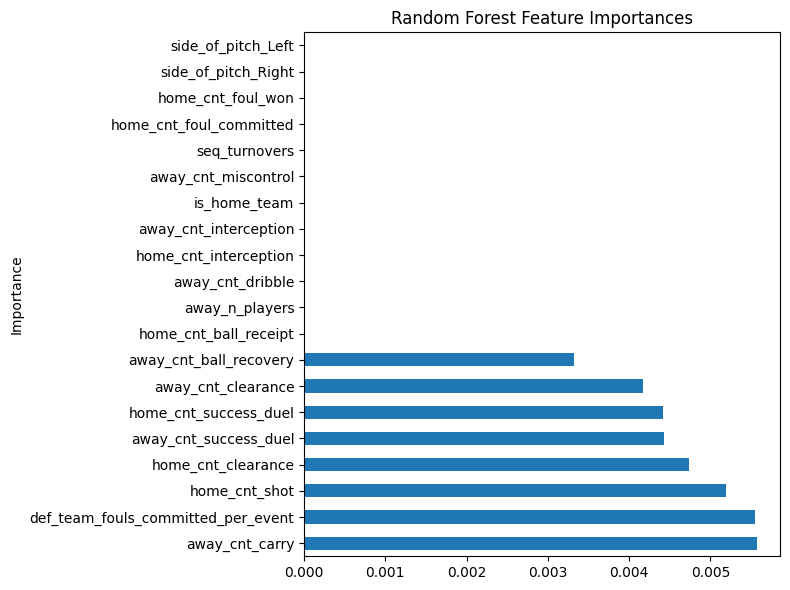

In [32]:
print("Lowest 20 features by importance:")
print(feat_imp.tail(20))

plt.figure(figsize=(8,6))
feat_imp.tail(20).plot.barh()
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

-----------------------------------------

| **Metric**          | **Random Forest** | **XGBoost** |
|---------------------|:-----------------:|:-----------:|
| **Train ROC-AUC**   | **0.8980**        | 0.8974      |
| **Test ROC-AUC**    | 0.8483            | **0.8624**  |
| **Train PR-AUC**    | 0.2711            | **0.2944**  |
| **Test PR-AUC**     | 0.1747            | **0.1785**  |
| **Train Log-Loss**  | 0.0982            | **0.0943**  |
| **Test Log-Loss**   | 0.1041            | **0.1010**  |

**Summary**

- ROC-AUC: XGBoost edges out on test ROC-AUC (0.8624 vs. 0.8508), though RF slightly leads on train, suggesting XGBoost is able to generalise better.

- PR-AUC: XGBoost also achieves higher precision–recall area on both train and test, indicating better rare-event discrimination.

- Calibration: XGBoost has lower log-loss on train and test, suggesting more reliable probability estimates.

- Overall, both tree-based models substantially outperform baseline logistic regression, with XGBoost showing the strongest generalization.

### Checkpoint

In [47]:
# free up memory

# del train_context_df
# del test_context_df
del X_train
del y_train
del X_test
del y_test

# Alternate Event Embeddings : LSTM AutoEncoder

In [66]:
lstm_event_embeddings = pd.read_csv("processed_data/event_embeddings_match_week_19.csv")
lstm_event_embeddings.head()

Unnamed: 0     emb_0     emb_1     emb_2     emb_3     emb_4     emb_5  \
0           0  0.566968 -0.944993  0.000610 -0.314687 -0.321746 -0.973321   
1           1  0.261152 -1.114980  0.045898 -0.000189 -0.570500 -0.626246   
2           2  0.597267 -0.876438  0.483292  0.119442 -0.189185 -0.926612   
3           3  0.231780 -1.774409  0.179105 -0.237588 -0.482267 -1.018080   
4           4  0.463613 -1.099463  0.466925  0.104953 -0.337635 -0.980302   

      emb_6     emb_7     emb_8  ...    emb_22    emb_23    emb_24    emb_25  \
0 -0.542975 -0.400382 -0.346343  ...  0.136848 -0.316614 -0.619537  0.299555   
1 -0.171906 -0.260328 -0.571252  ...  0.316854  0.049127 -0.415602  0.234931   
2 -0.146177 -0.249189 -0.482309  ... -0.297808 -0.126158 -0.362940  0.180077   
3  0.302047  0.229896  0.066072  ...  0.240804 -0.189395 -0.739812  0.512245   
4 -0.310881 -0.064376 -0.679512  ... -0.333903  0.022332 -0.767530  0.121489   

     emb_26    emb_27    emb_28    emb_29    emb_30    emb_31  
0  0.044377 -0.382006 -0.479136  0.219758  0.376047  0.651206  
1  0.286699 -0.647901 -0.529944  0.197117  1.034050  0.373522  
2  0.287917 -0.897946 -0.010545  0.371537  0.967093 -0.335085  
3 -0.100965 -0.512710  0.350919  0.313423  0.816935  0.231112  
4  0.293056 -0.816443  0.121452  0.492017  0.873843 -0.281342  

[5 rows x 33 columns]

In [67]:
lstm_event_embeddings.tail()

Unnamed: 0     emb_0     emb_1     emb_2     emb_3     emb_4  \
187799      187799 -0.534829 -1.036773  0.098000 -0.087627 -0.717054   
187800      187800 -0.329500 -0.494649 -0.004041  0.099513 -0.448205   
187801      187801 -0.378755 -0.713495  0.238963  0.056918 -0.507533   
187802      187802 -0.796371 -1.414688 -0.065861  0.165061 -0.299411   
187803      187803 -0.093818 -0.756829 -0.385052 -0.052261 -1.079467   

           emb_5     emb_6     emb_7     emb_8  ...    emb_22    emb_23  \
187799 -0.574630  0.116480 -0.237341 -0.634822  ...  0.147423 -0.418302   
187800 -0.527204 -0.132688 -0.523064 -1.247482  ...  0.285203 -0.133894   
187801 -0.513862 -0.244239 -0.297895 -0.393935  ... -0.533955 -0.106934   
187802 -0.957887 -0.053616 -0.326910 -0.524404  ... -0.337260 -0.302756   
187803 -0.232694  0.326288 -0.184324 -0.526396  ... -0.202536 -0.189699   

          emb_24    emb_25    emb_26    emb_27    emb_28    emb_29    emb_30  \
187799 -0.377500  0.061552 -0.400191 -0.280056 -0.077126  0.417110  0.510013   
187800 -0.027803 -0.226011 -0.191615 -0.496851 -0.329502  0.570316  0.560844   
187801 -0.328738 -0.467000 -0.421642 -1.017501 -0.297782  0.299975  0.620047   
187802 -0.524904 -0.386954 -0.045609 -0.422972 -0.145264  0.545576  0.223054   
187803 -0.349091 -0.179788  0.639266 -0.079915 -1.003452  0.776091  0.366714   

          emb_31  
187799 -0.520653  
187800 -0.323888  
187801 -0.617260  
187802 -0.608556  
187803  0.261985  

[5 rows x 33 columns]

In [68]:
events_df = pd.read_csv("processed_data/clean_events_w_engineered_feats.csv")

In [69]:
model_df = pd.read_csv("processed_data/train_data_w_team_embeddings.csv")

In [70]:
"""
    The LSTM Autoencoder was trained on first 19 match week events.
    We can reset the index of model_df to align them with lstm embeddings index
"""

sampled_model_df = model_df[model_df.match_week < 20].reset_index(drop=True)

In [71]:
sampled_model_df.tail()

Unnamed: 0  match_id  index  team.id  is_foul_won  possession_team.id  \
137496      328783   3754351   3124       24            0                  24   
137497      328784   3754351   3129       24            0                  24   
137498      328785   3754351   3132       24            0                  24   
137499      328786   3754351   3135       24            0                  24   
137500      328787   3754351   3138       24            0                  24   

        match_week  under_pressure  is_home  is_stoppage_time  ...  \
137496          12               0        1              True  ...   
137497          12               0        1              True  ...   
137498          12               0        1              True  ...   
137499          12               0        1              True  ...   
137500          12               0        1              True  ...   

       def_team_fouls_won_per90  def_team_fouls_committed_per_event  \
137496                     14.8                              0.0125   
137497                     14.8                              0.0125   
137498                     14.8                              0.0125   
137499                     14.8                              0.0125   
137500                     14.8                              0.0125   

        def_team_fouls_committed_per_duel  def_team_duel_tackle_per90  \
137496                           0.416268                        41.8   
137497                           0.416268                        41.8   
137498                           0.416268                        41.8   
137499                           0.416268                        41.8   
137500                           0.416268                        41.8   

        def_team_duel_tackle_per_event  def_team_duel_success_rate  \
137496                        0.030029                    0.277512   
137497                        0.030029                    0.277512   
137498                        0.030029                    0.277512   
137499                        0.030029                    0.277512   
137500                        0.030029                    0.277512   

        def_team_home_away_foul_diff  def_team_referee_interaction_index  \
137496                            18                               -0.78   
137497                            18                               -0.78   
137498                            18                               -0.78   
137499                            18                               -0.78   
137500                            18                               -0.78   

        def_team_fouls_per90_leading  def_team_fouls_per90_trailing  
137496                     19.333333                           14.5  
137497                     19.333333                           14.5  
137498                     19.333333                           14.5  
137499                     19.333333                           14.5  
137500                     19.333333                           14.5  

[5 rows x 47 columns]

In [72]:
lstm_event_embeddings = lstm_event_embeddings.drop('Unnamed: 0', axis=1)
sampled_model_df = sampled_model_df.drop('Unnamed: 0', axis=1)

In [73]:
lstm_event_embeddings.index.max() - len(sampled_model_df)

50302

In [76]:
# removing events before match_week 5

event_emb_start_idx = lstm_event_embeddings.index.max() - len(sampled_model_df)
lstm_event_embeddings_post_week5 = lstm_event_embeddings.iloc[event_emb_start_idx+1:].reset_index()
lstm_event_embeddings_post_week5.tail()

index     emb_0     emb_1     emb_2     emb_3     emb_4     emb_5  \
137496  187799 -0.534829 -1.036773  0.098000 -0.087627 -0.717054 -0.574630   
137497  187800 -0.329500 -0.494649 -0.004041  0.099513 -0.448205 -0.527204   
137498  187801 -0.378755 -0.713495  0.238963  0.056918 -0.507533 -0.513862   
137499  187802 -0.796371 -1.414688 -0.065861  0.165061 -0.299411 -0.957887   
137500  187803 -0.093818 -0.756829 -0.385052 -0.052261 -1.079467 -0.232694   

           emb_6     emb_7     emb_8  ...    emb_22    emb_23    emb_24  \
137496  0.116480 -0.237341 -0.634822  ...  0.147423 -0.418302 -0.377500   
137497 -0.132688 -0.523064 -1.247482  ...  0.285203 -0.133894 -0.027803   
137498 -0.244239 -0.297895 -0.393935  ... -0.533955 -0.106934 -0.328738   
137499 -0.053616 -0.326910 -0.524404  ... -0.337260 -0.302756 -0.524904   
137500  0.326288 -0.184324 -0.526396  ... -0.202536 -0.189699 -0.349091   

          emb_25    emb_26    emb_27    emb_28    emb_29    emb_30    emb_31  
137496  0.061552 -0.400191 -0.280056 -0.077126  0.417110  0.510013 -0.520653  
137497 -0.226011 -0.191615 -0.496851 -0.329502  0.570316  0.560844 -0.323888  
137498 -0.467000 -0.421642 -1.017501 -0.297782  0.299975  0.620047 -0.617260  
137499 -0.386954 -0.045609 -0.422972 -0.145264  0.545576  0.223054 -0.608556  
137500 -0.179788  0.639266 -0.079915 -1.003452  0.776091  0.366714  0.261985  

[5 rows x 33 columns]

In [55]:
sampled_model_df.columns

Index(['match_id', 'possession', 'player_possession', 'n_events', 'index',
       'is_foul_won', 'match_week', 'under_pressure', 'possession_team.id',
       'team.id', 'player.id', 'position.id', 'pass.length', 'pass.angle',
       'pass.height.id', 'pass.height.name', 'pass.body_part.id',
       'pass.body_part.name', 'pass.type.id', 'pass.type.name',
       'pass.outcome.id', 'pass.outcome.name', 'pass.receipient.id',
       'pass.recipient.name', 'pass.end_location', 'dribble.outcome.id',
       'dribble.outcome.name', 'ball_receipt.outcome.id',
       'ball_receipt.outcome.name', 'carry.end_location', 'duel.outcome.id',
       'duel.outcome.name', 'is_home', 'is_stoppage_time', 'zone_x', 'zone_y',
       'zone_id', 'zone_type', 'side_of_pitch', 'is_penalty_area', 'x_norm',
       'y_norm', 'delta_x', 'delta_y', 'move_speed', 'distance_to_goal',
       'angle_to_goal', 'event_time_sec', 'delta_time'],
      dtype='object')

In [77]:
# add the team embeddings
for f in lstm_event_embeddings_post_week5.columns:
    sampled_model_df[f] = lstm_event_embeddings_post_week5[f]

In [78]:
sampled_model_df.columns

Index(['match_id', 'index', 'team.id', 'is_foul_won', 'possession_team.id',
       'match_week', 'under_pressure', 'is_home', 'is_stoppage_time',
       'side_of_pitch', 'x_norm', 'y_norm', 'delta_x', 'delta_y', 'move_speed',
       'distance_to_goal', 'angle_to_goal', 'event_time_sec', 'delta_time',
       'opp_team_id', 'poss_team_avg_possession_duration',
       'poss_team_avg_direct_speed', 'poss_team_avg_counters',
       'poss_team_dribbles_per_90', 'poss_team_carries_per_90',
       'poss_team_short_pass_prop', 'poss_team_medium_pass_prop',
       'poss_team_long_pass_prop', 'poss_team_total_passes', 'poss_team_ppda',
       'poss_team_referee_interaction_index', 'poss_team_fouls_won_per90',
       'def_team_ppda', 'def_team_def_action_centroid_x',
       'def_team_percent_def_actions_att_third',
       'def_team_fouls_committed_per90', 'def_team_fouls_won_per90',
       'def_team_fouls_committed_per_event',
       'def_team_fouls_committed_per_duel', 'def_team_duel_tackle_per90

In [89]:
features = [
    'under_pressure', 'is_home',
    # 'side_of_pitch',
    'x_norm', 'y_norm', 'delta_x', 'delta_y',
    'move_speed', 'distance_to_goal', 'angle_to_goal', 'event_time_sec',
    'delta_time', 
    'poss_team_avg_possession_duration','poss_team_avg_direct_speed', 'poss_team_avg_counters',
    'poss_team_dribbles_per_90', 'poss_team_carries_per_90',
    'poss_team_short_pass_prop', 'poss_team_medium_pass_prop',
    'poss_team_long_pass_prop', 'poss_team_total_passes', 'poss_team_ppda',
    'poss_team_referee_interaction_index', 'poss_team_fouls_won_per90',
    'def_team_ppda', 'def_team_def_action_centroid_x',
    'def_team_percent_def_actions_att_third',
    'def_team_fouls_committed_per90', 'def_team_fouls_won_per90',
    'def_team_fouls_committed_per_event',
    'def_team_fouls_committed_per_duel', 'def_team_duel_tackle_per90',
    'def_team_duel_tackle_per_event', 'def_team_duel_success_rate',
    'def_team_home_away_foul_diff', 'def_team_referee_interaction_index',
    'def_team_fouls_per90_leading', 'def_team_fouls_per90_trailing',
    'emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5',
    'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12',
    'emb_13', 'emb_14', 'emb_15', 'emb_16', 'emb_17', 'emb_18', 'emb_19',
    'emb_20', 'emb_21', 'emb_22', 'emb_23', 'emb_24', 'emb_25', 'emb_26',
    'emb_27', 'emb_28', 'emb_29', 'emb_30', 'emb_31'
]

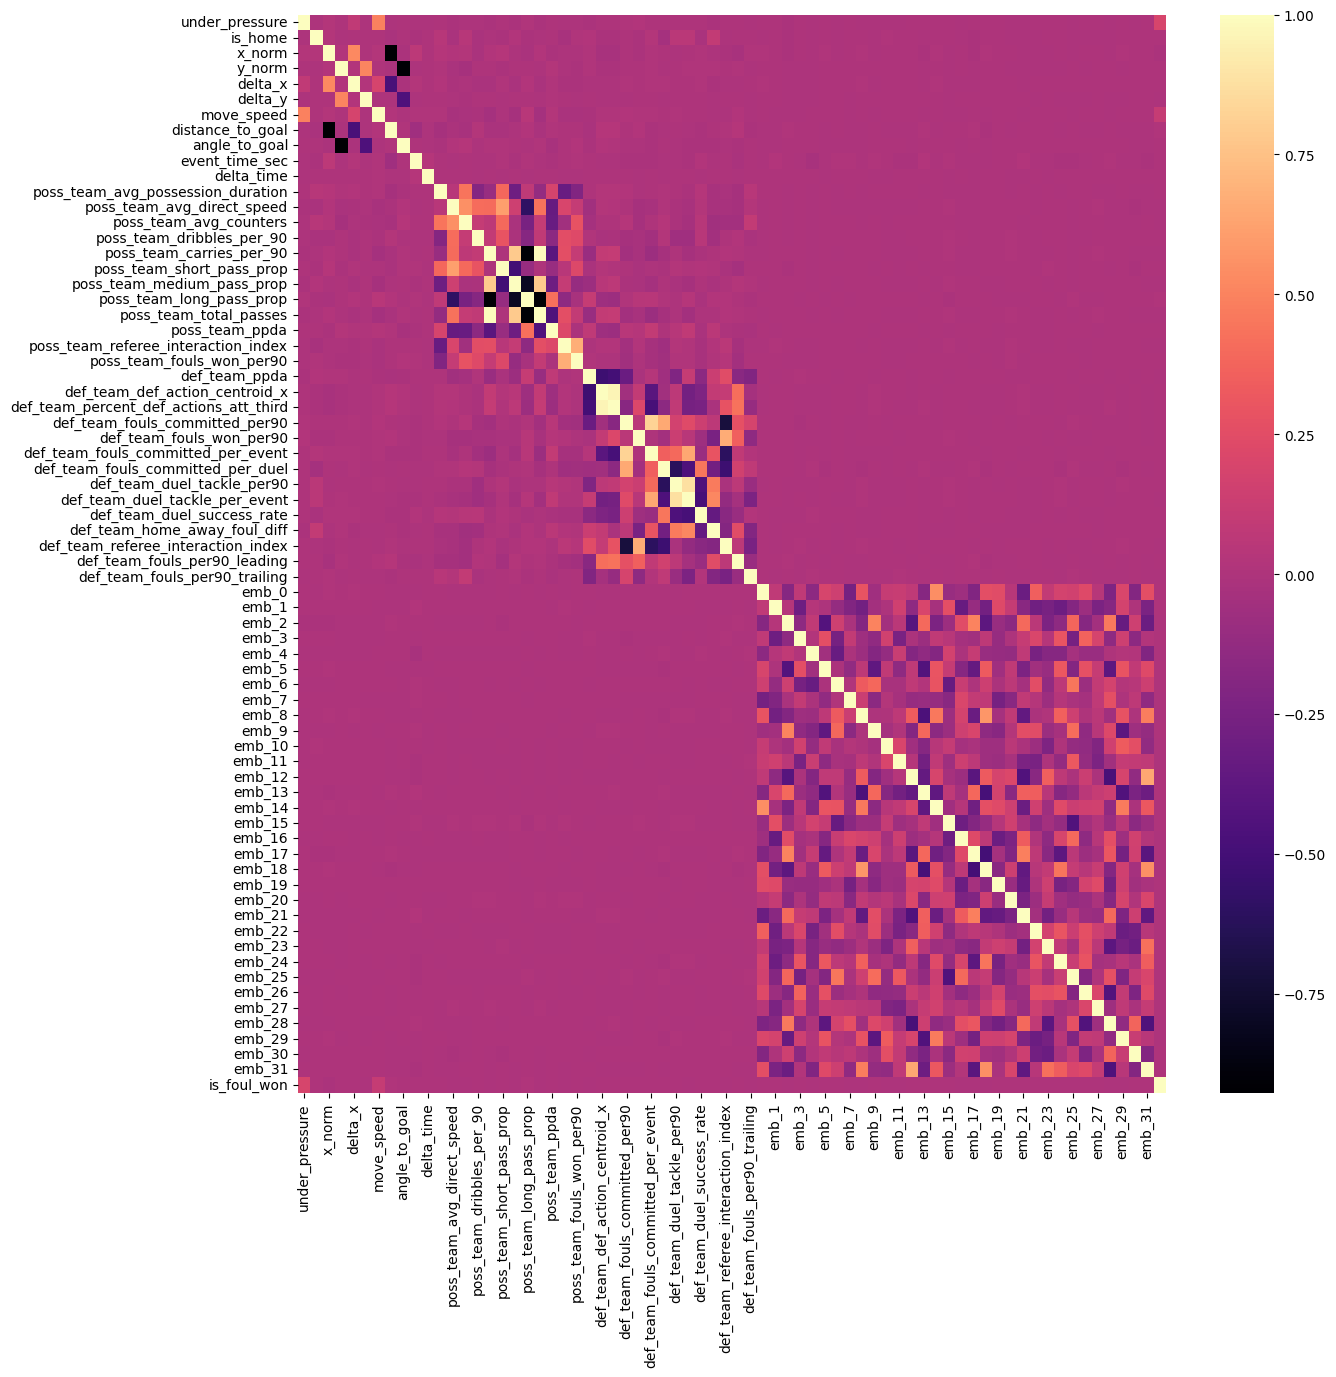

In [90]:
corr_df = sampled_model_df[features+['is_foul_won']].corr()

plt.figure(figsize=(14,14))
sns.heatmap(corr_df, cmap='magma')
plt.show()

In [91]:
len(features)

69

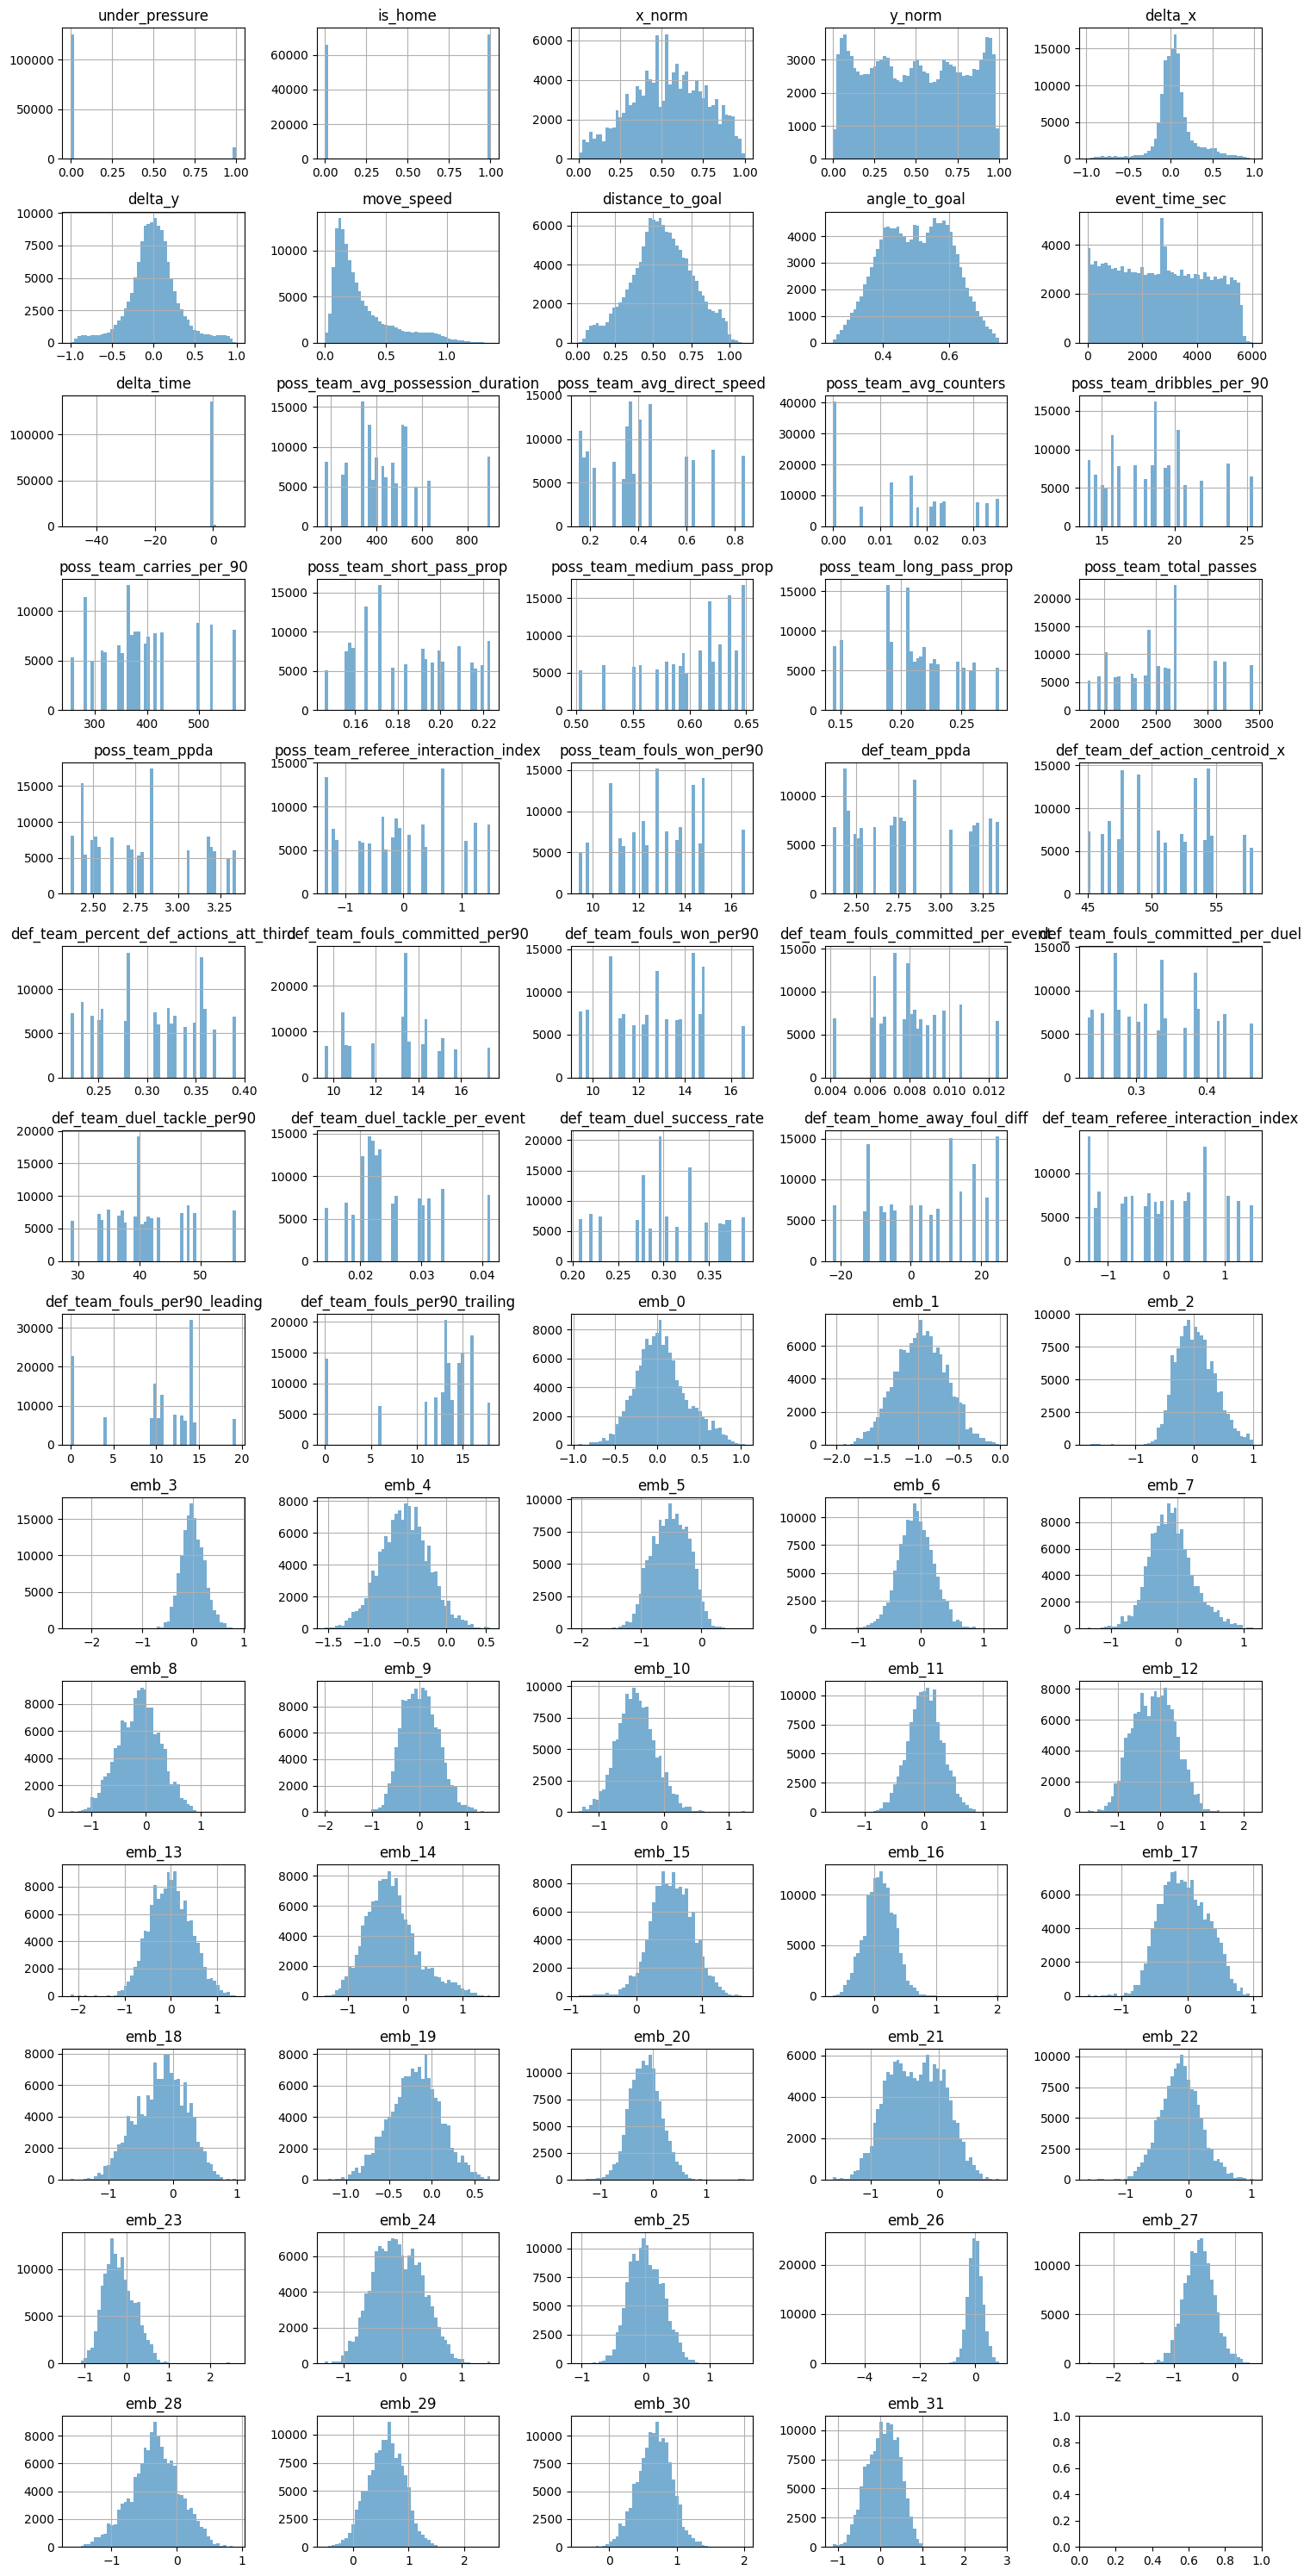

In [92]:
# feature histograms

num_features = len(features)
n_cols = 5
n_rows = int(num_features / n_cols)

fig, axs = plt.subplots(n_rows+1, n_cols, figsize=(15, 30))
row, col = 0,0
for f in features:
    sampled_model_df[f].hist(bins=50, ax=axs[row][col], alpha=0.6)
    
    axs[row][col].set_title(f)
    if col == n_cols-1:
        row+=1
        col=0
    else:
        col+=1
plt.tight_layout()
plt.show()

## Train Test Split

In [100]:
cutoff = int(sampled_model_df.match_id.quantile(0.8))
cutoff

3754269

In [101]:
train_df = sampled_model_df[sampled_model_df.match_id <= cutoff]
test_df  = sampled_model_df[sampled_model_df.match_id > cutoff]

In [102]:
train_df.shape, test_df.shape

((110434, 78), (27067, 78))

In [103]:
train_df['is_foul_won'].value_counts(normalize=True)

is_foul_won
0    0.992421
1    0.007579
Name: proportion, dtype: float64

In [104]:
test_df['is_foul_won'].value_counts(normalize=True)

is_foul_won
0    0.991724
1    0.008276
Name: proportion, dtype: float64

In [112]:
# label is very imbalanced, downsample class 0 

pos_df = train_df[train_df['is_foul_won'] == 1]
neg_df = train_df[train_df['is_foul_won'] == 0]

# foul won is still a rare event, downsampling to have class1% = 0.03
class1_prop = 0.02
class0_prop = int(len(pos_df)/class1_prop)
neg_sample = neg_df.sample(n=class0_prop, random_state=42)
train_df_bal = pd.concat([pos_df, neg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [113]:
train_df_bal.shape, train_df_bal['is_foul_won'].value_counts(normalize=True)

((42687, 78),
 is_foul_won
 0    0.980392
 1    0.019608
 Name: proportion, dtype: float64)

In [114]:
test_df['is_foul_won'].value_counts(normalize=True)

is_foul_won
0    0.991724
1    0.008276
Name: proportion, dtype: float64

In [115]:
pos_df = test_df[test_df['is_foul_won'] == 1]
neg_df = test_df[test_df['is_foul_won'] == 0]

# foul won is still a rare event, downsampling to have class1% = 0.03
class1_prop = 0.02
class0_prop = int(len(pos_df)/class1_prop)
neg_sample = neg_df.sample(n=class0_prop, random_state=42)
test_df_bal = pd.concat([pos_df, neg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [116]:
test_df_bal.shape, test_df_bal['is_foul_won'].value_counts(normalize=True)

((11424, 78),
 is_foul_won
 0    0.980392
 1    0.019608
 Name: proportion, dtype: float64)

In [117]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# train features

CAT = ['side_of_pitch']

# # Categorical → one‑hot
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe_df = pd.DataFrame(ohe.fit_transform(train_df_bal[CAT]), columns=ohe.get_feature_names_out())
# # Combine cat cols
train_df_bal = pd.concat([train_df_bal, ohe_df], axis=1)

test_ohe_df = pd.DataFrame(ohe.transform(test_df_bal[CAT]), columns=ohe.get_feature_names_out())
test_df_bal = pd.concat([test_df_bal.reset_index(drop=True), test_ohe_df], axis=1)

In [118]:
list(features)

['under_pressure',
 'is_home',
 'x_norm',
 'y_norm',
 'delta_x',
 'delta_y',
 'move_speed',
 'distance_to_goal',
 'angle_to_goal',
 'event_time_sec',
 'delta_time',
 'poss_team_avg_possession_duration',
 'poss_team_avg_direct_speed',
 'poss_team_avg_counters',
 'poss_team_dribbles_per_90',
 'poss_team_carries_per_90',
 'poss_team_short_pass_prop',
 'poss_team_medium_pass_prop',
 'poss_team_long_pass_prop',
 'poss_team_total_passes',
 'poss_team_ppda',
 'poss_team_referee_interaction_index',
 'poss_team_fouls_won_per90',
 'def_team_ppda',
 'def_team_def_action_centroid_x',
 'def_team_percent_def_actions_att_third',
 'def_team_fouls_committed_per90',
 'def_team_fouls_won_per90',
 'def_team_fouls_committed_per_event',
 'def_team_fouls_committed_per_duel',
 'def_team_duel_tackle_per90',
 'def_team_duel_tackle_per_event',
 'def_team_duel_success_rate',
 'def_team_home_away_foul_diff',
 'def_team_referee_interaction_index',
 'def_team_fouls_per90_leading',
 'def_team_fouls_per90_trailing',
 

In [119]:
training_features = features + list(ohe.get_feature_names_out())

X_train = train_df_bal[training_features]
X_test = test_df_bal[training_features]
y_train = train_df_bal['is_foul_won']
y_test = test_df_bal['is_foul_won']

## XGBoost Classifier

In [132]:
def objective(params):
    model = xgboost.XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        # tree_method="hist",     # faster for large datasets
        random_state=42,
        **params
    )
    model.fit(X_train[training_features], y_train, verbose=False)
    y_probs = model.predict_proba(X_test[training_features])[:, 1]
    pr_auc = average_precision_score(y_test, y_probs)

    return {
        'loss': -pr_auc,   # hyperopt minimizes, so negate the PR AUC
        'status': STATUS_OK,
        'pr_auc': pr_auc
    }

# Define the hyperparameter search space
space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),  # integers 3–9
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(50, 500)),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

trials = Trials()
best = fmin(
    fn=objective, 
    space=space, 
    algo=tpe.suggest, 
    max_evals=50, 
    trials=trials
)

print("Best hyperparameters:", best)

100%|███████| 50/50 [00:28<00:00,  1.78trial/s, best loss: -0.12864287864645613]
Best hyperparameters: {'colsample_bytree': np.float64(0.7169075129574112), 'gamma': np.float64(3.8797560870043797), 'learning_rate': np.float64(0.20921852349854625), 'max_depth': np.int64(4), 'min_child_weight': np.float64(2.9187932578961773), 'n_estimators': np.int64(88), 'subsample': np.float64(0.9898143449746089)}


In [133]:
xgb_clf = xgboost.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    n_estimators=88,
    max_depth=4,
    colsample_bytree=0.7169075129574112,
    gamma=3.8797560870043797,
    learning_rate=0.20921852349854625,
    min_child_weight=2.9187932578961773,
    subsample=0.9898143449746089,
    random_state=42
)

xgb_clf.fit(X_train[training_features], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7169075129574112, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=3.8797560870043797,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.20921852349854625,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2.9187932578961773, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=88,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [136]:
p_train = xgb_clf.predict_proba(X_train[training_features])[:,1]
p_test  = xgb_clf.predict_proba(X_test[training_features])[:,1]

print(f"TRAIN ROC‑AUC: {roc_auc_score(y_train, p_train):.4f}, TEST ROC-AUC: {roc_auc_score(y_test,  p_test):.4f}")
print(f"TRAIN PR‑AUC: {average_precision_score(y_train, p_train):.4f}, TEST PR-AUC: {average_precision_score(y_test,  p_test):.4f}")
print(f"TRAIN log‑loss: {log_loss(y_train, p_train):.4f}, TEST  log‑loss: {log_loss(y_test,  p_test):.4f}")

TRAIN ROC‑AUC: 0.9513, TEST ROC-AUC: 0.8612
TRAIN PR‑AUC: 0.4615, TEST PR-AUC: 0.1191
TRAIN log‑loss: 0.0578, TEST  log‑loss: 0.0766


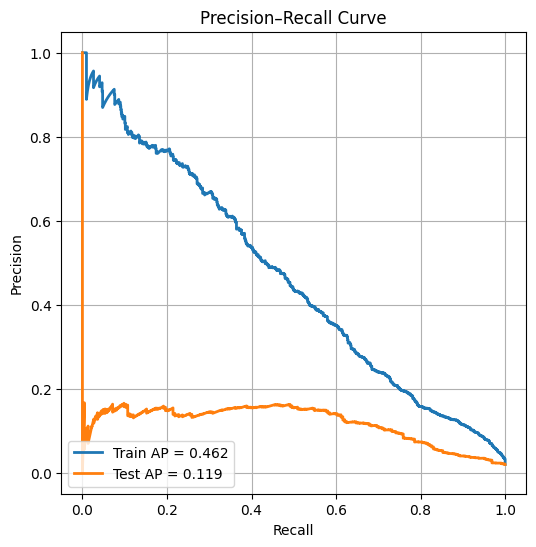

In [137]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(6, 6))

#train
precision, recall, thresholds = precision_recall_curve(y_train, p_train)
avg_prec = average_precision_score(y_train, p_train)
plt.plot(recall, precision, lw=2, label=f'Train AP = {avg_prec:.3f}')

#test
precision, recall, thresholds = precision_recall_curve(y_test, p_test)
avg_prec = average_precision_score(y_test, p_test)
plt.plot(recall, precision, lw=2, label=f'Test AP = {avg_prec:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Top 20 features by importance:
under_pressure                        0.297338
delta_time                            0.038137
delta_y                               0.032578
move_speed                            0.021965
x_norm                                0.015055
poss_team_fouls_won_per90             0.014675
poss_team_ppda                        0.013874
poss_team_long_pass_prop              0.013275
delta_x                               0.013252
def_team_fouls_committed_per_event    0.013040
emb_2                                 0.013035
def_team_fouls_committed_per_duel     0.012737
emb_5                                 0.012433
poss_team_total_passes                0.012246
def_team_fouls_per90_trailing         0.011502
emb_25                                0.011283
emb_9                                 0.011279
def_team_duel_tackle_per90            0.011254
poss_team_avg_possession_duration     0.011237
emb_29                                0.011155
dtype: float32


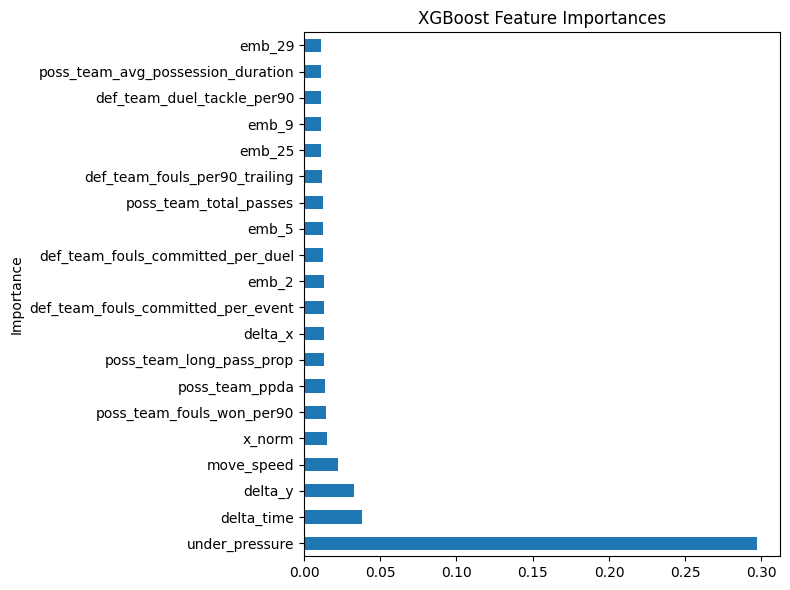

In [140]:
importances = xgb_clf.feature_importances_

feat_imp = pd.Series(importances, index=training_features)

feat_imp = feat_imp.sort_values(ascending=False)

print("Top 20 features by importance:")
print(feat_imp.head(20))

plt.figure(figsize=(8,6))
feat_imp.head(20).plot.barh()
plt.title("XGBoost Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

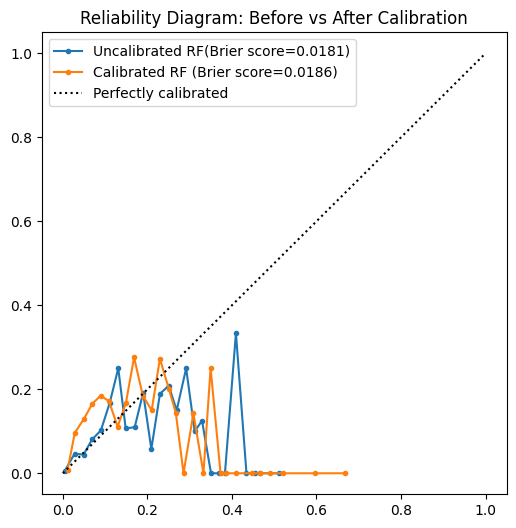

In [143]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss


calibrated_xgb = CalibratedClassifierCV(
    estimator=xgb_clf,
    method="sigmoid",
    cv=5,
)

calibrated_xgb.fit(X_train, y_train)

probs_cal = calibrated_xgb.predict_proba(X_test)[:, 1]
frac_pos, mean_pred_val = calibration_curve(
    y_test, p_test, n_bins=50
)
frac_pos_cal, mean_pred_val_cal = calibration_curve(
    y_test, probs_cal, n_bins=50
)

uncal_brier = brier_score_loss(y_test, p_test)
cal_brier = brier_score_loss(y_test, probs_cal)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred_val, frac_pos, ".-", label=f"Uncalibrated RF(Brier score={uncal_brier:.4f})")
plt.plot(mean_pred_val_cal, frac_pos_cal, ".-", label=f"Calibrated RF (Brier score={cal_brier:.4f})")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.legend()
plt.title("Reliability Diagram: Before vs After Calibration")
plt.show()

- Addition of LSTM event embeddings required change in the training data compared to previous experiments
- The XGBoost model fits the training data well but isn't able to generalise on events later in the season
- ROC-AUC improved relative to earlier XGBoost (0.862 → 0.861 ≈ identical), but PR-AUC collapsed (0.18 → 0.12) despite richer event-sequence information.
- Most gain still comes from instantaneous pressure, time gaps, and raw movement vectors. The sequence-level embeddings help but don’t displace these fundamentals.
- Five embedding features are in the top 20 important features, suggesting the (naive) auto-encoder does capture the signal in the long term sequences.
- As the Seq2Event paper suggests, sequences of minimum length 40 is required to capture the game context. Our autoencoder was trained on $N=7$, so a longer sequence will yeild better results.

----------------------------------
# Experimental Summary

The notebook walks through several experiments aimed at enriching classical ML inputs so that models produce better‐calibrated foul‐win probabilities:

1. **Game State & Spatio‐Temporal Feature Engineering**  
   We crafted 13 first‐touch features—e.g. normalized pitch coordinates, `move_speed`, `distance_to_goal`, `side_of_pitch` —to capture the immediate context of each event.  
   - **Key insight:** Even simple “where” and “when” signals (`side_of_pitch`, stoppage‐time flag) strongly influence foul‐win odds.  
   - **Caveat:** Some features (e.g. `under_pressure`) may embed data‐collection or tactical biases.

2. **Team Embedding Construction**  
   We aggregated the last 5 matches per team into a compact “team context” vector of defensive, pressing, possession, attacking and foul‐differential metrics.  
   - **Key insight:** Adding team‐level stats (e.g. PPDA, foul‐differential vs. home/away) marginally boosted precision‐recall in tree‐based models.  
   - **Caveat:** Embeddings assume stationarity—team style, which may shift mid‐season.
   - **Next Steps:** We can improve the embeddings by implementing *Exponential Moving Weighted Averages (EMWA)* to  capture the involving playing style while ensuring no data leakage. Given enough data, we can create player embeddings to represent individual player, posterior mean from our bayesian hierarchial model was used as a proxy while modelling previous sequences.

3. **Previous $N$ Sequence Modelling**  
   We extracted summary statistics (`duration, direct‐speed, tempo`) over the prior 20 on‐ball events, plus first‐order Markov “lift” scores. We also designed a bayesian hierarchical model as a proxy for player embeddings.
   - **Key insight:** Sequence‐derived lifts captured non‐linear event‐to‐event dependencies, but most predictive power remained in `under_pressure` and spatio‐temporal cues.  
   - **Caveat:** Limiting to 20 events avoids memory issues but may truncate critical build‐up phases.
   - **Next Steps:** Extending the look-back window can capture more context but we need to be cautious by selecting an optimal $N$ to reduce noise.

4. **LSTM Autoencoder for Sequence Embedding**  
   An LSTM‐based autoencoder learned a 32‐dim latent representation per event chain, which was then fed to XGBoost.  
   - **Key insight:** Latent codes drove extremely low train log‐loss (0.058) but suffered severe over‐fit (test PR‐AUC dropped to 0.12).  
   - **Caveat:** Deep sequence embeddings require far more data (or stronger regularization) to generalize.
   - **Next Steps:** Longer sequences and better regularization is key to developing an effective sequence embedding.

---
**Overall Take‐Aways:**  
- **Under‐pressure** remains the single most dominant signal.  
- **Context (team + sequence)** yields incremental gains but cannot fully overcome class imbalance.  
- **Calibration & validation** (time‐based splits, Platt/Isotonic) are critical next steps before any deployment. XGBoost proved to be the best model for reliable probability predictions.

-----
# Future Work

Sticking to the event data, we could leverage the neural architecture proposed in the [Seq2Event](https://eprints.soton.ac.uk/458099/1/KDD22_paper_CReady_v20220606.pdf) and augment the encoder–decoder with our bespoke context vectors and attention mechanisms:
- **Context fusion**: concatenate at each time‐step the learned event embedding with
	- the 32-dim team‐embedding vector
	- the 20-event summary (duration, direct‐speed, counter‐flag)
	- the 13 raw spatio‐temporal features (e.g. under_pressure, side_of_pitch)


- **Multi-head self-attention**: insert Transformer blocks on top of the LSTM encoder to re-weight past events by their relevance to a foul being won.

- **Graph encoder for pressure**: if player-tracking data becomes available, use a small GNN to encode “who’s around” the ball carrier and inject that as an extra context channel

- **Multi-task heads**: simultaneously predict
	1.	the next event type (as in Seq2Event)
	2.	a binary foul_won flag for the current chain
	3.	a calibrated probability via a small post-hoc isotonic or temperature‐scaled head

- **Hybrid loss**: combine cross-entropy for event prediction, BCE for foul-win classification, and a small contrastive term to keep latent codes smooth

With this enriched architecture—end-to-end trainable on both sequence and foul labels—we should be able to better capture both micro (event‐to‐event) and macro (team/style/pressure) drivers of foul events